# Statistical Methods in Astrophysics Exercises

## Week 06: Multivariate Analysis

### Personal Information

**Name:** physnya



### Exercise 1: spectral line fitting

The expected photon counts of a galaxy spectrum are as follows (Gaussian emission line plus constant background):

$N_{\rm exp, 1} = A_1 \exp \left[ - \dfrac{(x - x_0)^2}{2 w_1^2} \right] + B_1$

with $x_0 = 0$, $B_1=50$, and integer wavelengths $x \in [-25, 25]$ (51 bins).

#### Question 1.1: parameter inference

**Tasks:**
1. Simulate an observed spectrum with $A_1 = 50, w_1 = 5$, and compare it to the expected spectrum.
2. Infer $A_1$ and $w_1$ from the simulated spectrum using scale-invariant priors $p(A_1,w_1|I) \propto 1 / (A_1 w_1)$ with the ranges $A_1 \in [10, 250]$ and $w_1 \in [1, 25]$.
3. Plot the joint posterior distributions of $A_1$ and $w_1$ as well as the marginalized posterior distributions of each parameter.
4. Report the mean, standard deviation, and 16-50-84 percentiles of the marginalized posterior distributions, as well as the covariance matrix of the joint posterior distribution.

**Hint:** The actual photon count of each bin follows a Poisson distribution with the expected count as the mean.

In [66]:
# NOTE: Run this cell in the first place
# Load packages for numerical calculations and plotting
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
# Enable inline plotting in Jupyter notebooks
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300
%matplotlib inline
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
# 由于设置了图片的高 dpi 和字体，所以编译速度变慢.

In [67]:
def spec_model(x, A, w, B, x0=0):
    """Model (expected) photon counts of a galaxy spectrum with a Gaussian line plus constant background.
    Args:
        x: array-like, wavelengths
        A: float, line amplitude
        w: float, line width (standard deviation)
        B: float, background level
        x0: float, line center (default: 0)
    Return: numpy array, expected photon counts at each wavelength
    """
    n = [A * np.exp(- (xi - x0)**2 / (2 * w**2)) + B for xi in x]
    return np.array(n)

def sim_spec(A, w, B, x0=0, seed=42):
    """Simulate a galaxy spectrum with given background and line width.
    Args:
        A: float, line amplitude
        w: float, line width (standard deviation)
        B: float, background level
        x0: float, line center (default: 0)
        seed: int, random seed for reproducibility (default: 42)
    Returns:
        x: numpy array, wavelengths
        n_obs: numpy array, observed photon counts at each wavelength
    """
    x = np.arange(-25, 26, 1)           # Wavelengths from -25 to 25
    N_exp = spec_model(x, A, w, B, x0)  # Expected photon counts
    rng = np.random.default_rng(seed)
    n_obs = rng.poisson(N_exp)          # Simulate observed counts from Poisson distribution
    return x, n_obs

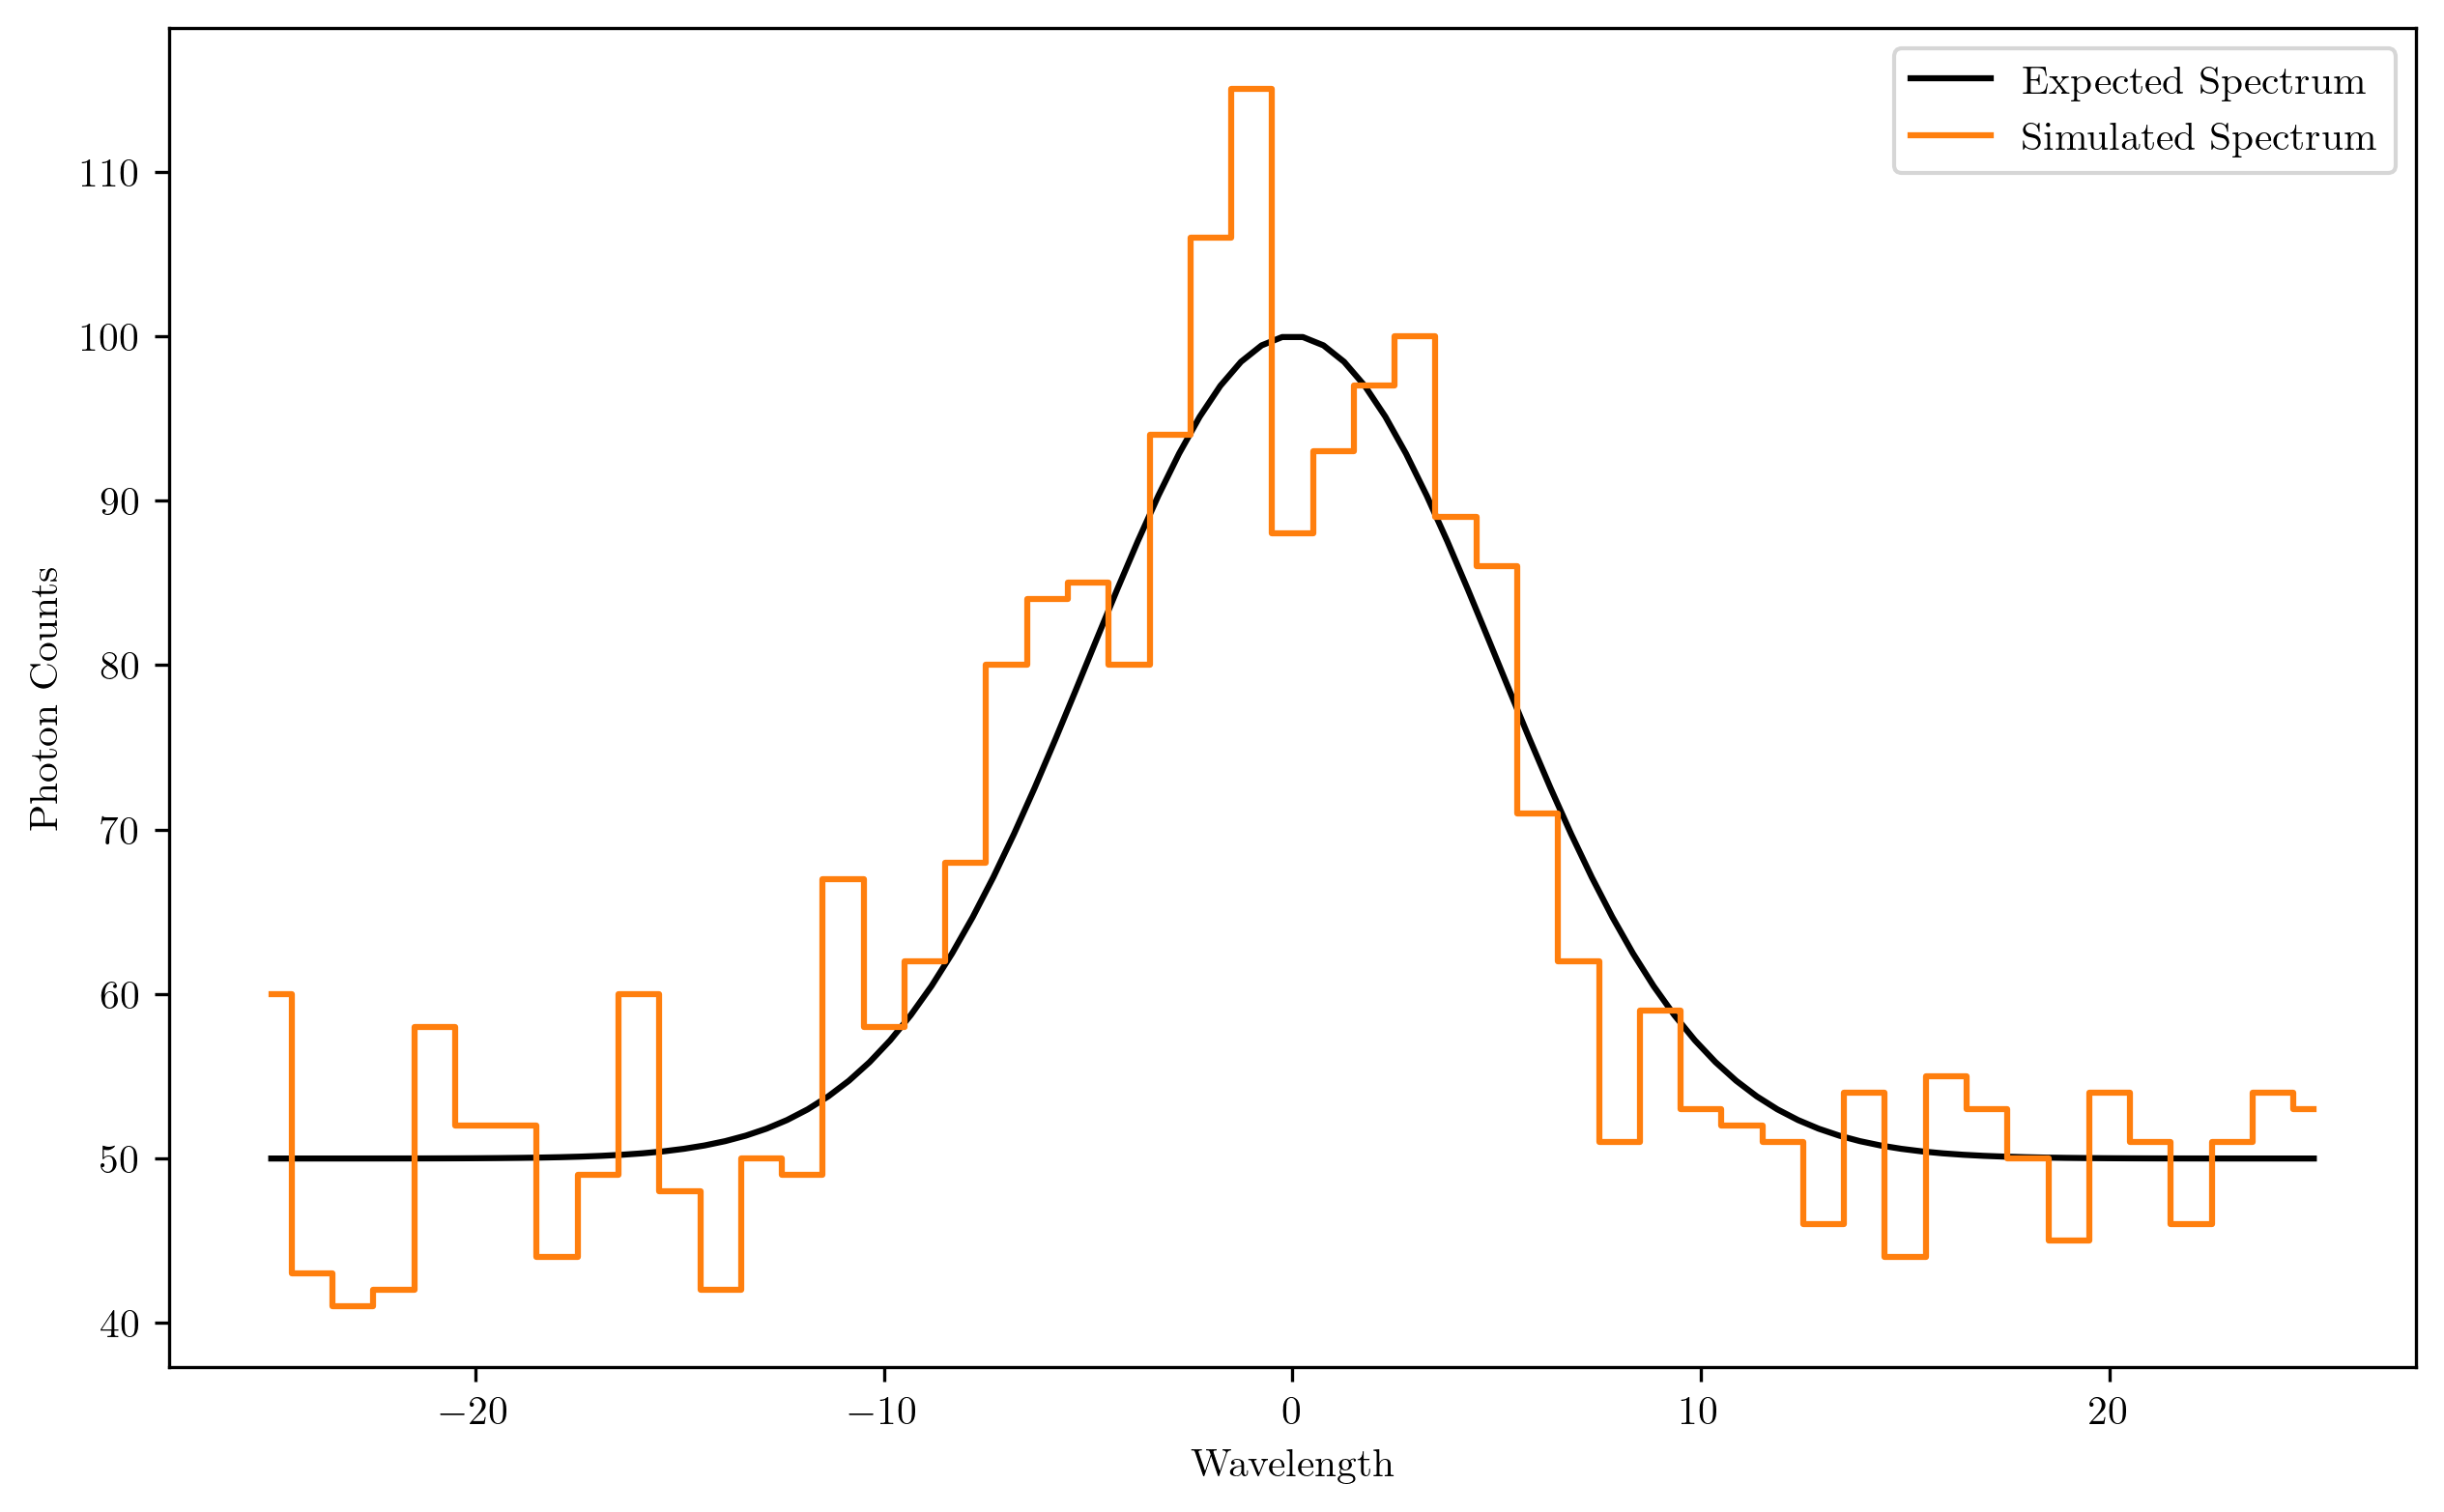

In [68]:
# Set the random seed
seed = 2024011182  # NOTE: EDIT HERE to insert your seed as the seed
A1_true = 50
w1_true = 5
B1_true = 50

# Simulate the spectrum
x, spec1 = sim_spec(A1_true, w1_true, B1_true, seed=seed)

# Compute the expected spectrum with true parameters for comparison
x_model = np.linspace(-25, 25, 100)
spec1_model = spec_model(x_model, A=A1_true, w=w1_true, B=B1_true)

# Plot the model and simulated spectrum
plt.figure(figsize=(10, 6))
plt.plot(x_model, spec1_model, label='Expected Spectrum', color='k')
plt.plot(x, spec1, drawstyle='steps-mid', label='Simulated Spectrum', color='tab:orange')
plt.xlabel('Wavelength')
plt.ylabel('Photon Counts')
plt.legend()
plt.show()

In [69]:
def spec_posterior_A_w(x, n_obs, B=50, x0=0, A_range=(10, 250), w_range=(1, 25), n_A=500, n_w=500):
    """Compute the posterior distribution of line amplitude A and width w given observed spectrum.
    Args:
        x: array-like, wavelengths
        n_obs: array-like, observed photon counts
        B: float, background level (default: 50)
        x0: float, line center (default: 0)
        A_range: tuple, prior range of A values (default: (10, 250))
        w_range: tuple, prior range of w values (default: (1, 25))
        n_A: int, number of A samples (default: 500)
        n_w: int, number of w samples (default: 500)
    Returns:
        A_grid : numpy array, sampled A values
        w_grid: numpy array, sampled w values
        posterior: numpy array, posterior probabilities for each (A, w) pair
    """
    A_vals = np.linspace(A_range[0], A_range[1], n_A)
    w_vals = np.linspace(w_range[0], w_range[1], n_w)
    dAdw = (A_range[1] - A_range[0]) / n_A * (w_range[1] - w_range[0]) / n_w
    A_grid, w_grid = np.meshgrid(A_vals, w_vals)

    n_model = spec_model(x, A_grid, w_grid, B, x0)
    # NOTE: EDIT below to compute the log-posterior
    eps = 1e-12
    # n_model has shape (len(x), n_w, n_A); sum log-likelihood over wavelength axis (axis=0)
    log_like = np.sum(-n_model + n_obs[:, None, None] * np.log(n_model + eps), axis=0)
    # scale-invariant prior: p(A,w) prop 1/(A w) -> log_prior = -log A - log w
    log_prior = -np.log(A_grid) - np.log(w_grid)
    log_post = log_prior + log_like

    posterior = np.exp(log_post - np.max(log_post))
    posterior /= np.sum(posterior) * dAdw  # Normalize posterior
    return A_grid, w_grid, posterior

In [70]:
# Helper functions to plot credible levels, compute marginalize posterior and summary statistics
def plot_credible_levels(ax, par1, par2, posterior, levels=[95, 68], **contour_kwargs):
    """Plot credible levels on the given axes.
    Args:
        ax: matplotlib.axes.Axes, the axes to plot on
        par1: numpy array, first parameter grid
        par2: numpy array, second parameter grid
        posterior: numpy array, the 2D posterior probabilities
        levels: list, the credible levels to plot (default: [95, 68])
        contour_kwargs: additional keyword arguments for contour plotting
    """
    # Sort posterior values in descending order
    p_sorted = np.sort(posterior.ravel())[::-1]

    # Compute cumulative sum of sorted posterior values
    cdf = np.cumsum(p_sorted)
    cdf /= cdf[-1]  # Normalize to 1

    levels = np.asarray(levels, float) / 100.0
    idx = np.searchsorted(cdf, levels, side='left')
    clevels = p_sorted[idx]

    ax.contour(par1, par2, posterior, levels=clevels, **contour_kwargs)

def marginalize_posterior(par1, par2, posterior):
    """Marginalize the 2D posterior distribution over each parameter.
    Args:
        par1: numpy array, first parameter grid
        par2: numpy array, second parameter grid
        posterior: numpy array, the 2D posterior probabilities
    Returns:
        par1_vals: numpy array, values of the first parameter
        post_marg1: numpy array, marginalized posterior over the first parameter
        par2_vals: numpy array, values of the second parameter
        post_marg2: numpy array, marginalized posterior over the second parameter
    """
    par1_vals = par1[0]
    par2_vals = par2[:, 0]
    post_marg1 = posterior.sum(axis=0)
    post_marg2 = posterior.sum(axis=1)
    return par1_vals, post_marg1, par2_vals, post_marg2

def compute_percentile(x, pdf, percentiles=[16, 50, 84]):
    """Compute the percentiles of a distribution given its PDF
    Args:
        x : array, grid of x values
        pdf : array, probability density function values corresponding to x
        percent : float, desired percentile (0-100)
    Returns: array of percentile values
    """
    cdf = cumulative_trapezoid(pdf, x, initial=0)
    cdf /= cdf[-1]  # Normalize to make it a proper CDF
    return np.interp(np.array(percentiles) / 100, cdf, x)

In [71]:
# NOTE: EDIT below to create two helper functions:
# 1. Compute the mean and standard deviation from a marginalized posterior
# 2. Compute the covariance matrix from a 2D posterior
# These functions will also be used in later exercises
def summarize_marginal(x, pdf, percentiles=[16, 50, 84]):
    """Compute mean, std and given percentiles from a marginalized posterior PDF.
    Args:
        x: 1D array of parameter values
        pdf: 1D array of PDF values at x (not necessarily normalized)
        percentiles: list of percentiles to compute (in percent)
    Returns:
        mean: float
        std: float (standard deviation)
        pvals: numpy array of percentile locations in same order as `percentiles`
    """
    x = np.asarray(x)
    pdf = np.asarray(pdf, dtype=float)
    # normalize pdf using trapezoidal rule
    Z = np.trapezoid(pdf, x)
    if Z <= 0:
        raise ValueError("PDF integrates to zero or negative; check input.")
    pdf_norm = pdf / Z
    mean = np.trapezoid(x * pdf_norm, x)
    var = np.trapezoid((x - mean)**2 * pdf_norm, x)
    std = np.sqrt(var)
    pvals = compute_percentile(x, pdf_norm, percentiles)
    return mean, std, pvals

def covariance_from_2d(par1_grid, par2_grid, posterior):
    """Compute means and covariance matrix from a 2D joint posterior.
    Args:
        par1_grid: 2D array (ny, nx) of first parameter values (meshgrid)
        par2_grid: 2D array (ny, nx) of second parameter values (meshgrid)
        posterior: 2D array (ny, nx) of joint posterior (not necessarily normalized)
    Returns:
        mean1: float, mean of parameter 1
        mean2: float, mean of parameter 2
        cov: 2x2 numpy array covariance matrix [[var1, cov12],[cov12, var2]]
    """
    # Extract 1D coordinate vectors (assumes regular grids produced by np.meshgrid)
    x_vals = par1_grid[0]      # shape (nx,)
    y_vals = par2_grid[:,0]    # shape (ny,)

    # integrate posterior to get normalization Z
    inner = np.trapezoid(posterior, x=x_vals, axis=1)  # integrate over x -> shape (ny,)
    Z = np.trapezoid(inner, x=y_vals)                  # scalar
    if Z <= 0:
        raise ValueError("Joint posterior integrates to zero or negative; check input.")

    # Expectations
    Ex_num = np.trapezoid(np.trapezoid(posterior * par1_grid, x=x_vals, axis=1), x=y_vals)
    Ey_num = np.trapezoid(np.trapezoid(posterior * par2_grid, x=x_vals, axis=1), x=y_vals)
    Ex = Ex_num / Z
    Ey = Ey_num / Z

    Exx = np.trapezoid(np.trapezoid(posterior * par1_grid**2, x=x_vals, axis=1), x=y_vals) / Z
    Eyy = np.trapezoid(np.trapezoid(posterior * par2_grid**2, x=x_vals, axis=1), x=y_vals) / Z
    Exy = np.trapezoid(np.trapezoid(posterior * par1_grid * par2_grid, x=x_vals, axis=1), x=y_vals) / Z

    var_x = Exx - Ex**2
    var_y = Eyy - Ey**2
    cov_xy = Exy - Ex * Ey

    cov = np.array([[var_x, cov_xy],
                    [cov_xy, var_y]])
    return Ex, Ey, cov

In [72]:
# Set the prior ranges and compute the posteriors
A1_range = [A1_true * 0.2, A1_true * 5]
w1_range = [w1_true * 0.2, w1_true * 5]
A1_sample = 500
w1_sample = 500
A1_grid, w1_grid, posterior1 = spec_posterior_A_w(
    x, spec1, B=B1_true, x0=0, A_range=A1_range,
    w_range=w1_range, n_A=A1_sample, n_w=w1_sample
)

A1_vals, post_marg_A1, w1_vals, post_marg_w1 = marginalize_posterior(A1_grid, w1_grid, posterior1)

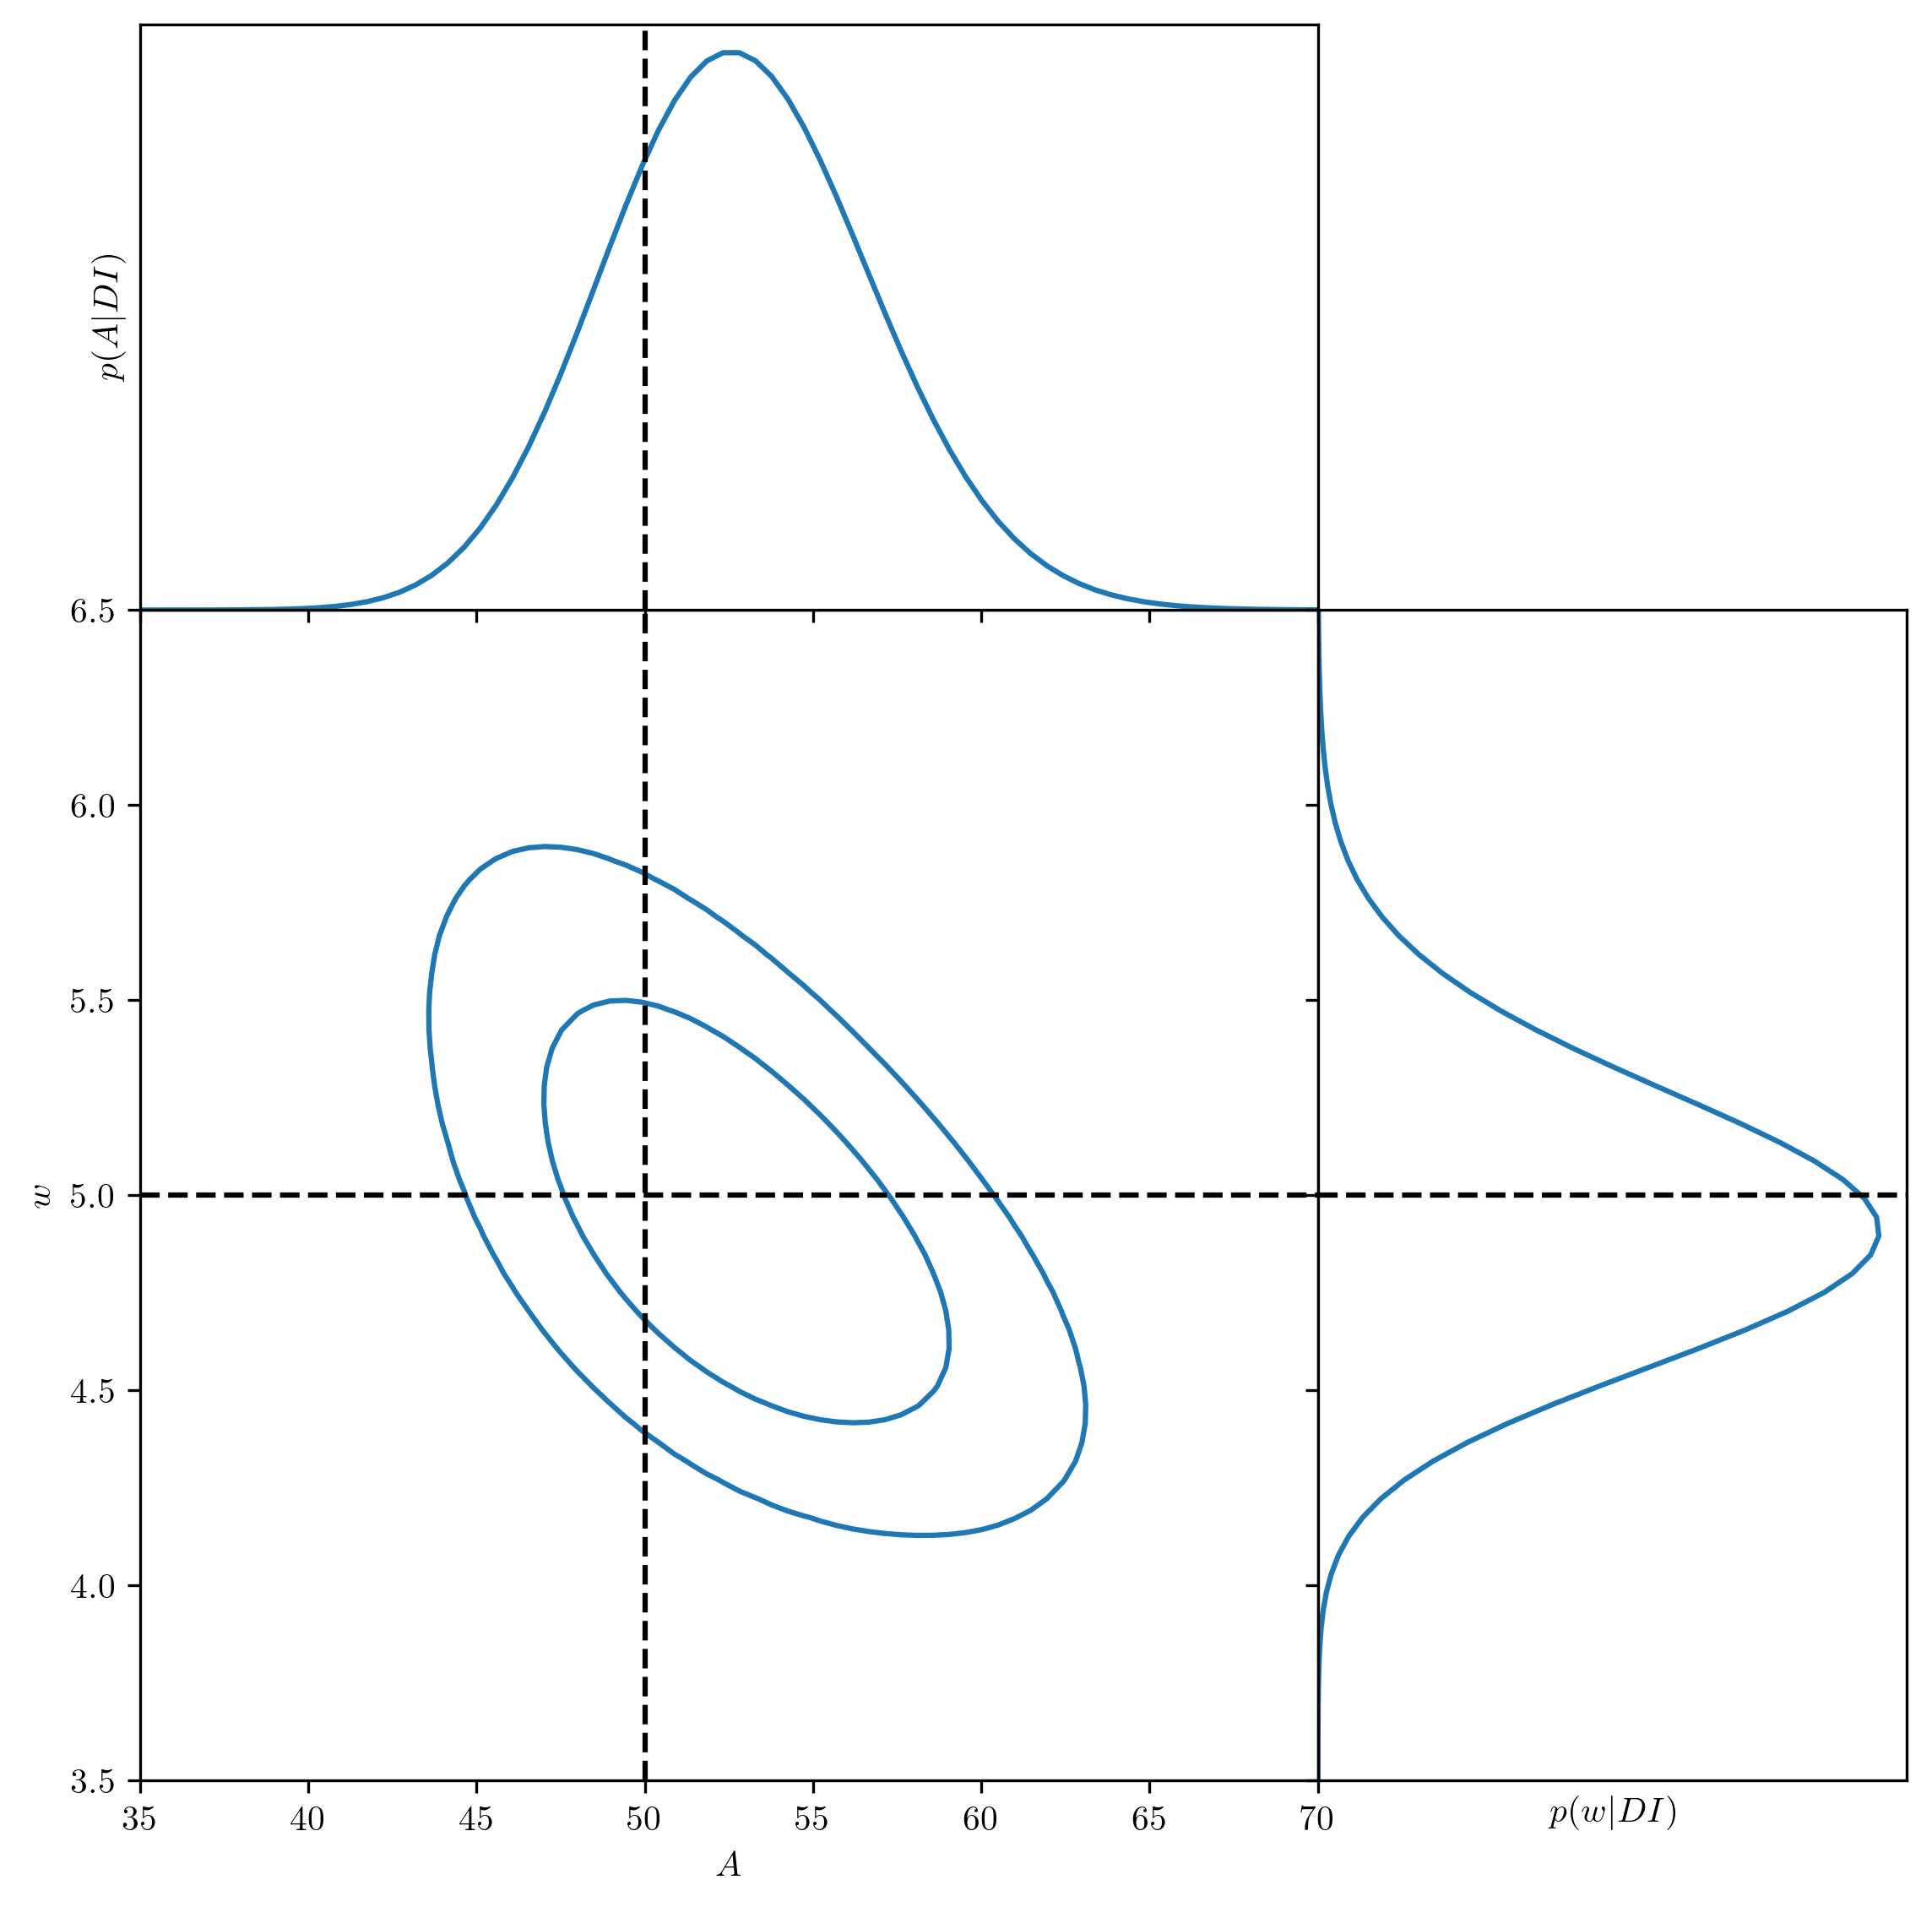

In [73]:
# Plot the posterior distribution and marginalized distributions
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

plot_credible_levels(ax0, A1_grid, w1_grid, posterior1, colors='tab:blue')

ax1.plot(A1_vals, post_marg_A1, color='tab:blue')
ax2.plot(post_marg_w1, w1_vals, color='tab:blue')

ax0.axhline(w1_true, color='k', linestyle='--')
ax0.axvline(A1_true, color='k', linestyle='--')
ax1.axvline(A1_true, color='k', linestyle='--')
ax2.axhline(w1_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([A1_true - 15, A1_true + 20])
ax0.set_ylim([w1_true - 1.5, w1_true + 1.5])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$A$')
ax0.set_ylabel(r'$w$')
ax1.set_ylabel(r'$p(A | DI)$')
ax2.set_xlabel(r'$p(w | DI)$')
plt.show()

In [74]:
# NOTE: EDIT below to report the mean, standard deviation, 16-50-84 percentiles, and covariance matrix of A and w
mean_A, std_A, p_A = summarize_marginal(A1_vals, post_marg_A1, percentiles=[16,50,84])
mean_w, std_w, p_w = summarize_marginal(w1_vals, post_marg_w1, percentiles=[16,50,84])

mean_A_joint, mean_w_joint, cov_Aw = covariance_from_2d(A1_grid, w1_grid, posterior1)

print(f"A (marginal): mean = {mean_A:.4f}, std = {std_A:.4f}, 16-50-84 = {p_A}")
print(f"w (marginal): mean = {mean_w:.4f}, std = {std_w:.4f}, 16-50-84 = {p_w}")
print("\nJoint posterior means from full 2D posterior:")
print(f" mean A = {mean_A_joint:.4f}, mean w = {mean_w_joint:.4f}")
print("Covariance matrix (A, w):")
print(cov_Aw)

A (marginal): mean = 52.8216, std = 3.9829, 16-50-84 = [48.85504186 52.73650063 56.78708437]
w (marginal): mean = 4.9512, std = 0.3604, 16-50-84 = [4.5935617  4.93707031 5.30838778]

Joint posterior means from full 2D posterior:
 mean A = 52.8216, mean w = 4.9512
Covariance matrix (A, w):
[[15.86325368 -0.83016287]
 [-0.83016287  0.12987004]]


#### Question 1.2: a second spectral line

A new emission line is discovered in the same galaxy spectrum, with a similar Gaussian profile:

$N_{\rm exp, 2} = A_2 \exp \left[ - \dfrac{(x - x_0)^2}{2 w_2^2} \right] + B_2$

with $A_2=30$, $x_0 = 0$, and the same integer wavelengths $x \in [-25, 25]$ (51 bins). (The center of the second line is shifted to $x_0 = 0$ for simplicity, but the two lines do not overlap and are independent.)

**Tasks:**
1. Simulate an observed spectrum with $B_2 = 50, w_2 = 5$ using a new random seed, and compare it to the expected spectrum.
2. Infer $B_2$ and $w_2$ from the simulated spectrum using scale-invariant priors $p(B_2,w_2|I) \propto 1 / (B_2 w_2)$ with the ranges $B_2 \in [10, 250]$ and $w_2 \in [1, 25]$.
3. Plot the joint posterior distributions of $B_2$ and $w_2$ as well as the marginalized posterior distributions of each parameter.
4. Report the mean, standard deviation, and 16-50-84 percentiles of the marginalized posterior distributions, as well as the covariance matrix of the joint posterior distribution.

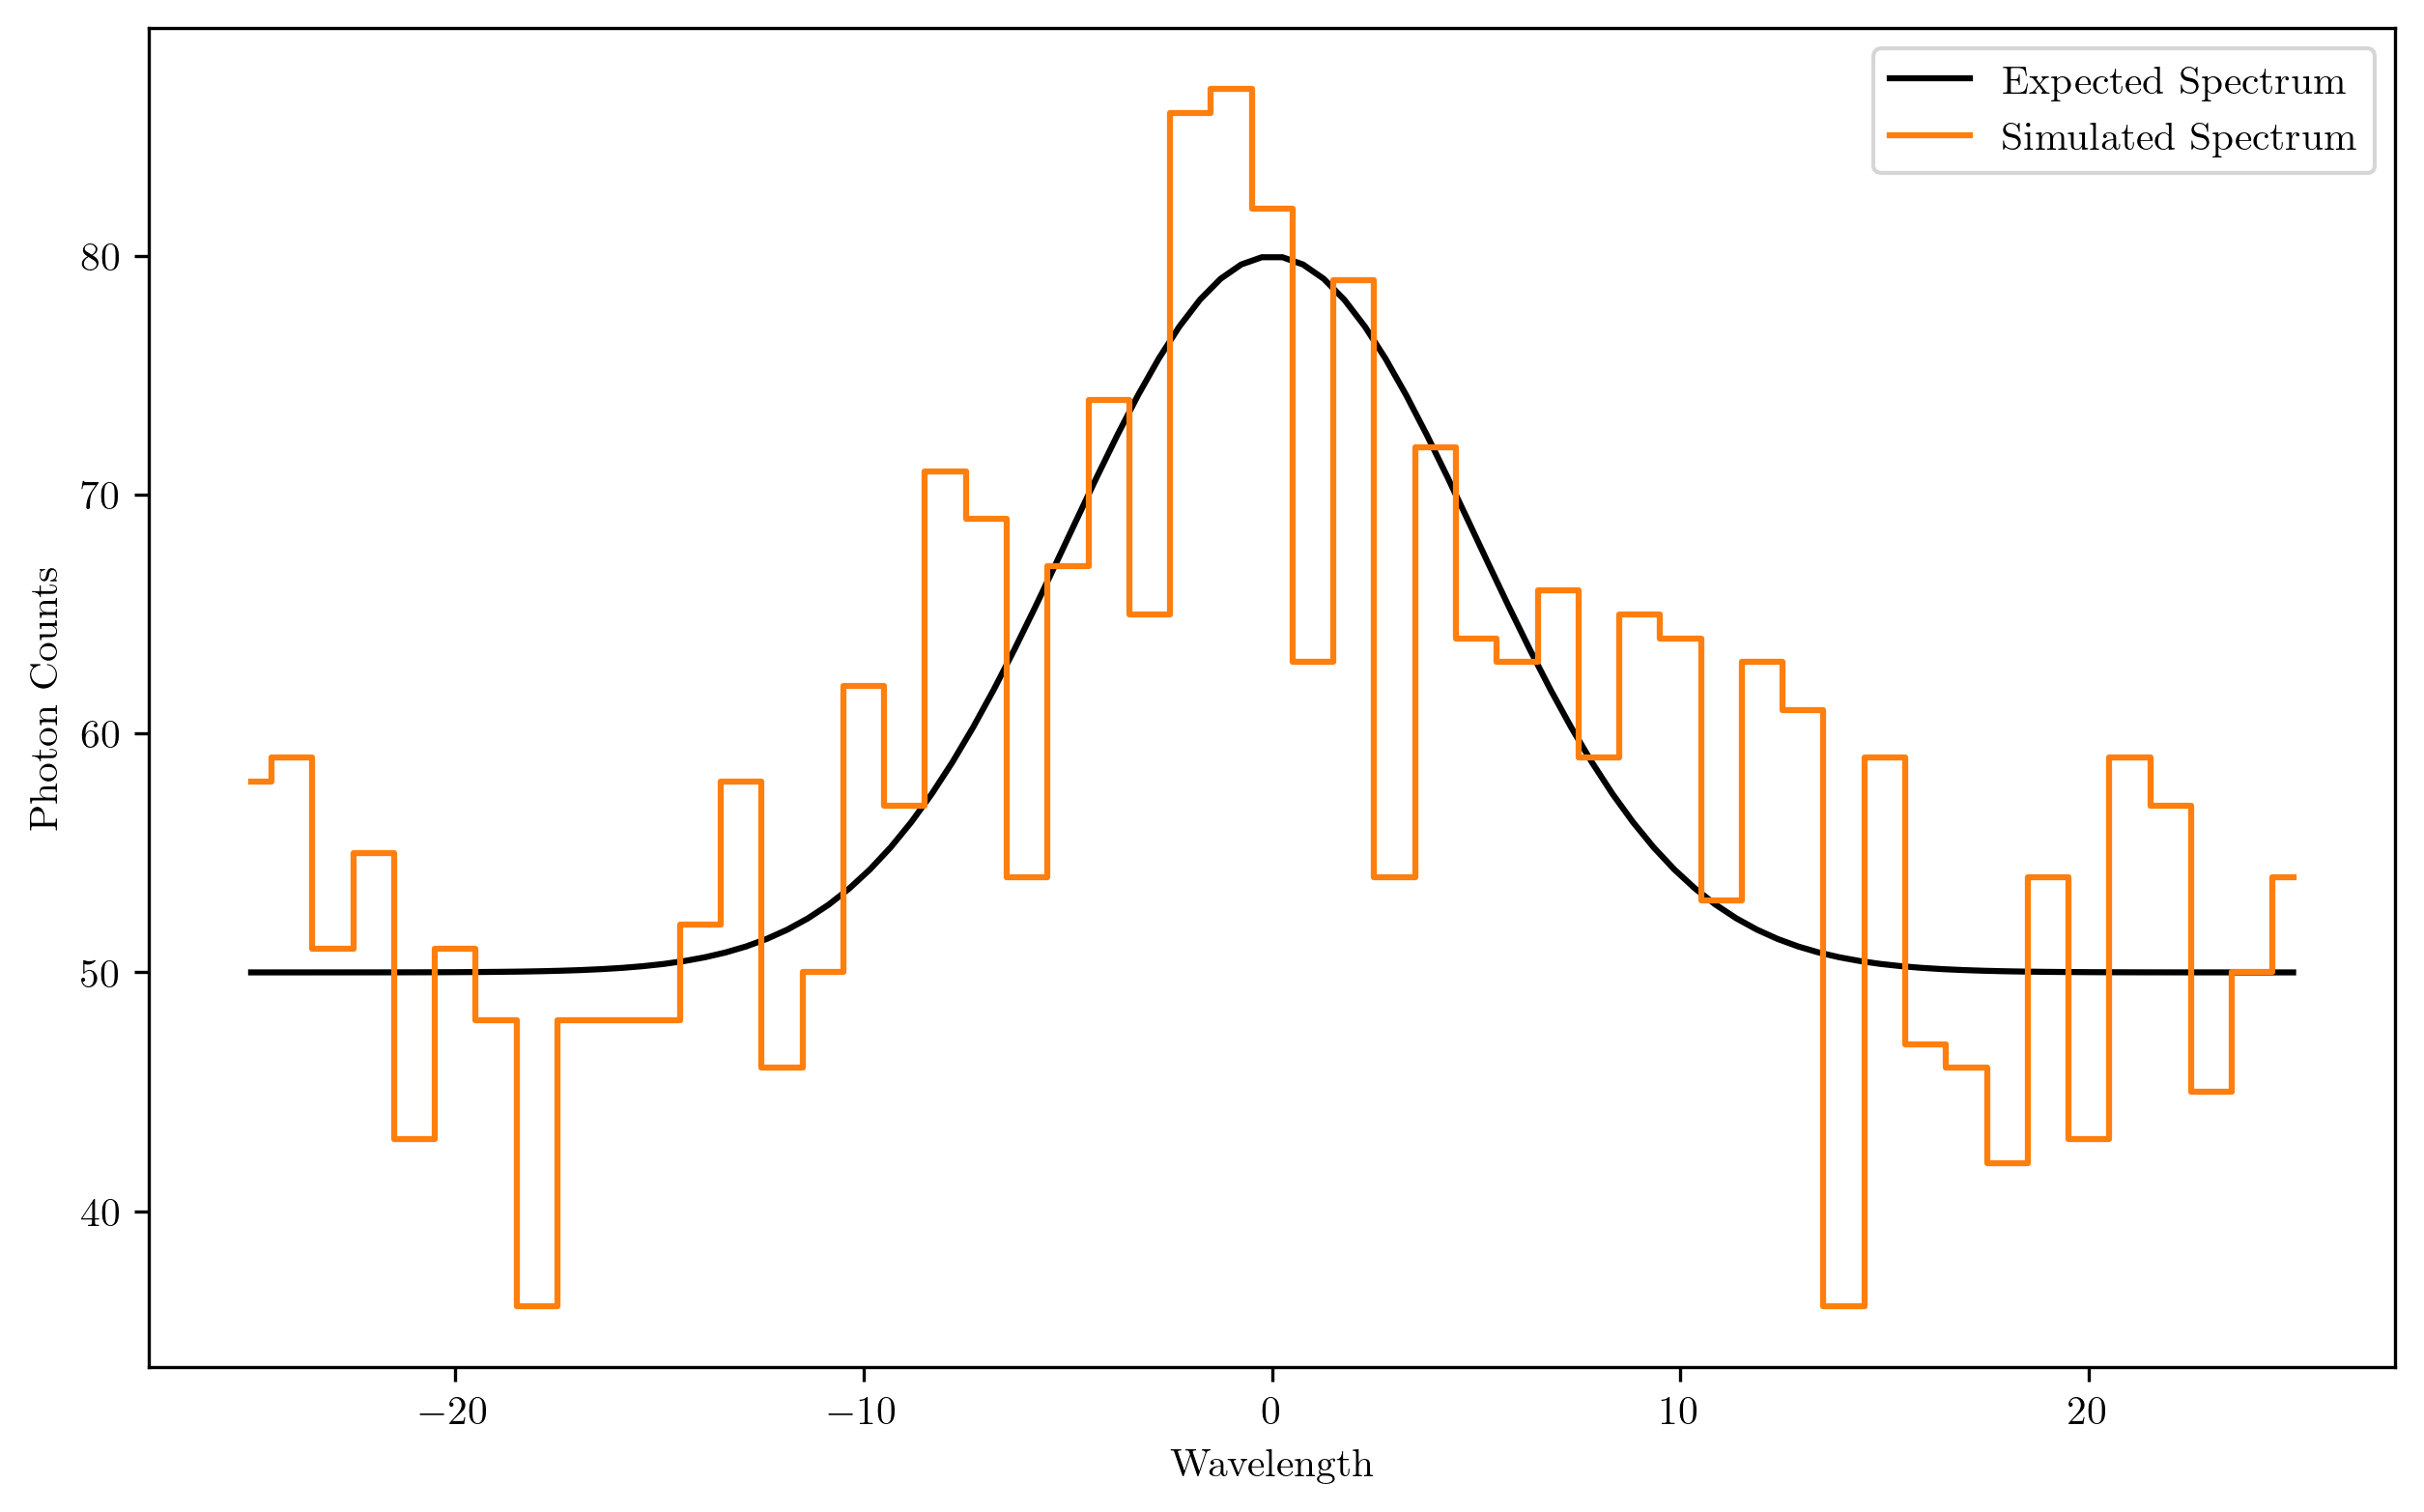

In [75]:
# Simulate the spectrum with a different seed
A2_true = 30
w2_true = 5
B2_true = 50
x, spec2 = sim_spec(A2_true, w2_true, B2_true, seed=seed+1)

# Compute the expected spectrum with true parameters for comparison
spec2_model = spec_model(x_model, A=A2_true, w=w2_true, B=B2_true)

# Plot the model and simulated spectrum
plt.figure(figsize=(10, 6))

# NOTE: EDIT below to plot the expected and simulated spectrum
plt.plot(x_model, spec2_model, label='Expected Spectrum', color='k')
plt.plot(x, spec2, drawstyle='steps-mid', label='Simulated Spectrum', color='tab:orange')
plt.xlabel('Wavelength')
plt.ylabel('Photon Counts')
plt.legend()
plt.show()

In [76]:
def spec_posterior_B_w(x, n_obs, A=30, x0=0, B_range=(10, 100), w_range=(1, 25), n_B=500, n_w=500):
    """Compute the posterior distribution of background B and width w given observed spectrum.
    Args:
        x: array-like, wavelengths
        n_obs: array-like, observed photon counts
        A: float, line amplitude (default: 50)
        x0: float, line center (default: 0)
        B_range: tuple, prior range of B values (default: (10, 100))
        w_range: tuple, prior range of w values (default: (1, 25))
        n_B: int, number of B samples (default: 500)
        n_w: int, number of w samples (default: 500)
    Returns:
        B_grid: 1D array, grid of B values
        w_grid: 1D array, grid of w values
        posterior: 2D array, joint posterior distribution of B and w
    """
    # Create prior grids
    B_grid = np.linspace(B_range[0], B_range[1], n_B)
    w_grid = np.linspace(w_range[0], w_range[1], n_w)
    dBdw = (B_range[1] - B_range[0]) / n_B * (w_range[1] - w_range[0]) / n_w
    B_grid, w_grid = np.meshgrid(B_grid, w_grid)

    n_model = spec_model(x, A, w_grid, B_grid, x0)
    # NOTE: EDIT below to compute the log-posterior
    eps = 1e-12
    # n_model has shape (len(x), n_w, n_B); sum log-likelihood over wavelength axis (axis=0)
    log_like = np.sum(-n_model + n_obs[:, None, None] * np.log(n_model + eps), axis=0)
    # scale-invariant prior: p(B,w) prop 1/(B w) -> log_prior = -log B - log w
    log_prior = -np.log(B_grid) - np.log(w_grid)
    log_post = log_prior + log_like
    posterior = np.exp(log_post - np.max(log_post))
    posterior /= np.sum(posterior) * dBdw  # Normalize posterior
    return B_grid, w_grid, posterior

In [77]:
B2_sample = 500
w2_sample = 500
B2_range = [B2_true * 0.2, B2_true * 5]
w2_range = [w2_true * 0.2, w2_true * 5]

B2_grid, w2_grid, posterior2 = spec_posterior_B_w(
    x, spec2, A=A2_true, x0=0, B_range=B2_range,
    w_range=w2_range, n_B=B2_sample, n_w=w2_sample
)

B2_vals, post_marg_B2, w2_vals, post_marg_w2 = marginalize_posterior(B2_grid, w2_grid, posterior2)

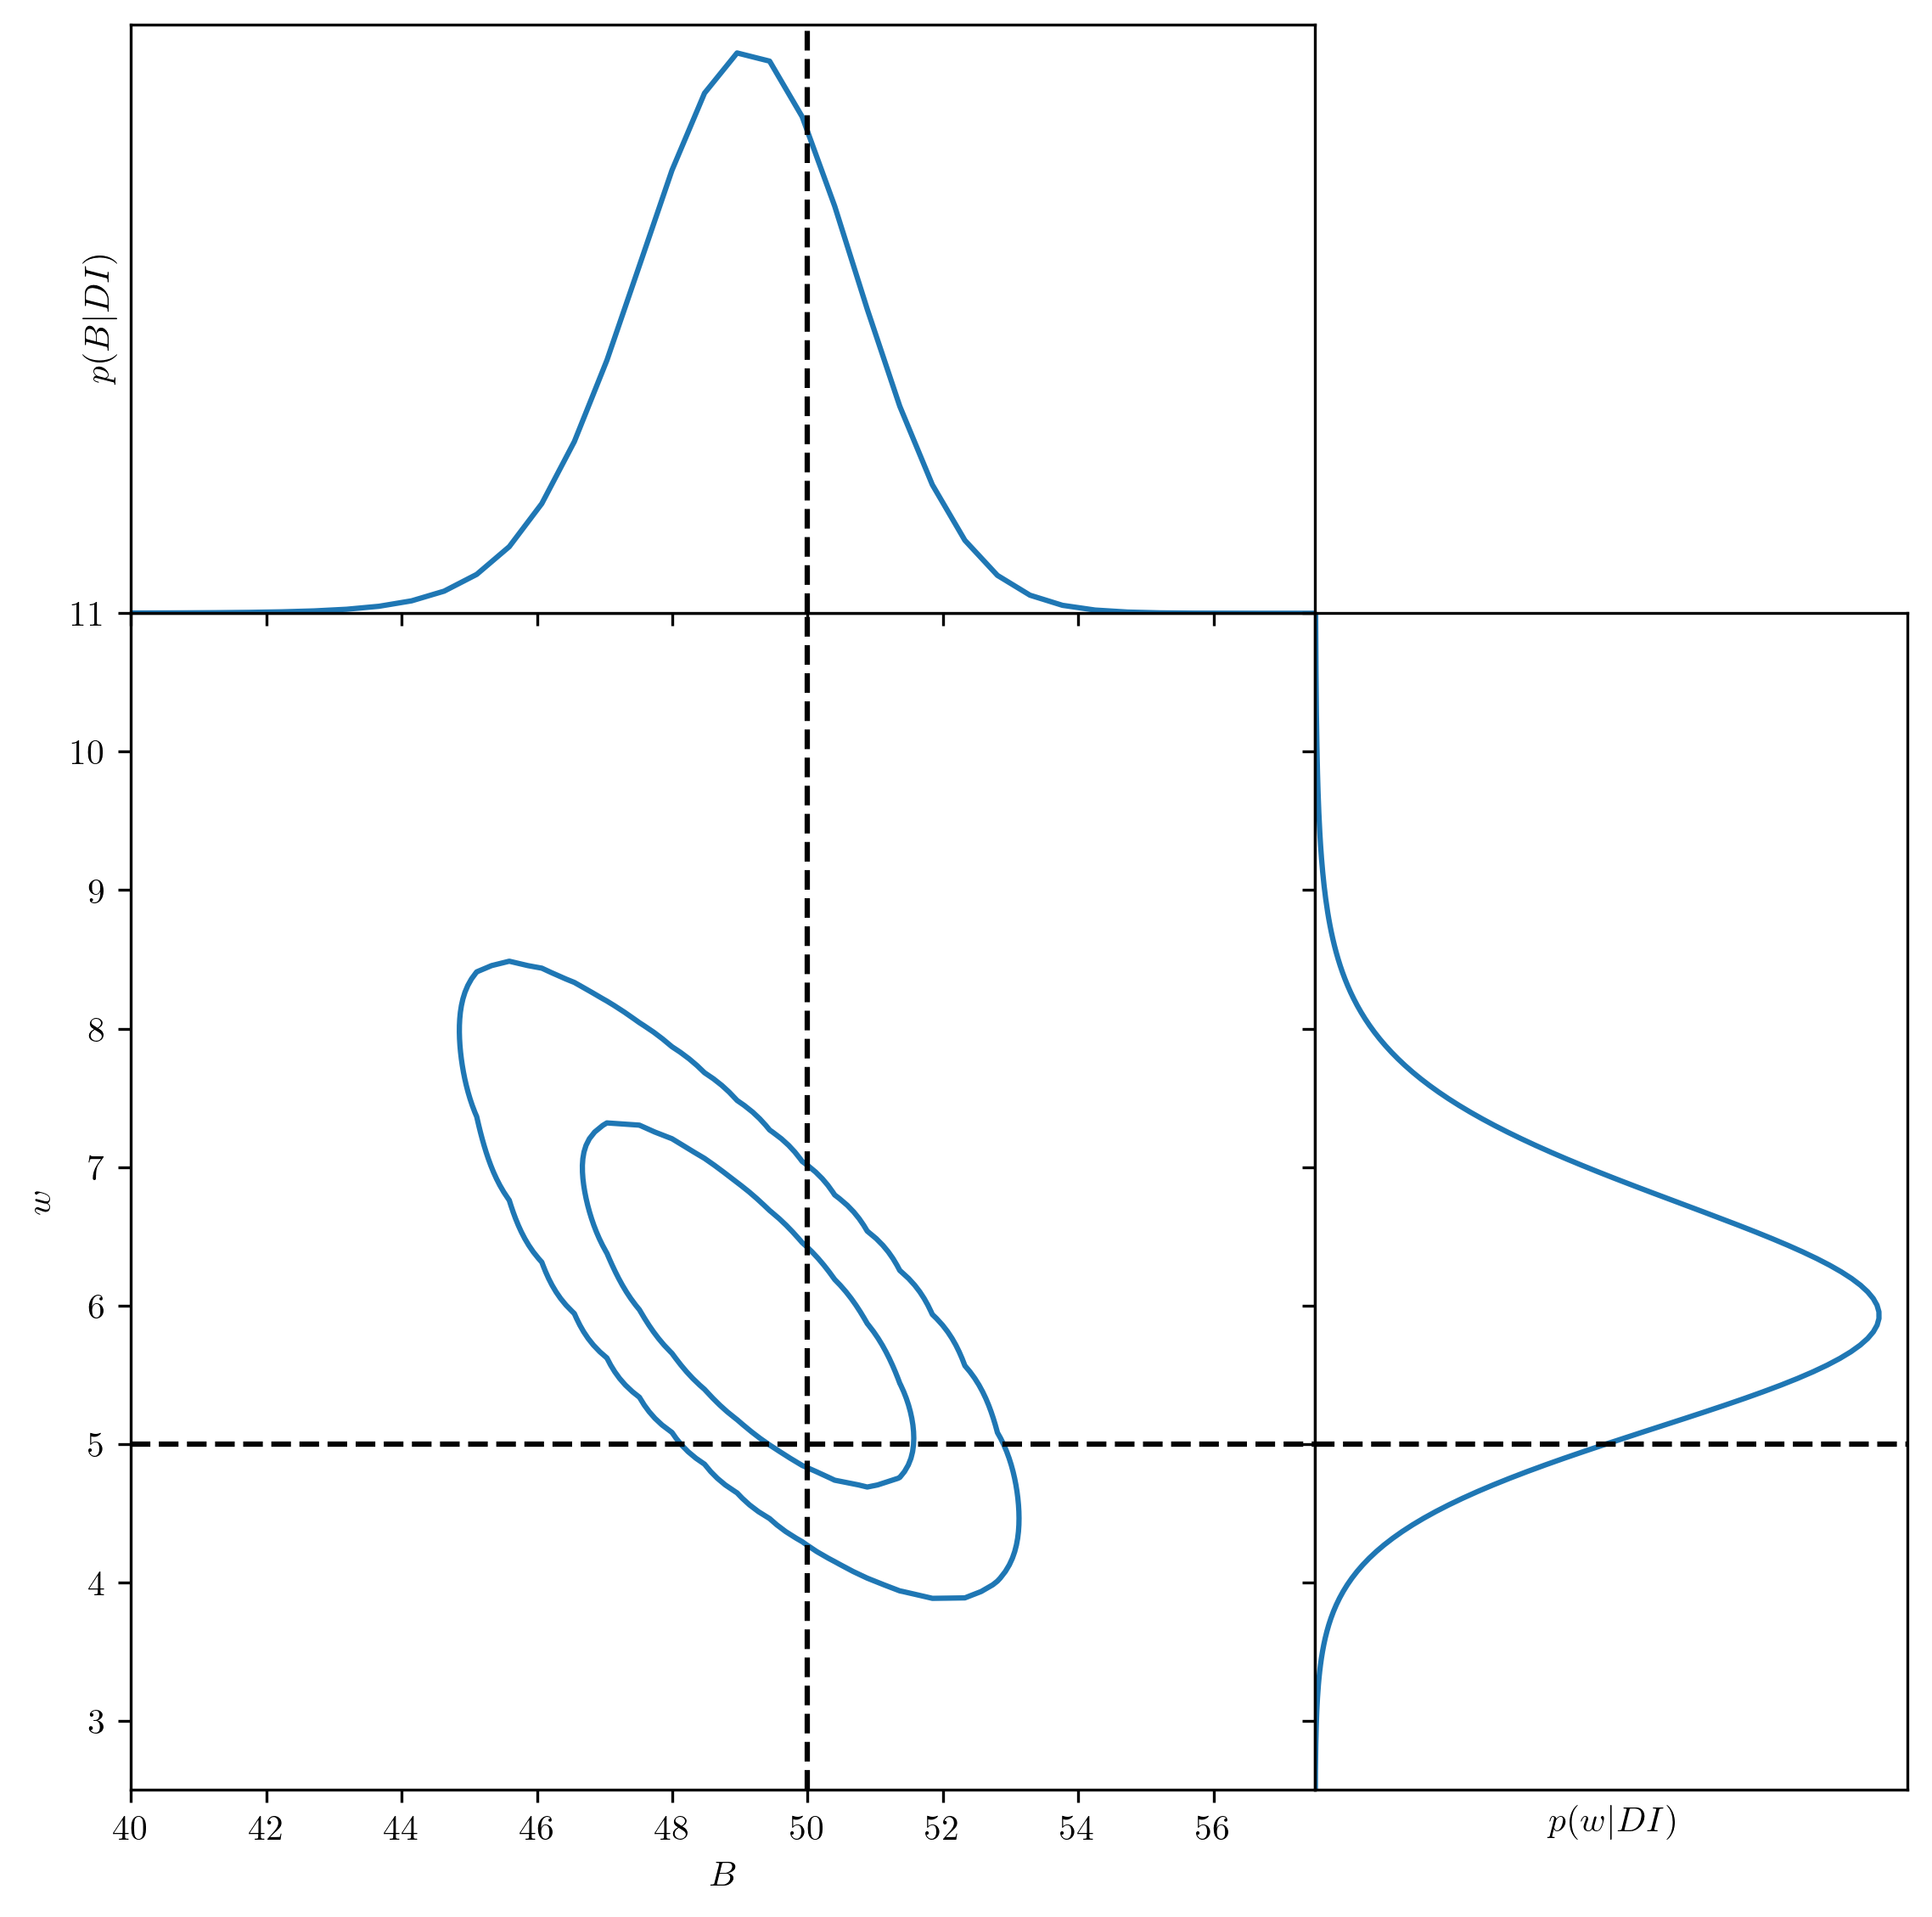

In [78]:
# Plot the posterior distribution and marginalized distributions
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# NOTE: EDIT below to plot the credible levels and marginalized distributions
plot_credible_levels(ax0, B2_grid, w2_grid, posterior2, colors='tab:blue')

ax1.plot(B2_vals, post_marg_B2, color='tab:blue')
ax2.plot(post_marg_w2, w2_vals, color='tab:blue')

ax0.axhline(w2_true, color='k', linestyle='--')
ax0.axvline(B2_true, color='k', linestyle='--')
ax1.axvline(B2_true, color='k', linestyle='--')
ax2.axhline(w2_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([B2_true - 10, B2_true + 7.5])
ax0.set_ylim([w2_true - 2.5, w2_true + 6])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$B$')
ax0.set_ylabel(r'$w$')
ax1.set_ylabel(r'$p(B | DI)$')
ax2.set_xlabel(r'$p(w | DI)$')
plt.show()

In [79]:
# NOTE: EDIT below to report the summary statistics of B and w
mean_B, std_B, p_B = summarize_marginal(B2_vals, post_marg_B2, percentiles=[16,50,84])
mean_w2, std_w2, p_w2 = summarize_marginal(w2_vals, post_marg_w2, percentiles=[16,50,84])

mean_B_joint, mean_w2_joint, cov_Bw = covariance_from_2d(B2_grid, w2_grid, posterior2)

print(f"B (marginal): mean = {mean_B:.4f}, std = {std_B:.4f}, 16-50-84 = {p_B}")
print(f"w (marginal): mean = {mean_w2:.4f}, std = {std_w2:.4f}, 16-50-84 = {p_w2}")
print("\nJoint posterior means from full 2D posterior:")
print(f" mean B = {mean_B_joint:.4f}, mean w = {mean_w2_joint:.4f}")
print("Covariance matrix (B, w):")
print(cov_Bw)

B (marginal): mean = 49.0174, std = 1.6906, 16-50-84 = [47.35793213 49.05905751 50.69416513]
w (marginal): mean = 6.0510, std = 0.9391, 16-50-84 = [5.15995403 6.00157165 6.92625238]

Joint posterior means from full 2D posterior:
 mean B = 49.0174, mean w = 6.0510
Covariance matrix (B, w):
[[ 2.85827194 -1.24509493]
 [-1.24509493  0.88191705]]


#### Question 1.3: derived parameters

The star formation rate $f$ and velocity dispersion $\sigma_v$ of the galaxy are related to the line parameters as follows:

$\begin{aligned}
f & = A_1 w_1 / 10 = B_2 / 2 \, [M_\odot \, \text{yr}^{-1}] \\
\sigma_v & = 10 w_1 = 10 w_2 \, [\text{km} \, \text{s}^{-1}] \\
\end{aligned}$

**Tasks:**
1. Compute the 2D and marginalized posterior distributions of $f$ and $\sigma_v$ based on the existing posterior results from Questions 1.1 and 1.2.
2. Reparametrizing the problem, infer $f$ and $\sigma_v$ directly from the observed spectra using scale-invariant priors $p(f,\sigma_v | I) \propto 1/(f \sigma_v)$ in the ranges $f \in [10, 50]$ and $\sigma_v \in [10, 100]$.
3. Compare the posterior distributions of $f$ and $\sigma_v$ obtained from the two methods above.
4. Compare the standard deviations of $f$ and $\sigma_v$ obtained from the two methods above and the error propagation results (under linear approximation) based on the individual parameter inferences from Questions 1.1 and 1.2.

**Hint:** Report the results from both lines separately, and check the consistency.

In [80]:
from scipy.interpolate import RegularGridInterpolator

# Helper functions to resample existing posterior distributions with parameter transformations
def resample_posterior_A_w(A_grid, w_grid, posterior, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500):
    """Resample the posterior from (A, w) to (f, sigma_v).
    Args:
        A_grid: numpy array, grid of A values
        w_grid: numpy array, grid of w values
        posterior: numpy array, joint posterior distribution of A and w
        f_range: list, prior range of f values (default: [10, 50])
        sigma_v_range: list, prior range of sigma_v values (default: [10, 100])
        n_f: int, number of f samples (default: 500)
        n_sigma_v: int, number of sigma_v samples (default: 500)
    Returns:
        f_grid: numpy array, grid of f values
        sigma_v_grid: numpy array, grid of sigma_v values
        posterior_reparam: numpy array, joint posterior distribution of f and sigma_v
    """
    # Create interpolator for the original posterior
    interp = RegularGridInterpolator((w_grid[:,0], A_grid[0]), posterior, bounds_error=False, fill_value=0)

    # Create new grids for f and sigma_v
    f_vals = np.linspace(f_range[0], f_range[1], n_f)
    sigma_v_vals = np.linspace(sigma_v_range[0], sigma_v_range[1], n_sigma_v)
    f_grid, sigma_v_grid = np.meshgrid(f_vals, sigma_v_vals)

    # Convert (f, sigma_v) to (A, w)
    A_new = f_grid * 100 / sigma_v_grid
    w_new = sigma_v_grid / 10

    # Evaluate the original posterior at the new (A, w) points
    points = np.array([w_new.ravel(), A_new.ravel()]).T
    posterior_interp = interp(points).reshape(f_grid.shape)

    # Apply Jacobian for change of variables
    posterior_reparam = posterior_interp / w_new

    # Renormalize the reparameterized posterior
    dfds = (f_range[1] - f_range[0]) / n_f * (sigma_v_range[1] - sigma_v_range[0]) / n_sigma_v
    posterior_reparam /= np.sum(posterior_reparam) * dfds

    return f_grid, sigma_v_grid, posterior_reparam

def resample_posterior_B_w(B_grid, w_grid, posterior, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500):
    """Resample the posterior from (B, w) to (f, sigma_v).
    Args:
        B_grid: numpy array, grid of B values
        w_grid: numpy array, grid of w values
        posterior: numpy array, joint posterior distribution of B and w
        f_range: list, prior range of f values (default: [10, 50])
        sigma_v_range: list, prior range of sigma_v values (default: [10, 100])
        n_f: int, number of f samples (default: 500)
        n_sigma_v: int, number of sigma_v samples (default: 500)
    Returns:
        f_grid: numpy array, grid of f values
        sigma_v_grid: numpy array, grid of sigma_v values
        posterior_reparam: numpy array, joint posterior distribution of f and sigma_v
    """
    # Create interpolator for the original posterior
    interp = RegularGridInterpolator((w_grid[:,0], B_grid[0]), posterior, bounds_error=False, fill_value=0)

    # Create new grids for f and sigma_v
    f_vals = np.linspace(f_range[0], f_range[1], n_f)
    sigma_v_vals = np.linspace(sigma_v_range[0], sigma_v_range[1], n_sigma_v)
    f_grid, sigma_v_grid = np.meshgrid(f_vals, sigma_v_vals)

    # Convert (f, sigma_v) to (B, w)
    B_new = f_grid * 2
    w_new = sigma_v_grid / 10

    # Evaluate the original posterior at the new (B, w) points
    points = np.array([w_new.ravel(), B_new.ravel()]).T
    posterior_interp = interp(points).reshape(f_grid.shape)

    # Apply Jacobian for change of variables:
    # B = 2 f  -> dB/df = 2
    # w = sigma_v / 10 -> dw/dsigma_v = 1/10
    # det = 2 * (1/10) = 0.2
    jacobian = 0.2
    posterior_reparam = posterior_interp * jacobian

    # Renormalize the reparameterized posterior
    dfds = (f_range[1] - f_range[0]) / n_f * (sigma_v_range[1] - sigma_v_range[0]) / n_sigma_v
    posterior_reparam /= np.sum(posterior_reparam) * dfds

    return f_grid, sigma_v_grid, posterior_reparam

In [81]:
def spec_posterior_fs_1(x, n_obs, B=50, x0=0, f_range=(10, 50), sigma_v_range=(10, 100), n_f=500, n_sigma_v=500):
    """Compute the posterior distribution of flux f and velocity dispersion sigma_v given observed spectrum.
    Args:
        x: array-like, wavelengths
        n_obs: array-like, observed photon counts
        B: float, background level (default: 50)
        x0: float, line center (default: 0)
        f_range: tuple, prior range of f values (default: (10, 50))
        sigma_v_range: tuple, prior range of sigma_v values (default: (10, 100))
        n_f: int, number of f samples (default: 500)
        n_sigma_v: int, number of sigma_v samples (default: 500)
    Returns:
        f_grid: numpy array, grid of f values
        sigma_v_grid: numpy array, grid of sigma_v values
        posterior: numpy array, joint posterior distribution of f and sigma_v
    """
    # Create grids for f and sigma_v
    f_grid = np.linspace(f_range[0], f_range[1], n_f)
    sigma_v_grid = np.linspace(sigma_v_range[0], sigma_v_range[1], n_sigma_v)
    dfds = (f_range[1] - f_range[0]) / n_f * (sigma_v_range[1] - sigma_v_range[0]) / n_sigma_v
    f_grid, sigma_v_grid = np.meshgrid(f_grid, sigma_v_grid)

    # NOTE: EDIT below to compute the joint posterior distribution
    A_grid = f_grid * 100 / sigma_v_grid
    w_grid = sigma_v_grid / 10
    n_model = spec_model(x, A_grid, w_grid, B, x0)
    eps = 1e-12
    # n_model has shape (len(x), n_w, n_A); sum log-likelihood over wavelength axis (axis=0)
    log_like = np.sum(-n_model + n_obs[:, None, None] * np.log(n_model + eps), axis=0)
    # scale-invariant prior: p(A,w) prop 1/(A w) -> log_prior = -log A - log w
    log_prior = -np.log(A_grid) - np.log(w_grid)
    log_post = log_prior + log_like
    posterior = np.exp(log_post - np.max(log_post))
    posterior /= np.sum(posterior) * dfds  # Normalize posterior

    return f_grid, sigma_v_grid, posterior

def spec_posterior_fs_2(x, n_obs, A=30, x0=0, f_range=(10, 50), sigma_v_range=(10, 100), n_f=500, n_sigma_v=500):
    """Compute the posterior distribution of flux f and velocity dispersion sigma_v given observed spectrum.
    Args:
        x: array-like, wavelengths
        n_obs: array-like, observed photon counts
        A: float, line amplitude (default: 30)
        x0: float, line center (default: 0)
        f_range: tuple, prior range of f values (default: (10, 50))
        sigma_v_range: tuple, prior range of sigma_v values (default: (10, 100))
        n_f: int, number of f samples (default: 500)
        n_sigma_v: int, number of sigma_v samples (default: 500)
    Returns:
        f_grid: numpy array, grid of f values
        sigma_v_grid: numpy array, grid of sigma_v values
        posterior: numpy array, joint posterior distribution of f and sigma_v
    """
    # NOTE: EDIT below to complete the function
    # Create grids for f and sigma_v
    f_grid = np.linspace(f_range[0], f_range[1], n_f)
    sigma_v_grid = np.linspace(sigma_v_range[0], sigma_v_range[1], n_sigma_v)
    dfds = (f_range[1] - f_range[0]) / n_f * (sigma_v_range[1] - sigma_v_range[0]) / n_sigma_v
    f_grid, sigma_v_grid = np.meshgrid(f_grid, sigma_v_grid)

    # NOTE: EDIT below to compute the joint posterior distribution
    B_grid = f_grid * 2
    w_grid = sigma_v_grid / 10
    n_model = spec_model(x, A, w_grid, B_grid, x0)
    eps = 1e-12
    # n_model has shape (len(x), n_w, n_B); sum log-likelihood over wavelength axis (axis=0)
    log_like = np.sum(-n_model + n_obs[:, None, None] * np.log(n_model + eps), axis=0)
    # scale-invariant prior: p(B,w) prop 1/(B w) -> log_prior = -log B - log w
    log_prior = -np.log(B_grid) - np.log(w_grid)
    log_post = log_prior + log_like
    posterior = np.exp(log_post - np.max(log_post))
    posterior /= np.sum(posterior) * dfds  # Normalize posterior

    return f_grid, sigma_v_grid, posterior

In [82]:
# Resampled posteriors from first spectrum
f_grid_resample, sigma_v_grid_resample, posterior_fs1_resample = resample_posterior_A_w(A1_grid, w1_grid, posterior1, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500)

f_vals_resample, post_marg_f1_resample, sigma_v_vals_resample, post_marg_sigma_v1_resample = marginalize_posterior(f_grid_resample, sigma_v_grid_resample, posterior_fs1_resample)

# Resampled posteriors from second spectrum
f_grid_resample, sigma_v_grid_resample, posterior_fs2_resample = resample_posterior_B_w(B2_grid, w2_grid, posterior2, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500)

f_vals_resample, post_marg_f2_resample, sigma_v_vals_resample, post_marg_sigma_v2_resample = marginalize_posterior(f_grid_resample, sigma_v_grid_resample, posterior_fs2_resample)

In [83]:
# Refitted posteriors from the first spectrum
f_grid_refit, sigma_v_grid_refit, posterior_fs1_refit = spec_posterior_fs_1(x, spec1, B=B1_true, x0=0, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500)

f_vals_refit, post_marg_f1_refit, sigma_v_vals_refit, post_marg_sigma_v1_refit = marginalize_posterior(f_grid_refit, sigma_v_grid_refit, posterior_fs1_refit)

# Refitted posteriors from the second spectrum
f_grid_refit, sigma_v_grid_refit, posterior_fs2_refit = spec_posterior_fs_2(x, spec2, A=A2_true, x0=0, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500)

f_vals_refit, post_marg_f2_refit, sigma_v_vals_refit, post_marg_sigma_v2_refit = marginalize_posterior(f_grid_refit, sigma_v_grid_refit, posterior_fs2_refit)

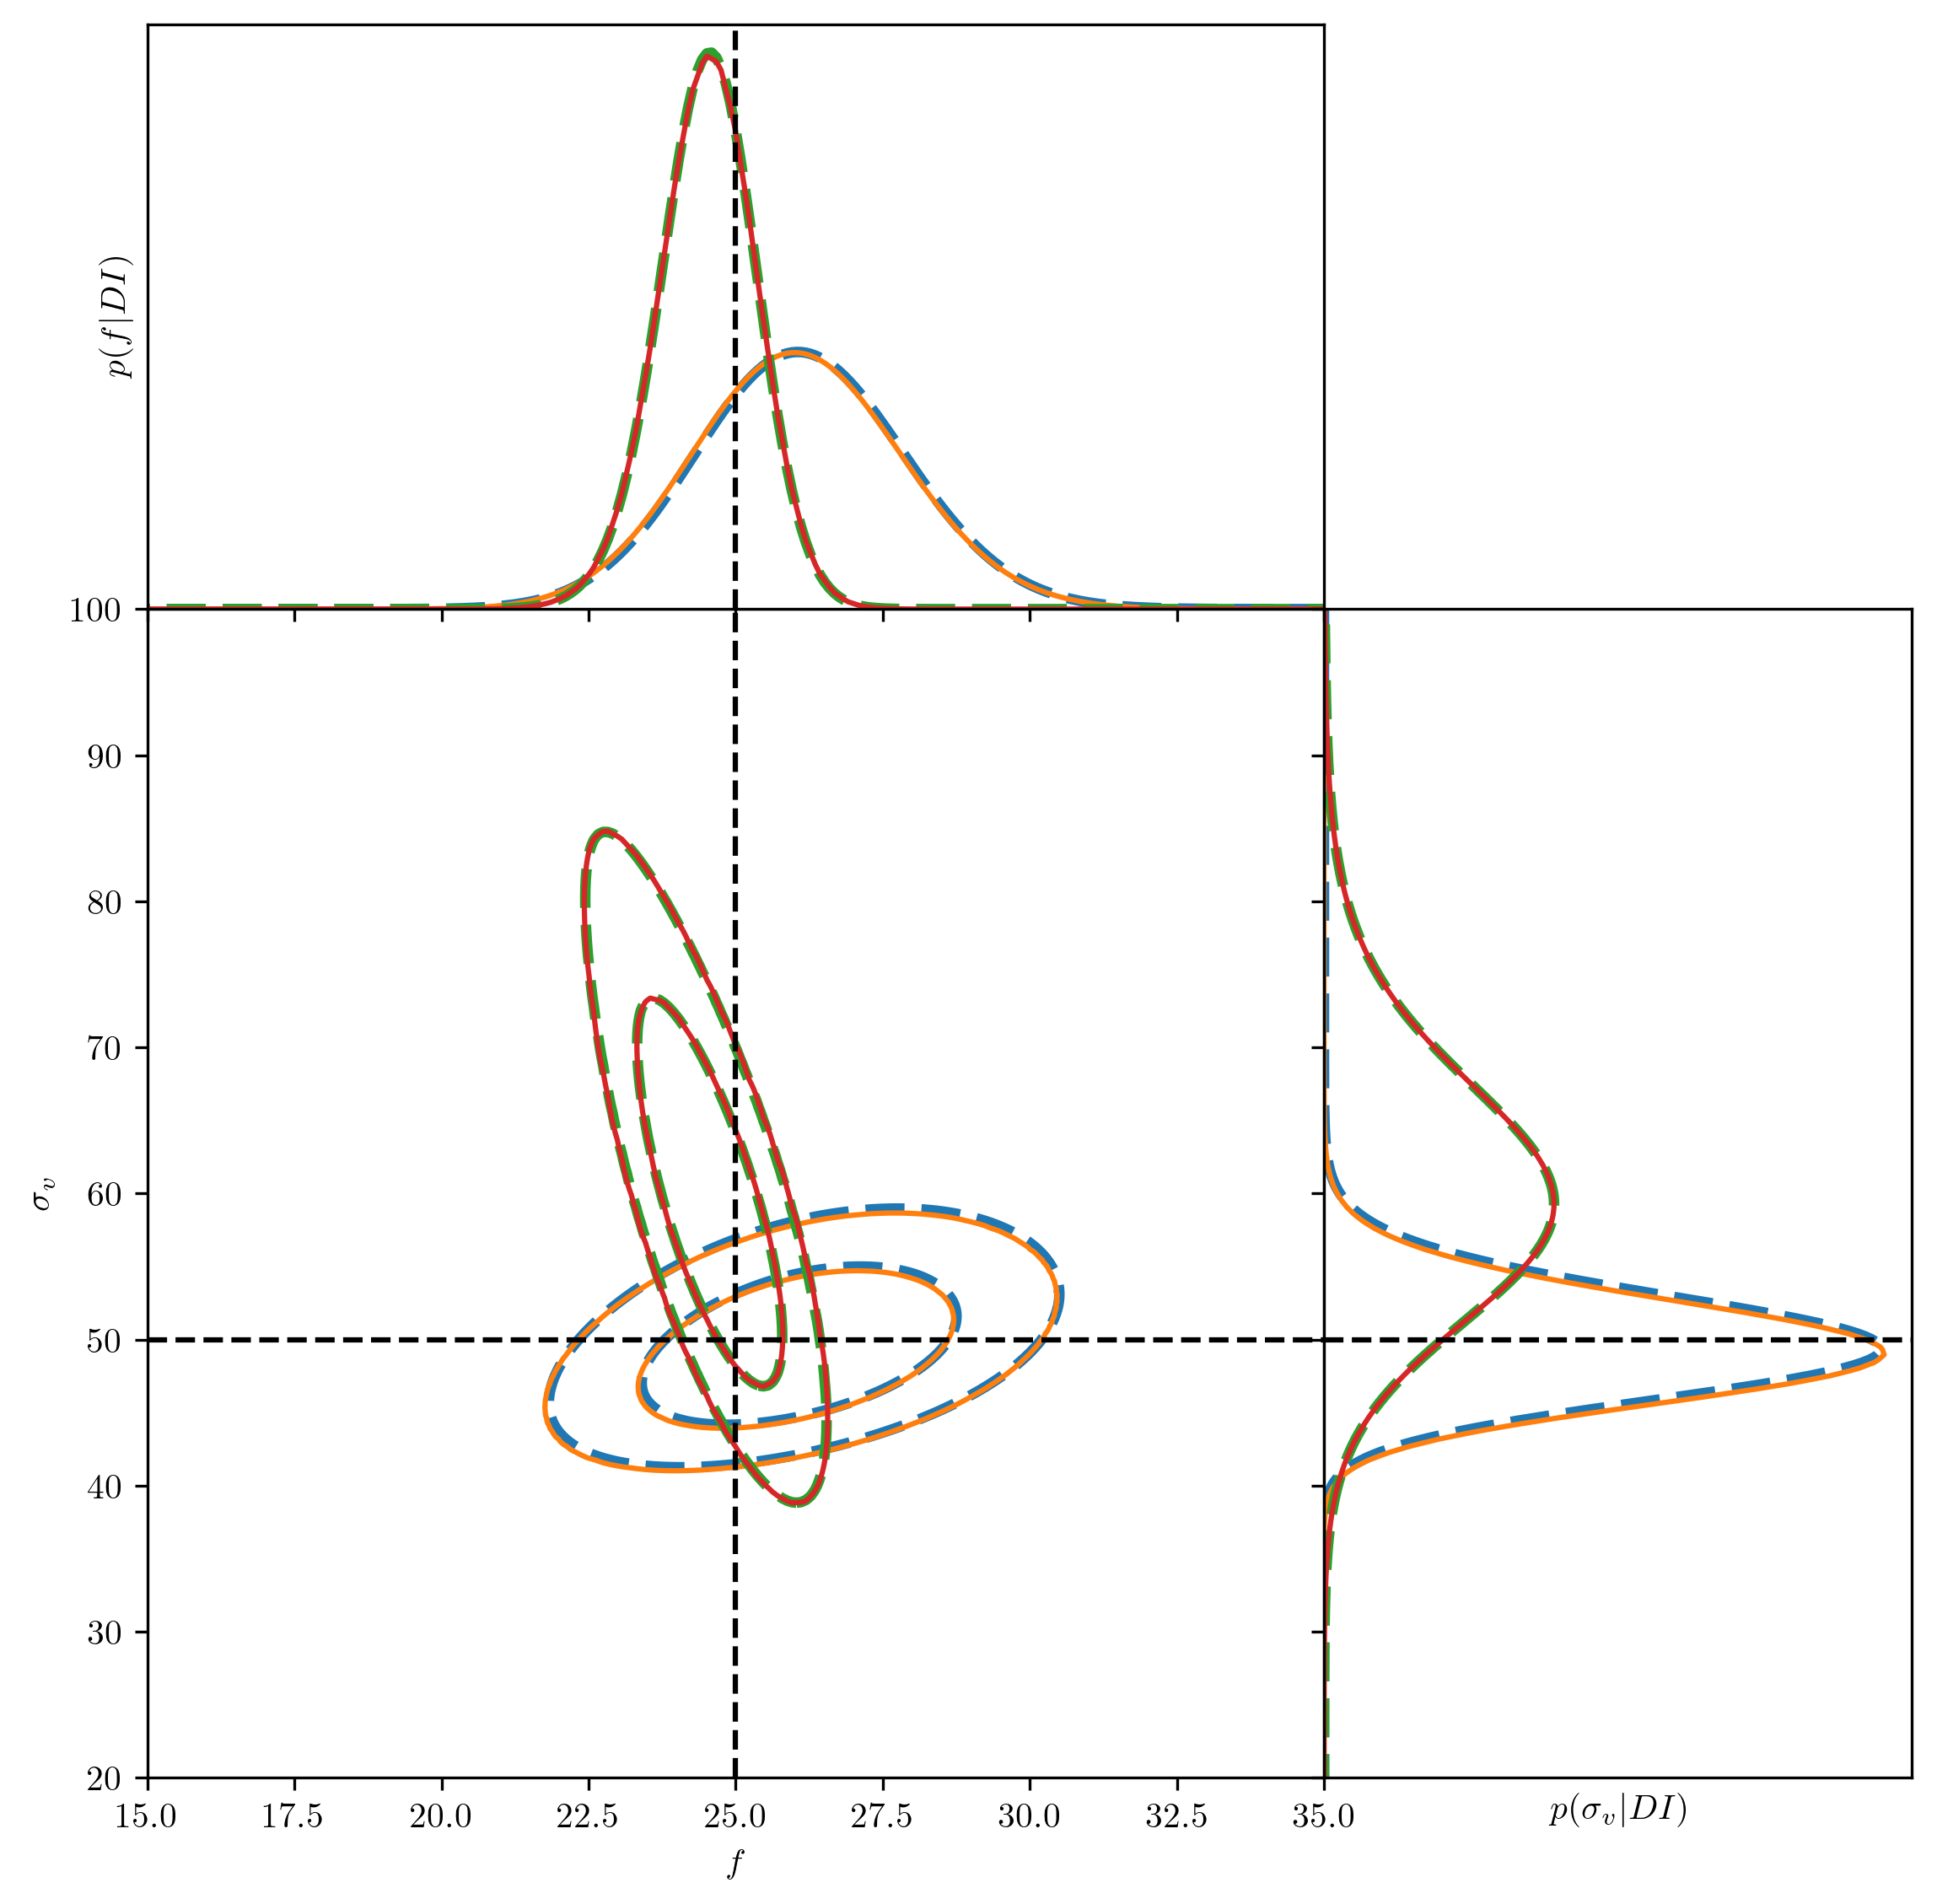

In [84]:
f_true = 25
sigma_v_true = 50

plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# Refitted posteriors from the first spectrum
plot_credible_levels(ax0, f_grid_refit, sigma_v_grid_refit, posterior_fs1_refit, colors='tab:blue', linewidths=3, linestyles='--')
ax1.plot(f_vals_refit, post_marg_f1_refit, color='tab:blue', linewidth=3, linestyle='--')
ax2.plot(post_marg_sigma_v1_refit, sigma_v_vals_refit, color='tab:blue', linewidth=3, linestyle='--')

# Resampled posteriors from the first spectrum
plot_credible_levels(ax0, f_grid_resample, sigma_v_grid_resample, posterior_fs1_resample, colors='tab:orange')
ax1.plot(f_vals_resample, post_marg_f1_resample, color='tab:orange')
ax2.plot(post_marg_sigma_v1_resample, sigma_v_vals_resample, color='tab:orange')

# Refitted posteriors from the second spectrum
plot_credible_levels(ax0, f_grid_refit, sigma_v_grid_refit, posterior_fs2_refit, colors='tab:green', linewidths=3, linestyles='--')
ax1.plot(f_vals_refit, post_marg_f2_refit, color='tab:green', linewidth=3, linestyle='--')
ax2.plot(post_marg_sigma_v2_refit, sigma_v_vals_refit, color='tab:green', linewidth=3, linestyle='--')

# Resampled posteriors from the second spectrum
plot_credible_levels(ax0, f_grid_resample, sigma_v_grid_resample, posterior_fs2_resample, colors='tab:red')
ax1.plot(f_vals_resample, post_marg_f2_resample, color='tab:red')
ax2.plot(post_marg_sigma_v2_resample, sigma_v_vals_resample, color='tab:red')

ax0.axhline(sigma_v_true, color='k', linestyle='--')
ax0.axvline(f_true, color='k', linestyle='--')
ax1.axvline(f_true, color='k', linestyle='--')
ax2.axhline(sigma_v_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([f_true - 10, f_true + 10])
ax0.set_ylim([sigma_v_true - 30, sigma_v_true + 50])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$f$')
ax0.set_ylabel(r'$\sigma_v$')
ax1.set_ylabel(r'$p(f | DI)$')
ax2.set_xlabel(r'$p(\sigma_v | DI)$')
plt.show()

In [85]:
# Compute propagated errors under linear approximation and compare to marginalized posterior results

# Propagation for first line: f1 = A1 * w1 / 10, sigma_v1 = 10 * w1
var_A = std_A**2
var_w = std_w**2
cov_A_w = cov_Aw[0,1]

# derivatives
# df/dA = w/10, df/dw = A/10  -> evaluate at means from joint posterior (use joint means from covariance_from_2d)
A_mean_joint = mean_A_joint
w_mean_joint = mean_w_joint

df_dA = w_mean_joint / 10.0
df_dw = A_mean_joint / 10.0

var_f1_prop = df_dA**2 * var_A + df_dw**2 * var_w + 2 * df_dA * df_dw * cov_A_w
std_f1_prop = np.sqrt(var_f1_prop)

std_sigma1_prop = 10.0 * std_w  # sigma_v1 = 10 * w1

# Propagation for second line: f2 = B2 / 2, sigma_v2 = 10 * w2
var_B = std_B**2
var_w2 = std_w2**2
cov_B_w2 = cov_Bw[0,1]

std_f2_prop = 0.5 * std_B
std_sigma2_prop = 10.0 * std_w2

# Summarize marginalized posteriors (resample and refit results)
mean_f1_res, std_f1_res, pct_f1_res = summarize_marginal(f_vals_resample, post_marg_f1_resample)
mean_sigma1_res, std_sigma1_res, pct_sigma1_res = summarize_marginal(sigma_v_vals_resample, post_marg_sigma_v1_resample)

mean_f1_ref, std_f1_ref, pct_f1_ref = summarize_marginal(f_vals_refit, post_marg_f1_refit)
mean_sigma1_ref, std_sigma1_ref, pct_sigma1_ref = summarize_marginal(sigma_v_vals_refit, post_marg_sigma_v1_refit)

mean_f2_res, std_f2_res, pct_f2_res = summarize_marginal(f_vals_resample, post_marg_f2_resample)
mean_sigma2_res, std_sigma2_res, pct_sigma2_res = summarize_marginal(sigma_v_vals_resample, post_marg_sigma_v2_resample)

mean_f2_ref, std_f2_ref, pct_f2_ref = summarize_marginal(f_vals_refit, post_marg_f2_refit)
mean_sigma2_ref, std_sigma2_ref, pct_sigma2_ref = summarize_marginal(sigma_v_vals_refit, post_marg_sigma_v2_refit)

# Print comparisons
print("Line 1 (from A1,w1):")
print(f" Propagated std(f)    = {std_f1_prop:.4f}")
print(f" Resample  std(f)     = {std_f1_res:.4f}")
print(f" Refit     std(f)     = {std_f1_ref:.4f}")
print(f" Propagated std(sigma)= {std_sigma1_prop:.4f}")
print(f" Resample  std(sigma) = {std_sigma1_res:.4f}")
print(f" Refit     std(sigma) = {std_sigma1_ref:.4f}")
print()

print("Line 2 (from B2,w2):")
print(f" Propagated std(f)    = {std_f2_prop:.4f}")
print(f" Resample  std(f)     = {std_f2_res:.4f}")
print(f" Refit     std(f)     = {std_f2_ref:.4f}")
print(f" Propagated std(sigma)= {std_sigma2_prop:.4f}")
print(f" Resample  std(sigma) = {std_sigma2_res:.4f}")
print(f" Refit     std(sigma) = {std_sigma2_ref:.4f}")
print()

# Relative differences (percent)
def pct_diff(a, b):
    return 100.0 * (a - b) / b if b != 0 else np.nan

print("Relative differences (propagated vs resample or refit) [%]:")
print(f" Line1 f:  (prop-resample) = {pct_diff(std_f1_prop, std_f1_res):+.2f}%, (prop-refit) = {pct_diff(std_f1_prop, std_f1_ref):+.2f}%")
print(f" Line1 sigma: (prop-resample) = {pct_diff(std_sigma1_prop, std_sigma1_res):+.2f}%, (prop-refit) = {pct_diff(std_sigma1_prop, std_sigma1_ref):+.2f}%")
print(f" Line2 f:  (prop-resample) = {pct_diff(std_f2_prop, std_f2_res):+.2f}%, (prop-refit) = {pct_diff(std_f2_prop, std_f2_ref):+.2f}%")
print(f" Line2 sigma: (prop-resample) = {pct_diff(std_sigma2_prop, std_sigma2_res):+.2f}%, (prop-refit) = {pct_diff(std_sigma2_prop, std_sigma2_ref):+.2f}%")

Line 1 (from A1,w1):
 Propagated std(f)    = 1.7805
 Resample  std(f)     = 1.7741
 Refit     std(f)     = 1.7697
 Propagated std(sigma)= 3.6037
 Resample  std(sigma) = 3.6090
 Refit     std(sigma) = 3.6257

Line 2 (from B2,w2):
 Propagated std(f)    = 0.8453
 Resample  std(f)     = 0.8414
 Refit     std(f)     = 0.8354
 Propagated std(sigma)= 9.3910
 Resample  std(sigma) = 9.1982
 Refit     std(sigma) = 9.1962

Relative differences (propagated vs resample or refit) [%]:
 Line1 f:  (prop-resample) = +0.36%, (prop-refit) = +0.61%
 Line1 sigma: (prop-resample) = -0.15%, (prop-refit) = -0.61%
 Line2 f:  (prop-resample) = +0.47%, (prop-refit) = +1.19%
 Line2 sigma: (prop-resample) = +2.10%, (prop-refit) = +2.12%


#### Question 1.4: joint constraints

**Tasks:**
1. Combine the observed spectra from Questions 1.1 and 1.2 to jointly infer $f$ and $\sigma_v$ in two ways:
    - Directly inferring $f$ and $\sigma_v$ from the combined observed spectra at once using scale-invariant priors $p(f,\sigma_v|I) \propto 1/(f \sigma_v)$ in the ranges $f \in [10, 50]$ and $\sigma_v \in [10, 100]$.
    - Using the posterior distributions of $f, \sigma_v$ from the reparameterized results in Question 1.3.
2. Compare the posterior distributions of $f$ and $\sigma_v$ obtained from the two methods above.

In [86]:
def joint_posterior_resample(f_grid, sigma_v_grid, posterior1, posterior2):
    """Compute the joint posterior distribution from two independent posteriors.
    Args:
        f_grid: numpy array, grid of f values
        sigma_v_grid: numpy array, grid of sigma_v values
        posterior1: numpy array, first joint posterior distribution
        posterior2: numpy array, second joint posterior distribution
    Returns:
        posterior_joint: numpy array, joint posterior distribution
    """
    # Multiply two independent posteriors pointwise and renormalize.
    posterior_joint = np.asarray(posterior1, dtype=float) * np.asarray(posterior2, dtype=float)

    if posterior_joint.shape != posterior1.shape or posterior_joint.shape != posterior2.shape:
        raise ValueError("posterior1 and posterior2 must have the same shape as the provided grids.")

    # Extract 1D coordinate arrays from the meshgrids
    f_vals = f_grid[0]       # shape (n_f,)
    sigma_vals = sigma_v_grid[:, 0]  # shape (n_sigma_v,)

    # Estimate grid cell area (assumes regular grid)
    df = np.mean(np.diff(f_vals))
    ds = np.mean(np.diff(sigma_vals))
    cell_area = df * ds

    # Normalize the joint posterior to be a proper PDF over the grid
    Z = np.sum(posterior_joint) * cell_area
    if Z <= 0:
        raise ValueError("Joint posterior integrates to zero or negative; check inputs.")
    posterior_joint /= Z
    return posterior_joint

def joint_posterior_refit(x, n_obs1, n_obs2, x0=0, f_range=(10, 50), sigma_v_range=(10, 100), n_f=500, n_sigma_v=500):
    """Compute the joint posterior distribution from two independent spectra by refitting.
    Args:
        x: array-like, wavelengths
        n_obs1: array-like, observed photon counts from first spectrum
        n_obs2: array-like, observed photon counts from second spectrum
        x0: float, line center (default: 0)
        f_range: tuple, prior range of f values (default: (10, 50))
        sigma_v_range: tuple, prior range of sigma_v values (default: (10, 100))
        n_f: int, number of f samples (default: 500)
        n_sigma_v: int, number of sigma_v samples (default: 500)
    Returns:
        f_grid: numpy array, grid of f values
        sigma_v_grid: numpy array, grid of sigma_v values
        posterior_joint: numpy array, joint posterior distribution
    """
    # Create grids for f and sigma_v
    f_grid = np.linspace(f_range[0], f_range[1], n_f)
    sigma_v_grid = np.linspace(sigma_v_range[0], sigma_v_range[1], n_sigma_v)
    dfds = (f_range[1] - f_range[0]) / n_f * (sigma_v_range[1] - sigma_v_range[0]) / n_sigma_v
    f_grid, sigma_v_grid = np.meshgrid(f_grid, sigma_v_grid)

    # NOTE: EDIT below to compute the joint posterior distribution
    # Map (f, sigma_v) -> (A1, w1) for first spectrum and -> (B2, w2) for second spectrum
    A1_grid = f_grid * 100.0 / sigma_v_grid   # A1 = 100 * f / sigma_v
    w1_grid = sigma_v_grid / 10.0             # w1 = sigma_v / 10
    B2_grid = f_grid * 2.0                    # B2 = 2 * f
    w2_grid = sigma_v_grid / 10.0             # w2 = sigma_v / 10

    # Compute model predictions for both spectra
    n_model1 = spec_model(x, A1_grid, w1_grid, B1_true, x0)
    n_model2 = spec_model(x, A2_true, w2_grid, B2_grid, x0)

    # Log-likelihoods (Poisson) summed over wavelength bins for each spectrum
    eps = 1e-12
    log_like1 = np.sum(-n_model1 + n_obs1[:, None, None] * np.log(n_model1 + eps), axis=0)
    log_like2 = np.sum(-n_model2 + n_obs2[:, None, None] * np.log(n_model2 + eps), axis=0)
    log_like = log_like1 + log_like2

    # Scale-invariant prior in (f, sigma_v): p(f,sigma_v) ∝ 1/(f * sigma_v)
    log_prior = -np.log(f_grid + eps) - np.log(sigma_v_grid + eps)

    # Posterior (up to normalization)
    log_post = log_prior + log_like
    posterior_joint = np.exp(log_post - np.max(log_post))
    posterior_joint /= np.sum(posterior_joint) * dfds  # Normalize posterior
    
    return f_grid, sigma_v_grid, posterior_joint

In [87]:
combined_posterior_resample = joint_posterior_resample(f_grid_resample, sigma_v_grid_resample, posterior_fs1_resample, posterior_fs2_resample)

f_vals_combined_resample, post_marg_f_combined_resample, sigma_v_vals_combined_resample, post_marg_sigma_v_combined_resample = marginalize_posterior(f_grid_resample, sigma_v_grid_resample, combined_posterior_resample)

combined_f_grid_refit, combined_sigma_v_grid_refit, combined_posterior_refit = joint_posterior_refit(x, spec1, spec2, x0=0, f_range=(10, 50), sigma_v_range=(10, 100), n_f=500, n_sigma_v=500)

f_vals_combined_refit, post_marg_f_combined_refit, sigma_v_vals_combined_refit, post_marg_sigma_v_combined_refit = marginalize_posterior(combined_f_grid_refit, combined_sigma_v_grid_refit, combined_posterior_refit)

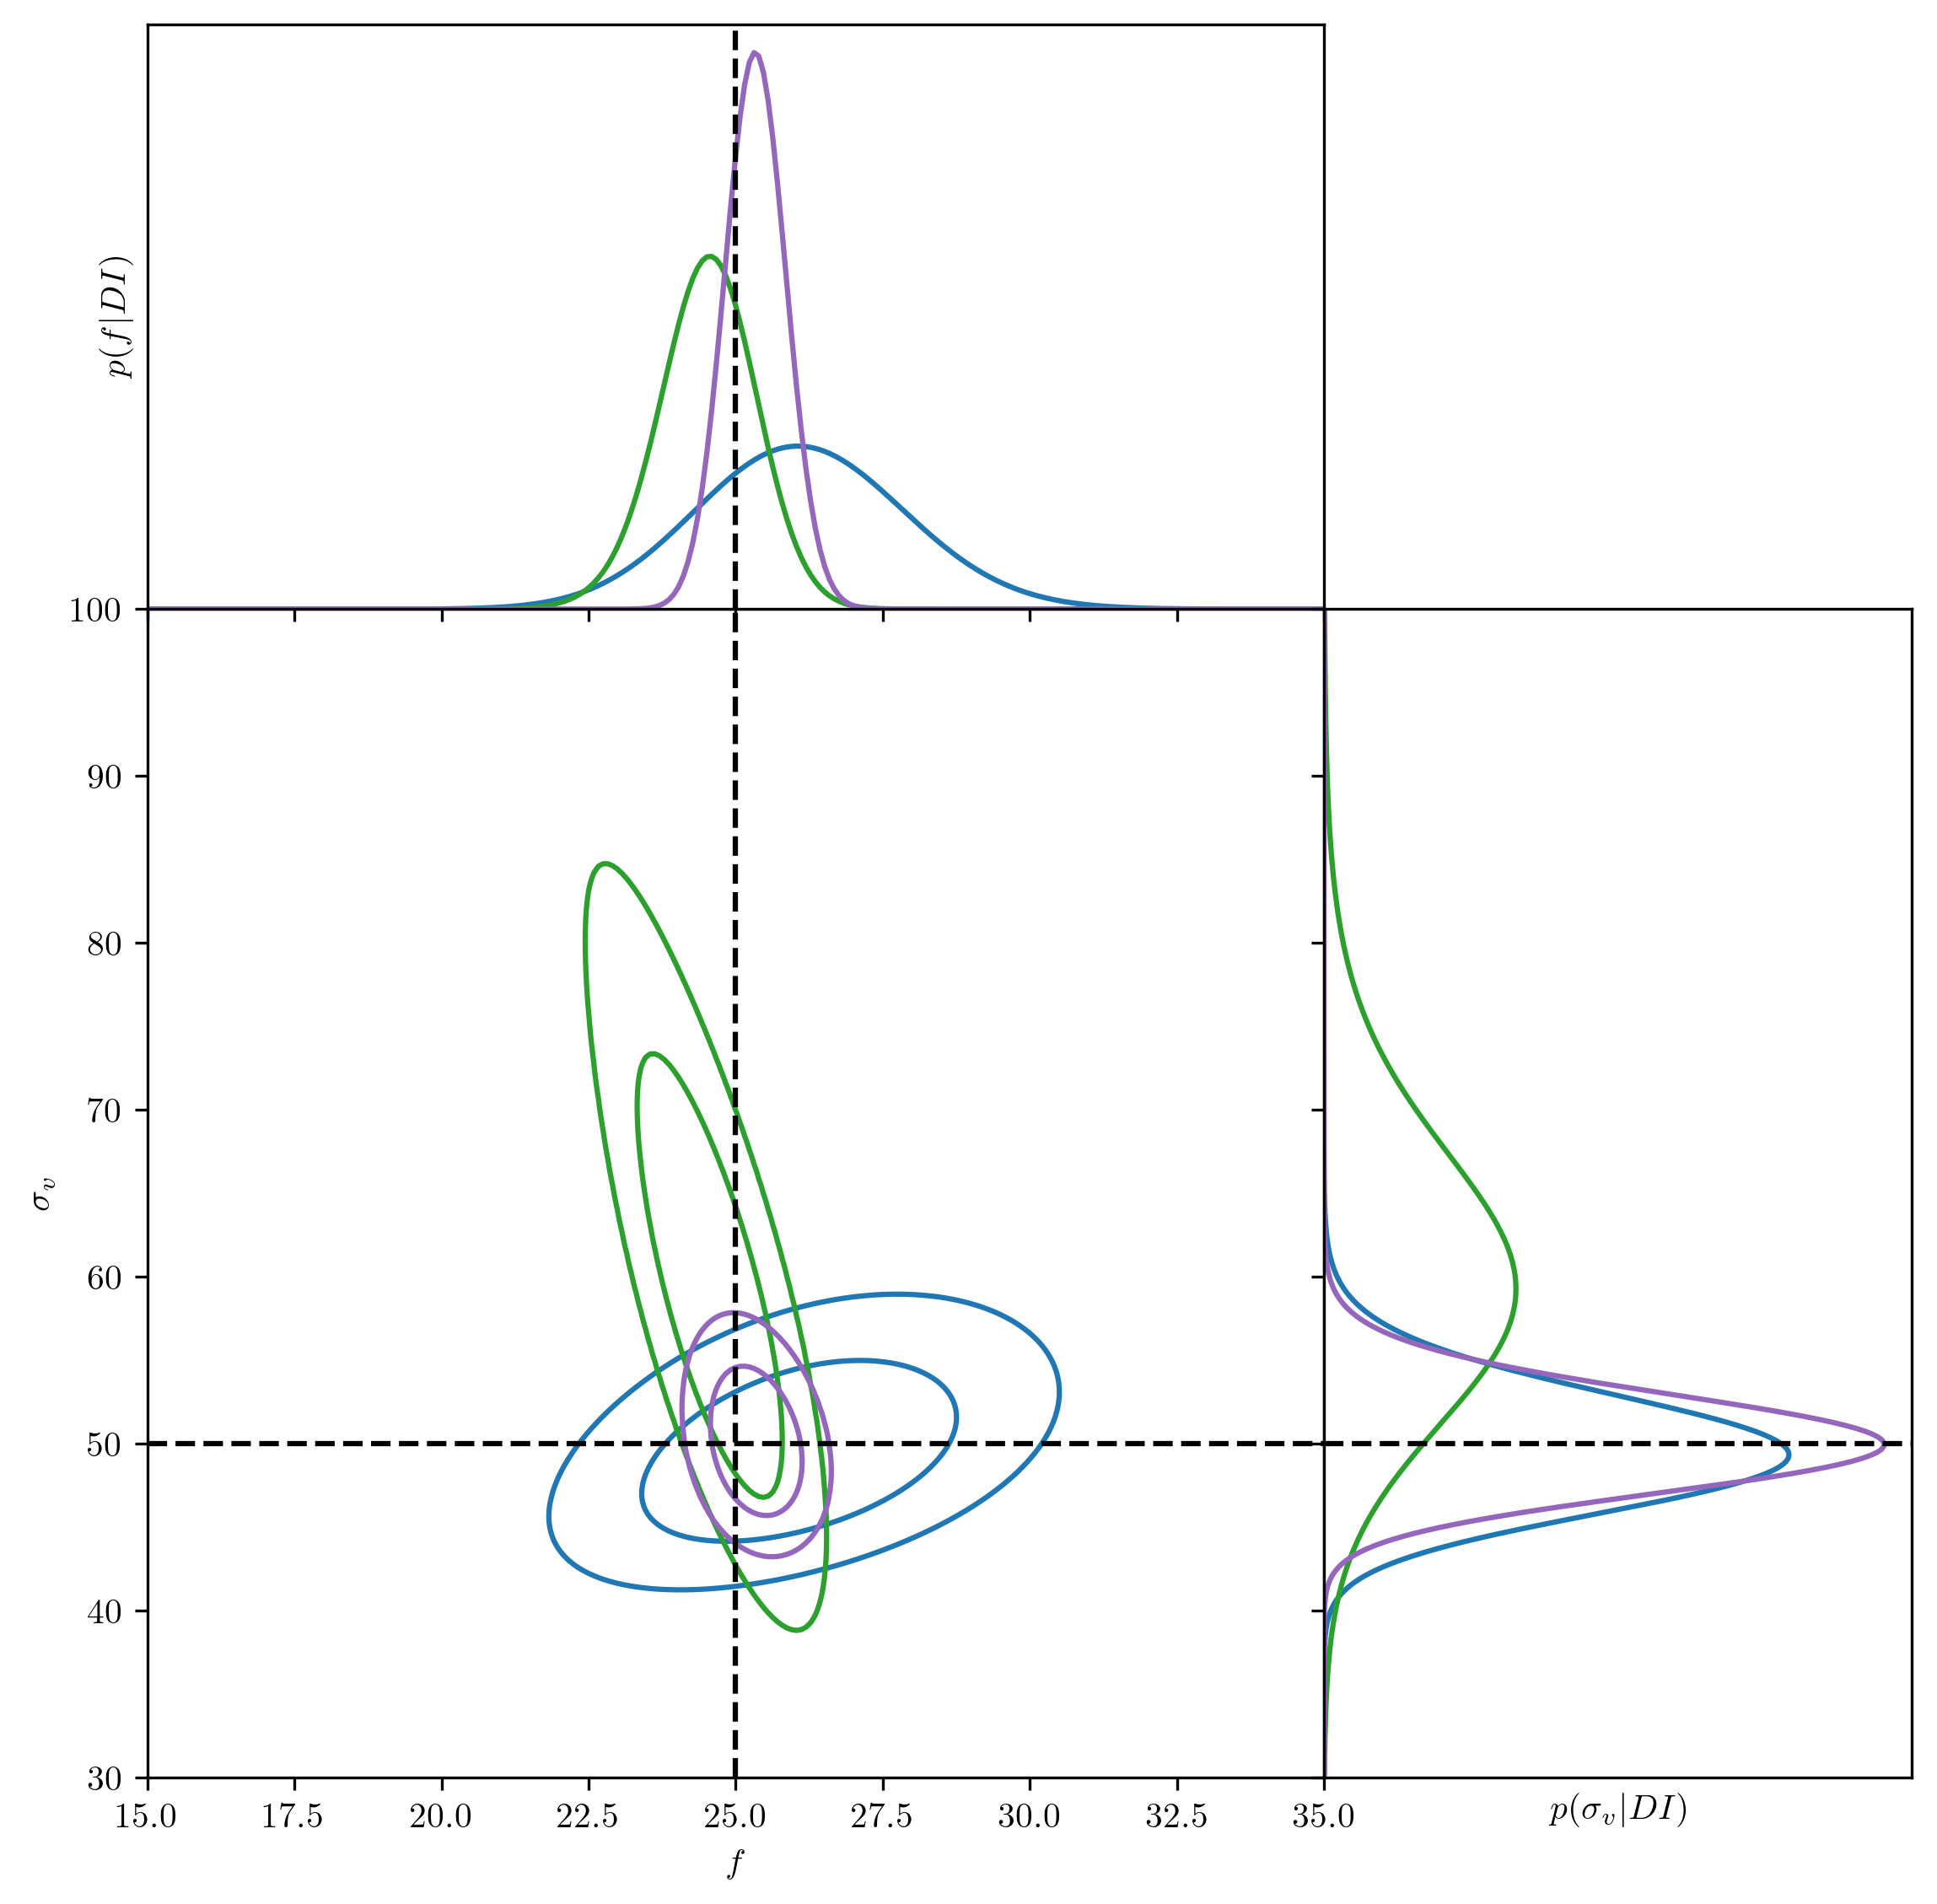

In [88]:
# Plot the refitted results
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# Joint posterior from refitting
plot_credible_levels(ax0, f_grid_refit, sigma_v_grid_refit, posterior_fs1_refit, colors='tab:blue')
ax1.plot(f_vals_refit, post_marg_f1_refit, color='tab:blue')
ax2.plot(post_marg_sigma_v1_refit, sigma_v_vals_refit, color='tab:blue')

plot_credible_levels(ax0, f_grid_refit, sigma_v_grid_refit, posterior_fs2_refit, colors='tab:green')
ax1.plot(f_vals_refit, post_marg_f2_refit, color='tab:green')
ax2.plot(post_marg_sigma_v2_refit, sigma_v_vals_refit, color='tab:green')

plot_credible_levels(ax0, combined_f_grid_refit, combined_sigma_v_grid_refit, combined_posterior_refit, colors='tab:purple')
ax1.plot(f_vals_combined_refit, post_marg_f_combined_refit, color='tab:purple')
ax2.plot(post_marg_sigma_v_combined_refit, sigma_v_vals_combined_refit, color='tab:purple')

ax0.axhline(sigma_v_true, color='k', linestyle='--')
ax0.axvline(f_true, color='k', linestyle='--')
ax1.axvline(f_true, color='k', linestyle='--')
ax2.axhline(sigma_v_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([f_true - 10, f_true + 10])
ax0.set_ylim([sigma_v_true - 20, sigma_v_true + 50])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$f$')
ax0.set_ylabel(r'$\sigma_v$')
ax1.set_ylabel(r'$p(f | DI)$')
ax2.set_xlabel(r'$p(\sigma_v | DI)$')
plt.show()

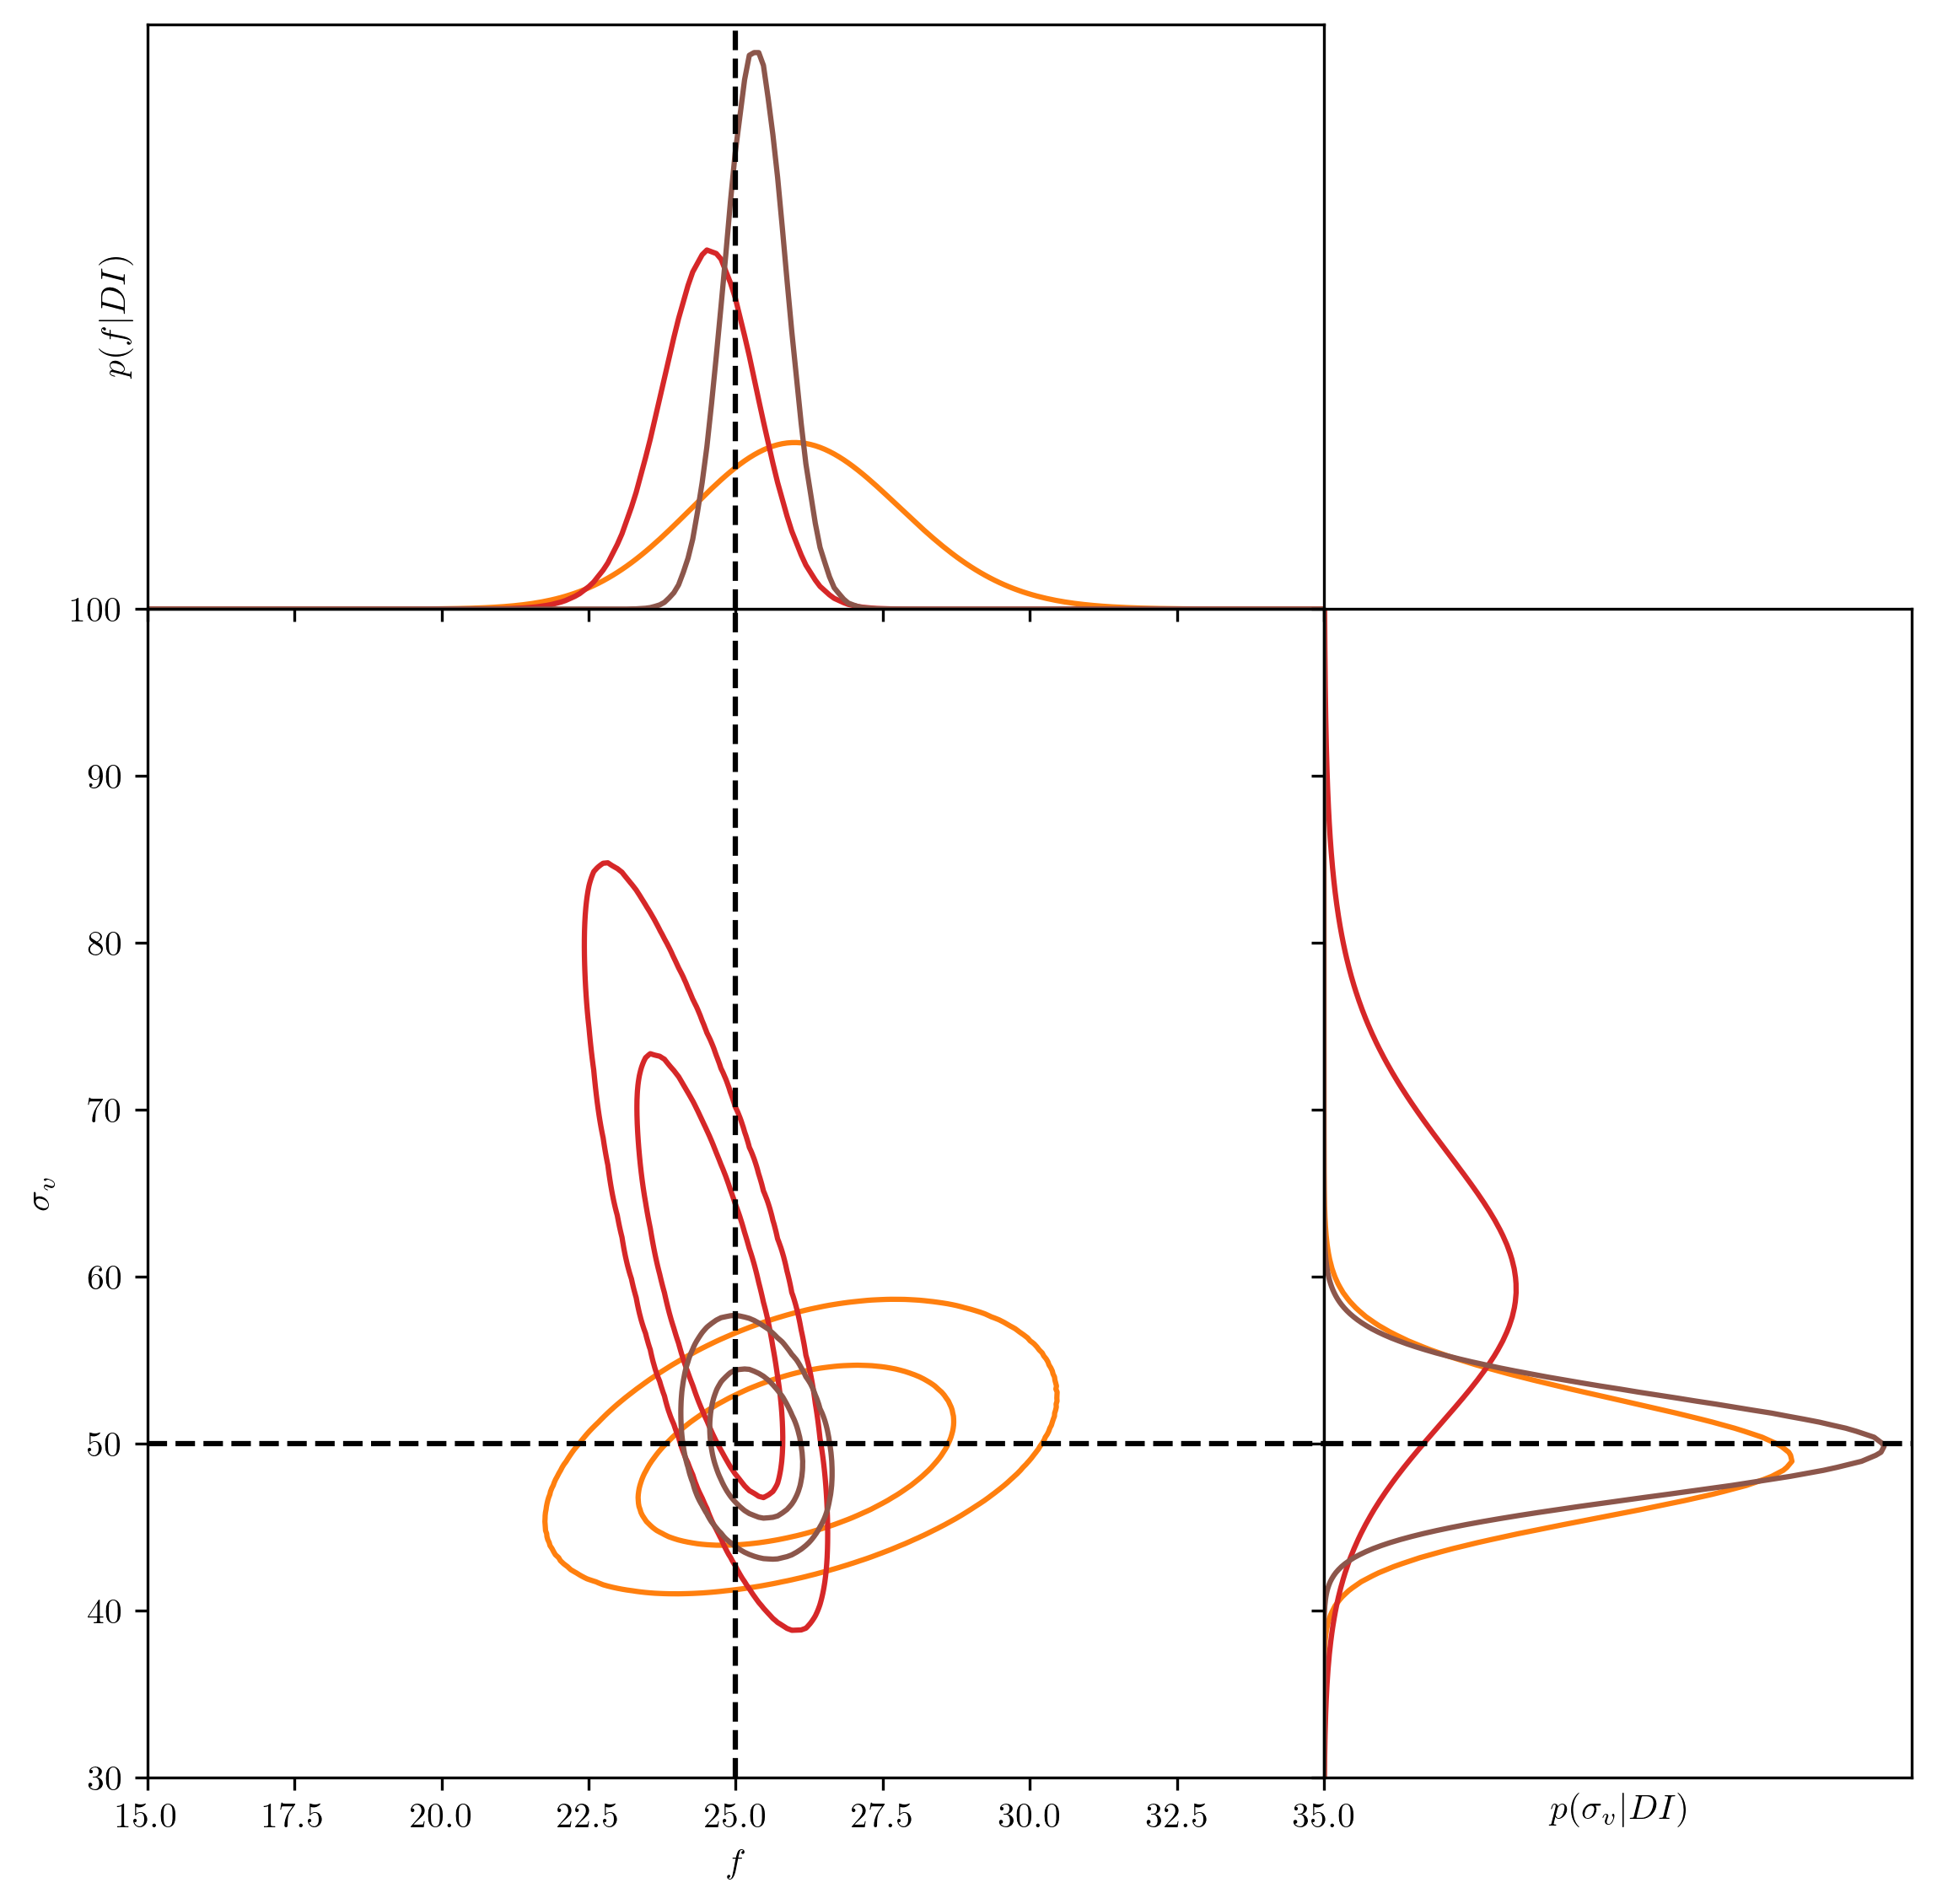

In [89]:
# Plot the resampled results
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# Joint posterior from resampling
plot_credible_levels(ax0, f_grid_resample, sigma_v_grid_resample, posterior_fs1_resample, colors='tab:orange')
ax1.plot(f_vals_resample, post_marg_f1_resample, color='tab:orange')
ax2.plot(post_marg_sigma_v1_resample, sigma_v_vals_resample, color='tab:orange')

plot_credible_levels(ax0, f_grid_resample, sigma_v_grid_resample, posterior_fs2_resample, colors='tab:red')
ax1.plot(f_vals_resample, post_marg_f2_resample, color='tab:red')
ax2.plot(post_marg_sigma_v2_resample, sigma_v_vals_resample, color='tab:red')

plot_credible_levels(ax0, f_grid_resample, sigma_v_grid_resample, combined_posterior_resample, colors='tab:brown')
ax1.plot(f_vals_combined_resample, post_marg_f_combined_resample, color='tab:brown')
ax2.plot(post_marg_sigma_v_combined_resample, sigma_v_vals_combined_resample, color='tab:brown')

ax0.axhline(sigma_v_true, color='k', linestyle='--')
ax0.axvline(f_true, color='k', linestyle='--')
ax1.axvline(f_true, color='k', linestyle='--')
ax2.axhline(sigma_v_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([f_true - 10, f_true + 10])
ax0.set_ylim([sigma_v_true - 20, sigma_v_true + 50])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$f$')
ax0.set_ylabel(r'$\sigma_v$')  
ax1.set_ylabel(r'$p(f | DI)$')
ax2.set_xlabel(r'$p(\sigma_v | DI)$')
plt.show()

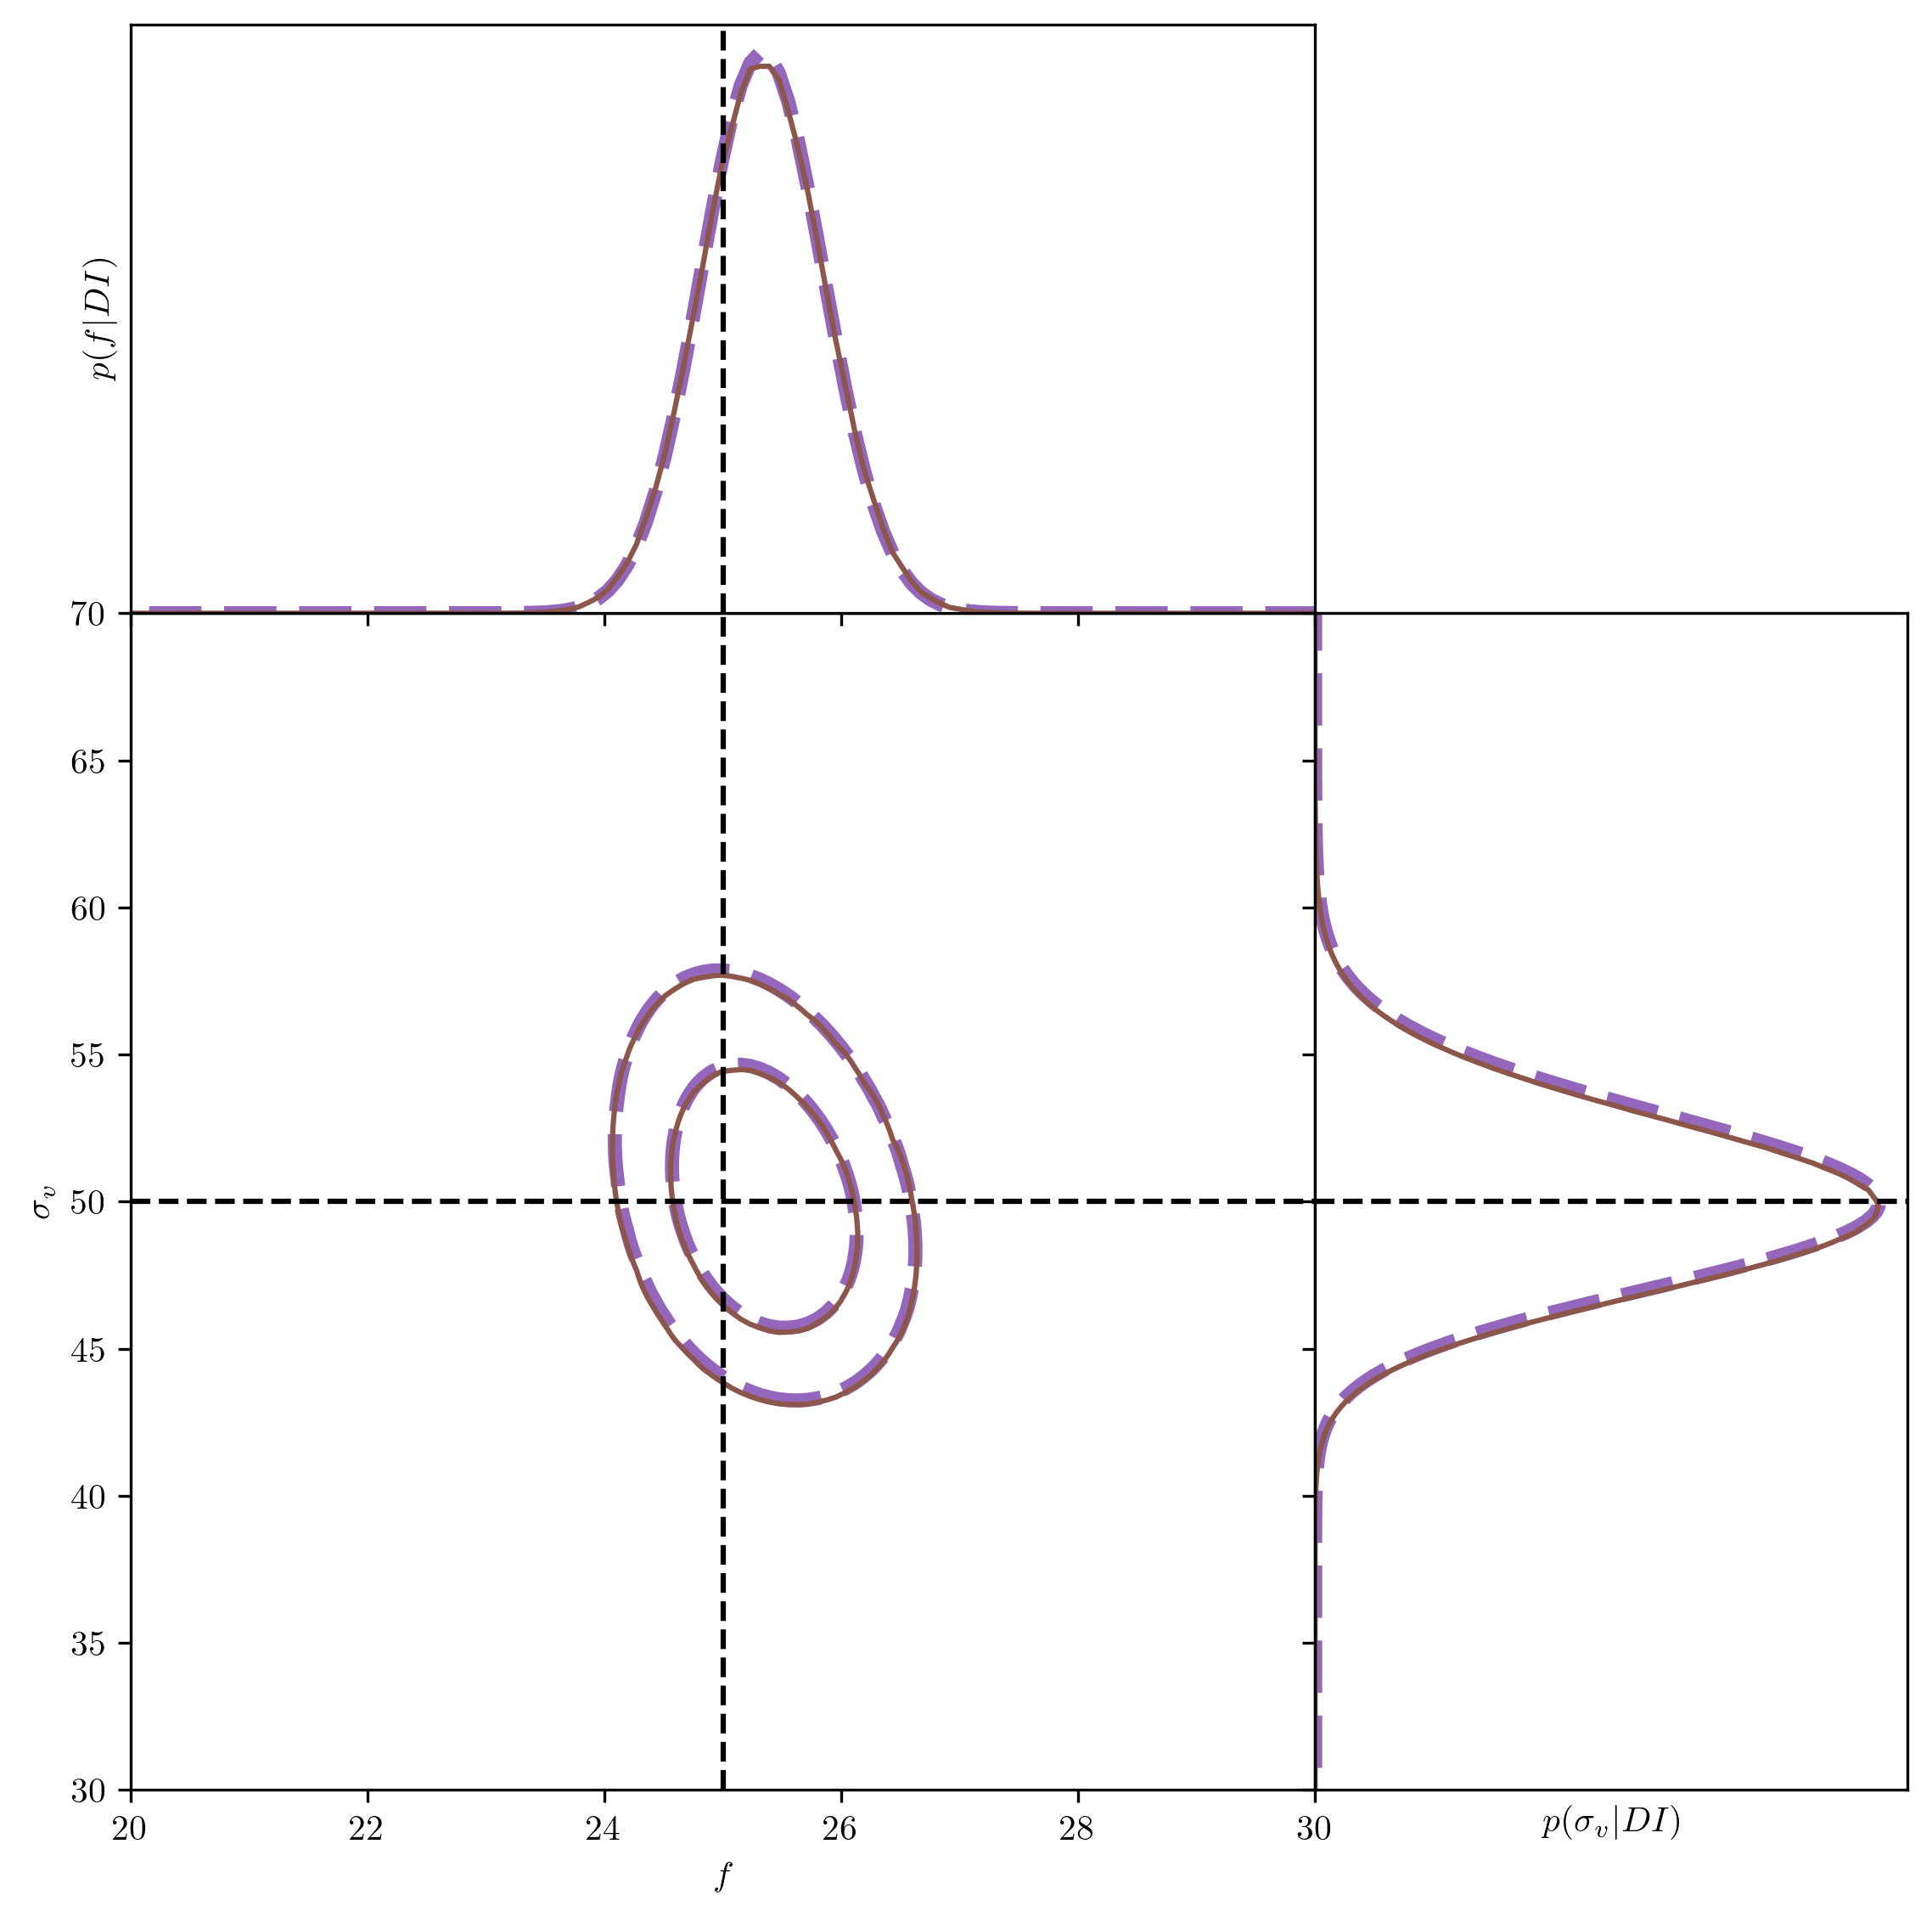

In [90]:
# Compare the joint posteriors from the two methods
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# Joint posterior from refitting
plot_credible_levels(ax0, combined_f_grid_refit, combined_sigma_v_grid_refit, combined_posterior_refit, colors='tab:purple', linewidths=4, linestyles='--')
ax1.plot(f_vals_combined_refit, post_marg_f_combined_refit, color='tab:purple', linewidth=4, linestyle='--')
ax2.plot(post_marg_sigma_v_combined_refit, sigma_v_vals_combined_refit, color='tab:purple', linewidth=4, linestyle='--')

# Joint posterior from resampling
plot_credible_levels(ax0, f_grid_resample, sigma_v_grid_resample, combined_posterior_resample, colors='tab:brown')
ax1.plot(f_vals_combined_resample, post_marg_f_combined_resample, color='tab:brown')
ax2.plot(post_marg_sigma_v_combined_resample, sigma_v_vals_combined_resample, color='tab:brown')

ax0.axhline(sigma_v_true, color='k', linestyle='--')
ax0.axvline(f_true, color='k', linestyle='--')
ax1.axvline(f_true, color='k', linestyle='--')
ax2.axhline(sigma_v_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([f_true - 5, f_true + 5])
ax0.set_ylim([sigma_v_true - 20, sigma_v_true + 20])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$f$')
ax0.set_ylabel(r'$\sigma_v$')
ax1.set_ylabel(r'$p(f | DI)$')
ax2.set_xlabel(r'$p(\sigma_v | DI)$')
plt.show()

#### Question 1.5: joint constraints with systematic bias

Assume that the flux calibration of the second spectrum has a systematic bias of 10 photon counts, i.e., the actual expected counts should be:

$N'_{\rm exp, 2} = A_2 \exp \left[ - \dfrac{(x - x_0)^2}{2 w_2^2} \right] + (B_2 + 10)$

**Tasks:**
1. Modify the observed spectrum from Question 1.2 accordingly and refit the parameters $f$ and $\sigma_v$ using the same scale-invariant priors in the ranges $f \in [10, 50]$ and $\sigma_v \in [10, 100]$, but assuming the systematic bias is known.
2. Repeat Question 1.4 (using either method that you prefer) to jointly infer $f$ and $\sigma_v$ from the two observed spectra, but assuming the systematic bias in the second spectrum is unknown.
3. Compare the posterior distributions of $f$ and $\sigma_v$ obtained here to those from Question 1.4, and report the mean, standard deviation, and 16-50-84 percentiles of the marginalized posterior distributions, as well as the covariance matrix of the joint posterior distribution.
4. Discuss all your results in the whole exercise.

**Hint:**
1. Modify the simulated data of the second spectrum by adding 10 to the observed counts.
2. Infer parameters using the same model as before in Question 1.2, but with the modified data.


In [91]:
spec_bias = 10

# Compute posteriors with biased second spectraum
f_grid_bias, sigma_v_grid_bias, posterior_fs2_bias = spec_posterior_fs_2(x, spec2 + spec_bias, A=A2_true, x0=0, f_range=[10, 50], sigma_v_range=[10, 100], n_f=500, n_sigma_v=500)

f_vals_bias, post_marg_f2_bias, sigma_v_vals_bias, post_marg_sigma_v2_bias = marginalize_posterior(f_grid_bias, sigma_v_grid_bias, posterior_fs2_bias)

# NOTE: EDIT below to compute the joint posteriors with the first spectrum and biased second spectrum using your favorite method
combined_f_grid_refit_bias, combined_sigma_v_grid_refit_bias, combined_posterior_refit_bias = joint_posterior_refit(
    x, spec1, spec2 + spec_bias, x0=0, f_range=(10, 50), sigma_v_range=(10, 100), n_f=500, n_sigma_v=500
)

f_vals_combined_refit_bias, post_marg_f_combined_refit_bias, sigma_v_vals_combined_refit_bias, post_marg_sigma_v_combined_refit_bias = marginalize_posterior(
    combined_f_grid_refit_bias, combined_sigma_v_grid_refit_bias, combined_posterior_refit_bias
)

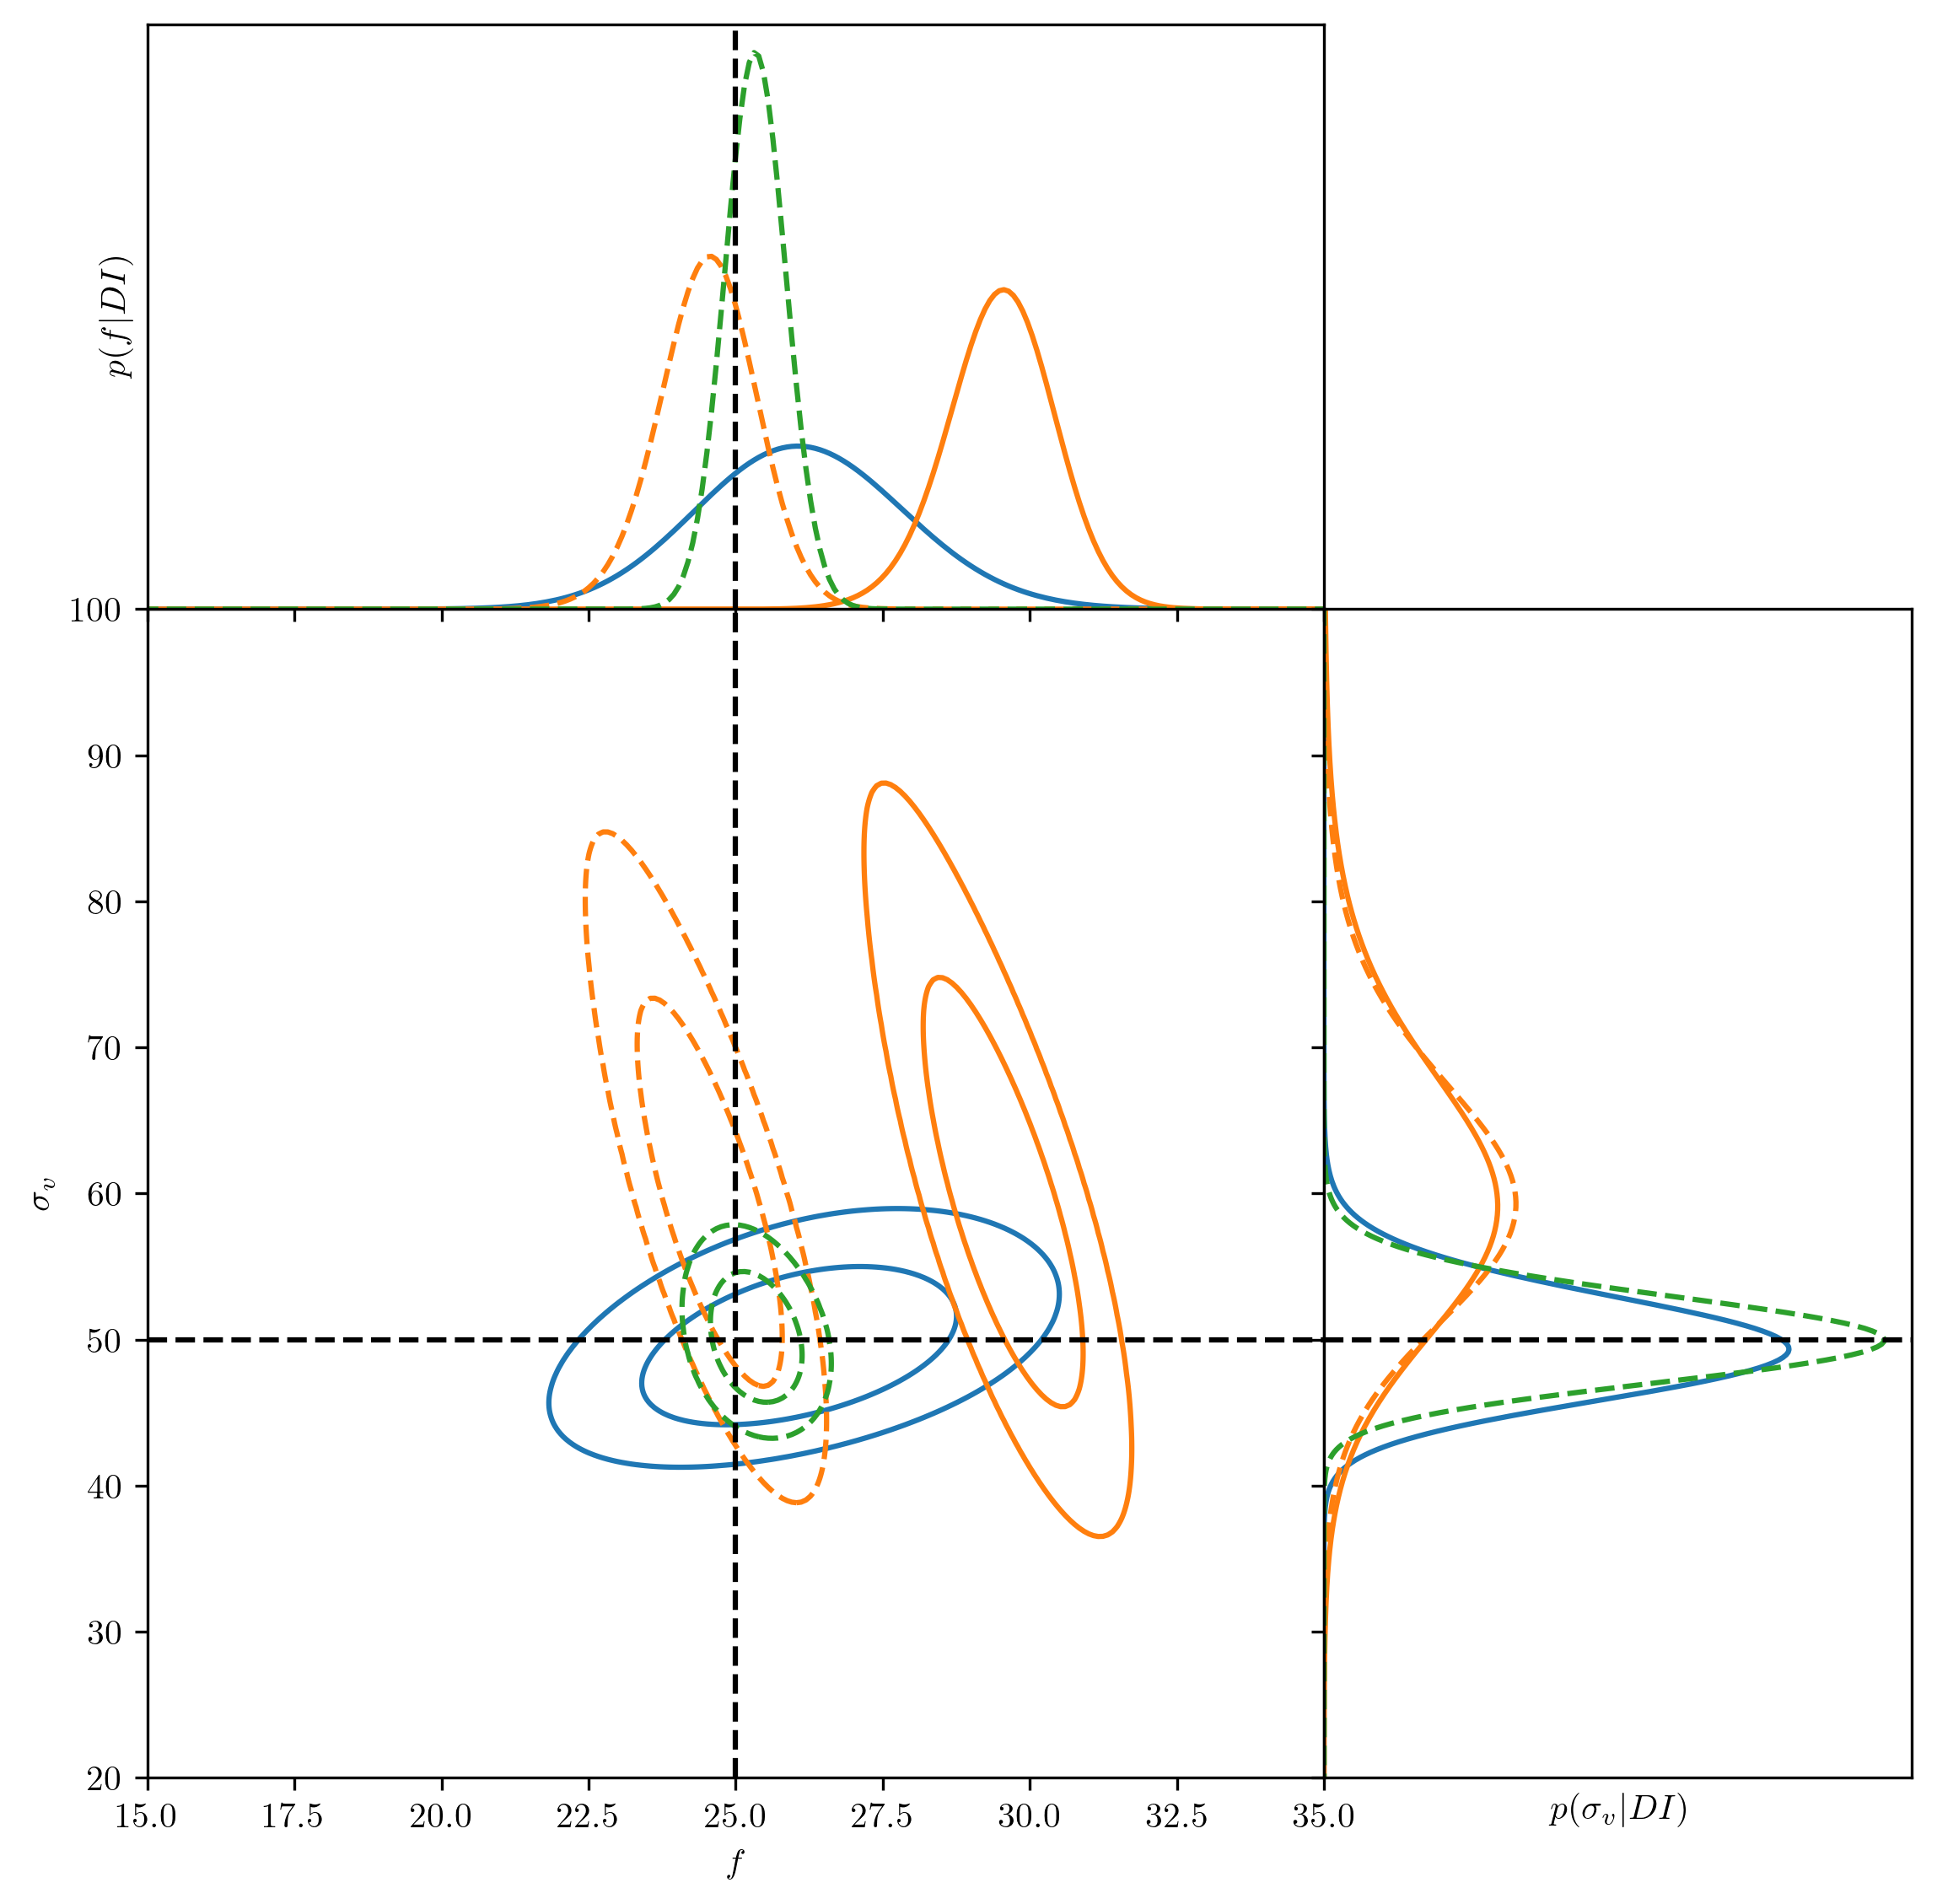

In [92]:
# Plot the results with biased data
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# Results from the first spectrum (unbiased)
plot_credible_levels(ax0, f_grid_refit, sigma_v_grid_refit, posterior_fs1_refit, colors='tab:blue')
ax1.plot(f_vals_refit, post_marg_f1_refit, color='tab:blue')
ax2.plot(post_marg_sigma_v1_refit, sigma_v_vals_refit, color='tab:blue')

# Results from the second spectrum (unbiased)
plot_credible_levels(ax0, f_grid_refit, sigma_v_grid_refit, posterior_fs2_refit, colors='tab:orange', linestyles='--')
ax1.plot(f_vals_refit, post_marg_f2_refit, color='tab:orange', linestyle='--')
ax2.plot(post_marg_sigma_v2_refit, sigma_v_vals_refit, color='tab:orange', linestyle='--')

# Results from second spectrum (biased)
plot_credible_levels(ax0, f_grid_bias, sigma_v_grid_bias, posterior_fs2_bias, colors='tab:orange')
ax1.plot(f_vals_bias, post_marg_f2_bias, color='tab:orange')
ax2.plot(post_marg_sigma_v2_bias, sigma_v_vals_bias, color='tab:orange')

# Joint results from both spectra (unbiased)
plot_credible_levels(ax0, combined_f_grid_refit, combined_sigma_v_grid_refit, combined_posterior_refit, colors='tab:green', linestyles='--')
ax1.plot(f_vals_combined_refit, post_marg_f_combined_refit, color='tab:green', linestyle='--')
ax2.plot(post_marg_sigma_v_combined_refit, sigma_v_vals_combined_refit, color='tab:green', linestyle='--')

# NOTE: EDIT below to plot joint results from both spectra (one biased)
...

ax0.axhline(sigma_v_true, color='k', linestyle='--')
ax0.axvline(f_true, color='k', linestyle='--')
ax1.axvline(f_true, color='k', linestyle='--')
ax2.axhline(sigma_v_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([f_true - 10, f_true + 10])
ax0.set_ylim([sigma_v_true - 30, sigma_v_true + 50])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$f$')
ax0.set_ylabel(r'$\sigma_v$')
ax1.set_ylabel(r'$p(f | DI)$')
ax2.set_xlabel(r'$p(\sigma_v | DI)$')
plt.show()

In [93]:
# NOTE: EDIT below to report and compare the summary statistics of f and sigma_v
# Report and compare summary statistics of f and sigma_v for different joint inferences

# Unbiased (refit)
mean_f_refit, std_f_refit, pct_f_refit = summarize_marginal(f_vals_combined_refit, post_marg_f_combined_refit, percentiles=[16,50,84])
mean_sigma_refit, std_sigma_refit, pct_sigma_refit = summarize_marginal(sigma_v_vals_combined_refit, post_marg_sigma_v_combined_refit, percentiles=[16,50,84])
mf_refit, ms_refit, cov_refit = covariance_from_2d(combined_f_grid_refit, combined_sigma_v_grid_refit, combined_posterior_refit)

# Resampled combination
mean_f_res, std_f_res, pct_f_res = summarize_marginal(f_vals_combined_resample, post_marg_f_combined_resample, percentiles=[16,50,84])
mean_sigma_res, std_sigma_res, pct_sigma_res = summarize_marginal(sigma_v_vals_combined_resample, post_marg_sigma_v_combined_resample, percentiles=[16,50,84])
mf_res, ms_res, cov_res = covariance_from_2d(f_grid_resample, sigma_v_grid_resample, combined_posterior_resample)

# Biased second spectrum (refit)
mean_f_bias, std_f_bias, pct_f_bias = summarize_marginal(f_vals_combined_refit_bias, post_marg_f_combined_refit_bias, percentiles=[16,50,84])
mean_sigma_bias, std_sigma_bias, pct_sigma_bias = summarize_marginal(sigma_v_vals_combined_refit_bias, post_marg_sigma_v_combined_refit_bias, percentiles=[16,50,84])
mf_bias, ms_bias, cov_bias = covariance_from_2d(combined_f_grid_refit_bias, combined_sigma_v_grid_refit_bias, combined_posterior_refit_bias)

# Print concise comparison
print("Combined (refit, unbiased):")
print(f" f: mean={mean_f_refit:.4f}, std={std_f_refit:.4f}, 16-50-84={pct_f_refit}")
print(f" sigma_v: mean={mean_sigma_refit:.4f}, std={std_sigma_refit:.4f}, 16-50-84={pct_sigma_refit}")
print(" Joint means (from 2D):", f"mean f={mf_refit:.4f}, mean sigma_v={ms_refit:.4f}")
print(" Covariance matrix (f, sigma_v):\n", cov_refit)
print()

print("Combined (resample):")
print(f" f: mean={mean_f_res:.4f}, std={std_f_res:.4f}, 16-50-84={pct_f_res}")
print(f" sigma_v: mean={mean_sigma_res:.4f}, std={std_sigma_res:.4f}, 16-50-84={pct_sigma_res}")
print(" Joint means (from 2D):", f"mean f={mf_res:.4f}, mean sigma_v={ms_res:.4f}")
print(" Covariance matrix (f, sigma_v):\n", cov_res)
print()

print("Combined (refit, biased second spectrum):")
print(f" f: mean={mean_f_bias:.4f}, std={std_f_bias:.4f}, 16-50-84={pct_f_bias}")
print(f" sigma_v: mean={mean_sigma_bias:.4f}, std={std_sigma_bias:.4f}, 16-50-84={pct_sigma_bias}")
print(" Joint means (from 2D):", f"mean f={mf_bias:.4f}, mean sigma_v={ms_bias:.4f}")
print(" Covariance matrix (f, sigma_v):\n", cov_bias)
print()

# Quick relative comparisons
def rel(a,b): return 100.0*(a-b)/b if b!=0 else np.nan
print("Relative std differences (resample vs refit, bias vs refit) [%]:")
print(f" std(f): resample vs refit = {rel(std_f_res,std_f_refit):+.2f}%,  bias vs refit = {rel(std_f_bias,std_f_refit):+.2f}%")
print(f" std(sigma_v): resample vs refit = {rel(std_sigma_res,std_sigma_refit):+.2f}%,  bias vs refit = {rel(std_sigma_bias,std_sigma_refit):+.2f}%")

Combined (refit, unbiased):
 f: mean=25.3349, std=0.5178, 16-50-84=[24.81826297 25.33327783 25.85192293]
 sigma_v: mean=50.2653, std=2.9955, 16-50-84=[47.29401799 50.16584822 53.23386323]
 Joint means (from 2D): mean f=25.3349, mean sigma_v=50.2653
 Covariance matrix (f, sigma_v):
 [[ 0.2681557  -0.40190673]
 [-0.40190673  8.97307827]]

Combined (resample):
 f: mean=25.3343, std=0.5249, 16-50-84=[24.81022976 25.33268514 25.85801923]
 sigma_v: mean=50.1077, std=2.9893, 16-50-84=[47.14316478 50.008763   53.07001326]
 Joint means (from 2D): mean f=25.3343, mean sigma_v=50.1077
 Covariance matrix (f, sigma_v):
 [[ 0.27556734 -0.39134022]
 [-0.39134022  8.93587159]]

Combined (refit, biased second spectrum):
 f: mean=29.6395, std=0.5551, 16-50-84=[29.08608119 29.63785547 30.19283398]
 sigma_v: mean=54.2995, std=3.1905, 16-50-84=[51.13786764 54.18494833 57.45778696]
 Joint means (from 2D): mean f=29.6395, mean sigma_v=54.2995
 Covariance matrix (f, sigma_v):
 [[ 0.30815024 -0.4491241 ]
 [-0.

##### Discussions

上面可以发现在正常做多元统计的情况下都可以得到比较好的结果，如果按流程进行参数变换，结果也是正常的；但是如果加入有偏的估计，可能会导致结果出现较大的偏差.

### Exercise 2: Lighthouse problem

A lighthouse is located at an unknown position $(\alpha, \beta)$, where $\alpha$ is the position along the shore and $\beta$ is the distance from the shore. The lighthouse emits light in random directions, and the light hits the coast at positions $x_k$.

See the slides of Lecture 4 for the illustration. The likelihood of observing a flash at position $x_k$ given the lighthouse position $(\alpha, \beta)$ is:

$$p(x_k | \alpha, \beta, I) = \dfrac{\beta}{\pi \left[ \beta^2 + (x_k - \alpha)^2 \right]}$$

#### Question 2.1: infer lighthouse position

**Tasks:**
1. Simulate $N=50$ flash positions $x_k$ from the lighthouse, with the true position $(\alpha, \beta) = (0, 1.0)$.
2. Infer the position $(\alpha, \beta)$ from the simulated flash positions using uniform priors $p(\alpha, \beta | I) = \text{const}$ with the ranges $\alpha \in [-5, 5]$ and $\beta \in [0.1, 5]$.
3. Plot the joint posterior distribution of $(\alpha, \beta)$ as well as the marginalized posterior distributions of each parameter.
4. Report the mean, standard deviation, and 16-50-84 percentiles of the marginalized posterior distributions, as well as the covariance matrix of the joint posterior distribution.



In [94]:
def sim_lighthouse_flashes(num, alpha, beta, seed=42):
    """Simulate positions of lighthouse flashes on the shoreline
    Args:
        num : int, number of flashes to simulate
        alpha : float, lighthouse position on x-axis
        beta : float, lighthouse position on y-axis
        seed : int, random seed for reproducibility (default: 42)
    Returns: array of x positions of the flashes
    """
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi/2, np.pi/2, num)
    x = alpha + beta * np.tan(theta)
    return x

In [95]:
def lighthouse_posterior(data, a_range=[-5,5], b_range=[0.1,5], n_a=500, n_b=500):
    """Compute the posterior distribution of lighthouse position (a,b) given observed flash positions.
    Args:
        data: array-like, observed x positions of the flashes
        a_range: list, prior range of a values (default: [-5, 5])
        b_range: list, prior range of b values (default: [0.1, 5])
        n_a: int, number of a samples (default: 500)
        n_b: int, number of b samples (default: 500)
    Returns:
        a_grid: numpy array, grid of a values
        b_grid: numpy array, grid of b values
        posterior: numpy array, joint posterior distribution of a and b
    """
    # Create grids for a and b
    a_vals = np.linspace(a_range[0], a_range[1], n_a)
    b_vals = np.linspace(b_range[0], b_range[1], n_b)
    dadb = (a_range[1] - a_range[0]) / n_a * (b_range[1] - b_range[0]) / n_b
    a_grid, b_grid = np.meshgrid(a_vals, b_vals)

    # NOTE: EDIT below to compute the joint posterior distribution
    eps = 1e-12
    data = np.asarray(data)
    # compute denominator for each data point on the (b,a) grid using broadcasting
    # shapes: data[:,None,None] -> (N, n_b, n_a), a_grid[None,:,:] -> (1, n_b, n_a)
    denom = b_grid[None, :, :]**2 + (data[:, None, None] - a_grid[None, :, :])**2
    # log-likelihood: sum_k [ log(beta) - log(pi) - log(beta^2 + (x_k - a)^2) ]
    log_like = np.sum(np.log(b_grid[None, :, :] + eps) - np.log(np.pi) - np.log(denom + eps), axis=0)
    # uniform prior over the provided ranges -> constant, so log_prior = 0
    log_post = log_like
    posterior = np.exp(log_post - np.max(log_post))
    posterior /= np.sum(posterior) * dadb  # Normalize posterior
    return a_grid, b_grid, posterior

In [96]:
nflash = 50
a_true = 0
b_true = 1
flash_data = sim_lighthouse_flashes(nflash, a_true, b_true, seed=seed)

a_grid, b_grid, posterior_lighthouse = lighthouse_posterior(flash_data, a_range=[-5,5], b_range=[0.1,5], n_a=500, n_b=500)
a_vals, post_marg_a, b_vals, post_marg_b = marginalize_posterior(a_grid, b_grid, posterior_lighthouse)

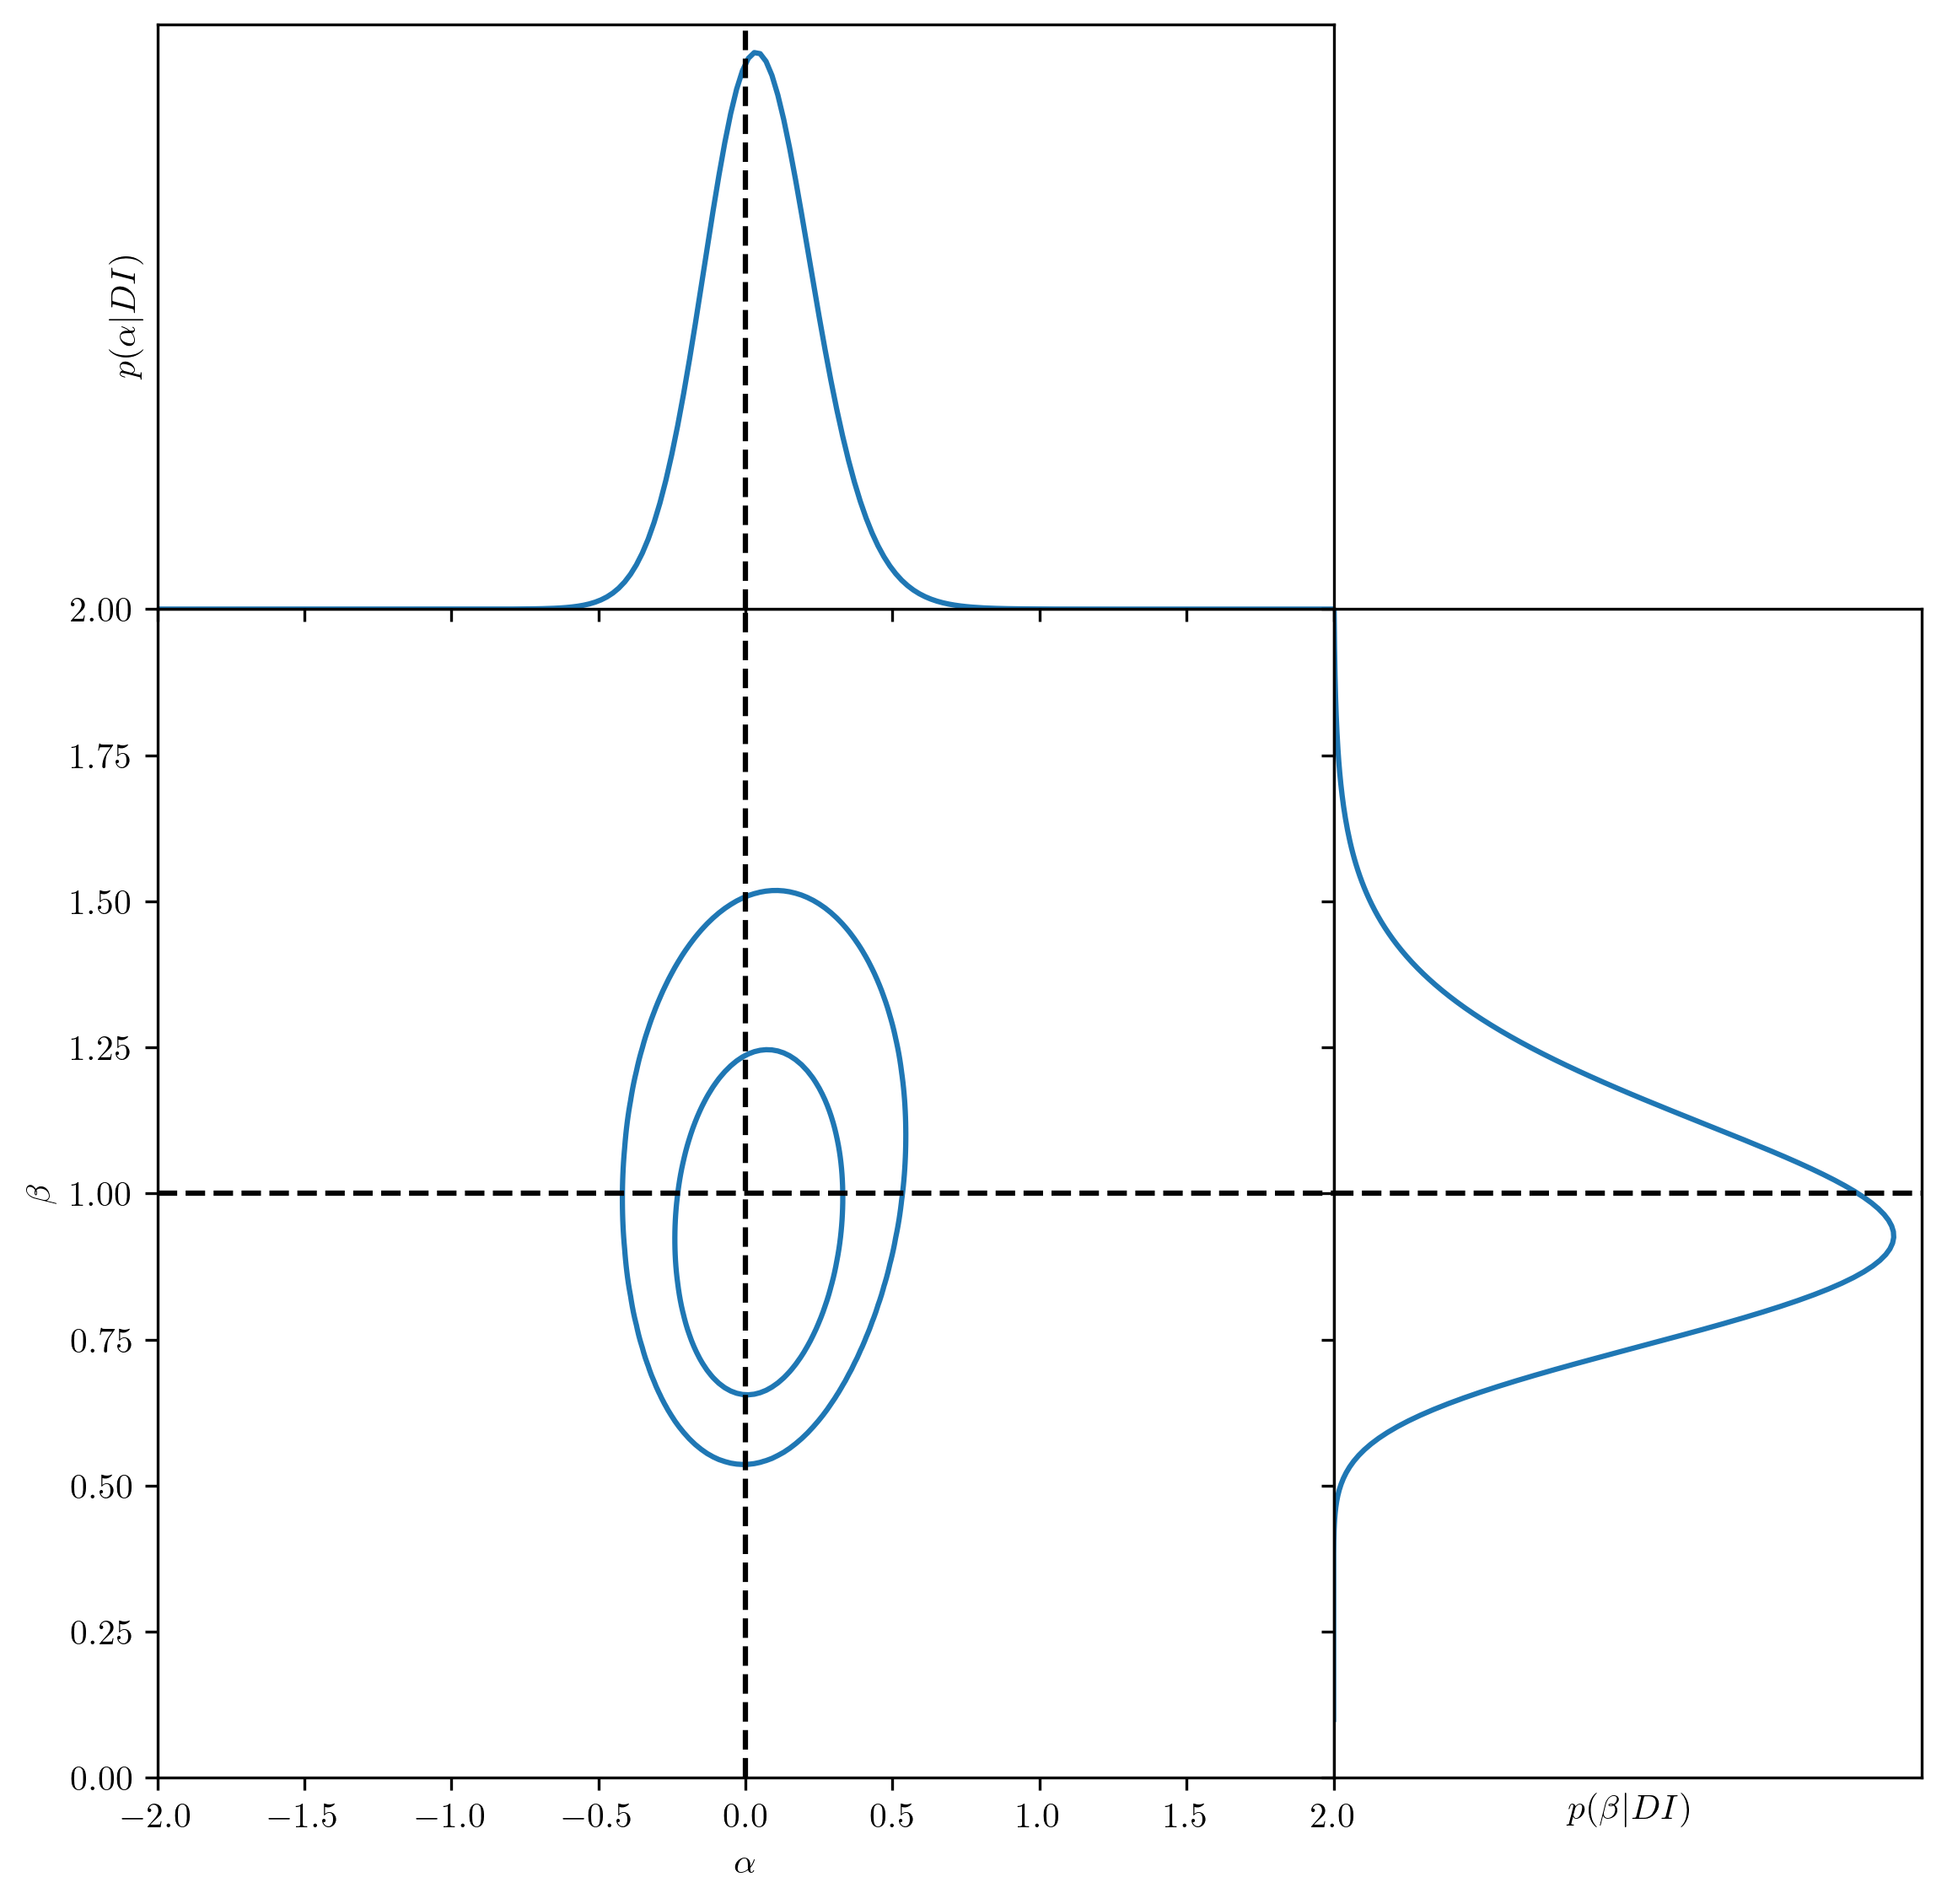

In [97]:
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

plot_credible_levels(ax0, a_grid, b_grid, posterior_lighthouse, colors='tab:blue')
ax1.plot(a_vals, post_marg_a, color='tab:blue')
ax2.plot(post_marg_b, b_vals, color='tab:blue')

ax0.axvline(a_true, color='k', linestyle='--')
ax0.axhline(b_true, color='k', linestyle='--')
ax1.axvline(a_true, color='k', linestyle='--')
ax2.axhline(b_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([a_true - 2, a_true + 2])
ax0.set_ylim([b_true - 1, b_true + 1])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$\alpha$')
ax0.set_ylabel(r'$\beta$')
ax1.set_ylabel(r'$p(\alpha | DI)$')
ax2.set_xlabel(r'$p(\beta | DI)$')
plt.show()

In [98]:
# NOTE: EDIT below to report the summary statistics
# Report summary statistics for Question 2.1 posterior of (alpha, beta)
mean_a, std_a, pct_a = summarize_marginal(a_vals, post_marg_a, percentiles=[16,50,84])
mean_b, std_b, pct_b = summarize_marginal(b_vals, post_marg_b, percentiles=[16,50,84])

mean_a_joint, mean_b_joint, cov_ab = covariance_from_2d(a_grid, b_grid, posterior_lighthouse)

print("Marginalized results:")
print(f" alpha: mean = {mean_a:.6f}, std = {std_a:.6f}, 16-50-84 = {pct_a}")
print(f" beta : mean = {mean_b:.6f}, std = {std_b:.6f}, 16-50-84 = {pct_b}\n")

print("Joint posterior means from full 2D posterior:")
print(f" mean alpha = {mean_a_joint:.6f}, mean beta = {mean_b_joint:.6f}\n")

print("Covariance matrix (alpha, beta):")
print(cov_ab)

Marginalized results:
 alpha: mean = 0.050002, std = 0.193516, 16-50-84 = [-0.13876655  0.04534612  0.23848185]
 beta : mean = 0.987411, std = 0.206081, 16-50-84 = [0.78684475 0.9670721  1.18727136]

Joint posterior means from full 2D posterior:
 mean alpha = 0.050002, mean beta = 0.987411

Covariance matrix (alpha, beta):
[[0.03744849 0.00503377]
 [0.00503377 0.04246944]]


#### Question 2.2: fixed parameter vs. marginalization

Suppose that $\alpha$ is fixed in the following two cases:
1. $\alpha$ is fixed at the true value $\alpha = 0$ from other observations;
2. $\alpha$ is fixed to the sample mean of the observed flash positions, i.e., $\alpha = \dfrac{1}{N} \sum_{k=1}^N x_k$.

**Tasks:**
1. Infer $\beta$ from the simulated flash positions in both cases using a uniform prior with the range $\beta \in [0.1, 5]$.
2. Plot the posterior distributions of $\beta$ obtained from the two cases above and that from Question 2.1 where $\alpha$ is marginalized over.
3. Compare the summary statistics (mean, standard deviation, and 16-50-84 percentiles) of the marginalized posterior distributions of $\beta$ obtained from the two cases above to that from Question 2.1 where $\alpha$ is marginalized over.

In [99]:
def posterior_lighthouse_fix_alpha(data, alpha=0, b_range=[0.1,5], n_b=500):
    """Compute the posterior distribution of lighthouse position b given observed flash positions and fixed alpha.
    Args:
        data: array-like, observed x positions of the flashes
        alpha: float, fixed lighthouse position on x-axis
        b_range: list, prior range of b values (default: [0.1, 5])
        n_b: int, number of b samples (default: 500)
    Returns:
        b_vals: array, list of b values
        posterior: array, posterior distribution of b
    """
    # NOTE: EDIT below to complete this function
    data = np.asarray(data)
    eps = 1e-12
    b_vals = np.linspace(b_range[0], b_range[1], n_b)
    # compute log-likelihood for each b on the grid
    # shapes: data[:,None] -> (N,1), b_vals[None,:] -> (1,n_b)
    denom = b_vals[None, :]**2 + (data[:, None] - alpha)**2
    log_like = np.sum(np.log(b_vals[None, :] + eps) - np.log(np.pi) - np.log(denom + eps), axis=0)
    # uniform prior over b -> log_prior = 0
    log_post = log_like
    posterior = np.exp(log_post - np.max(log_post))
    # normalize to unit integral over b
    posterior /= np.trapezoid(posterior, b_vals)
    return b_vals, posterior

In [100]:
# NOTE: EDIT below to compute the posteriors with fixed alpha values
# Compute posterior of beta with alpha fixed at true value 0
b_vals_alpha_0, posterior_b_alpha_0 = posterior_lighthouse_fix_alpha(flash_data, alpha=0, b_range=[0.1,5], n_b=len(b_vals))

# Compute posterior of beta with alpha fixed at sample mean of the data
alpha_mean = np.mean(flash_data)
b_vals_alpha_mean, posterior_b_alpha_mean = posterior_lighthouse_fix_alpha(flash_data, alpha=alpha_mean, b_range=[0.1,5], n_b=len(b_vals))

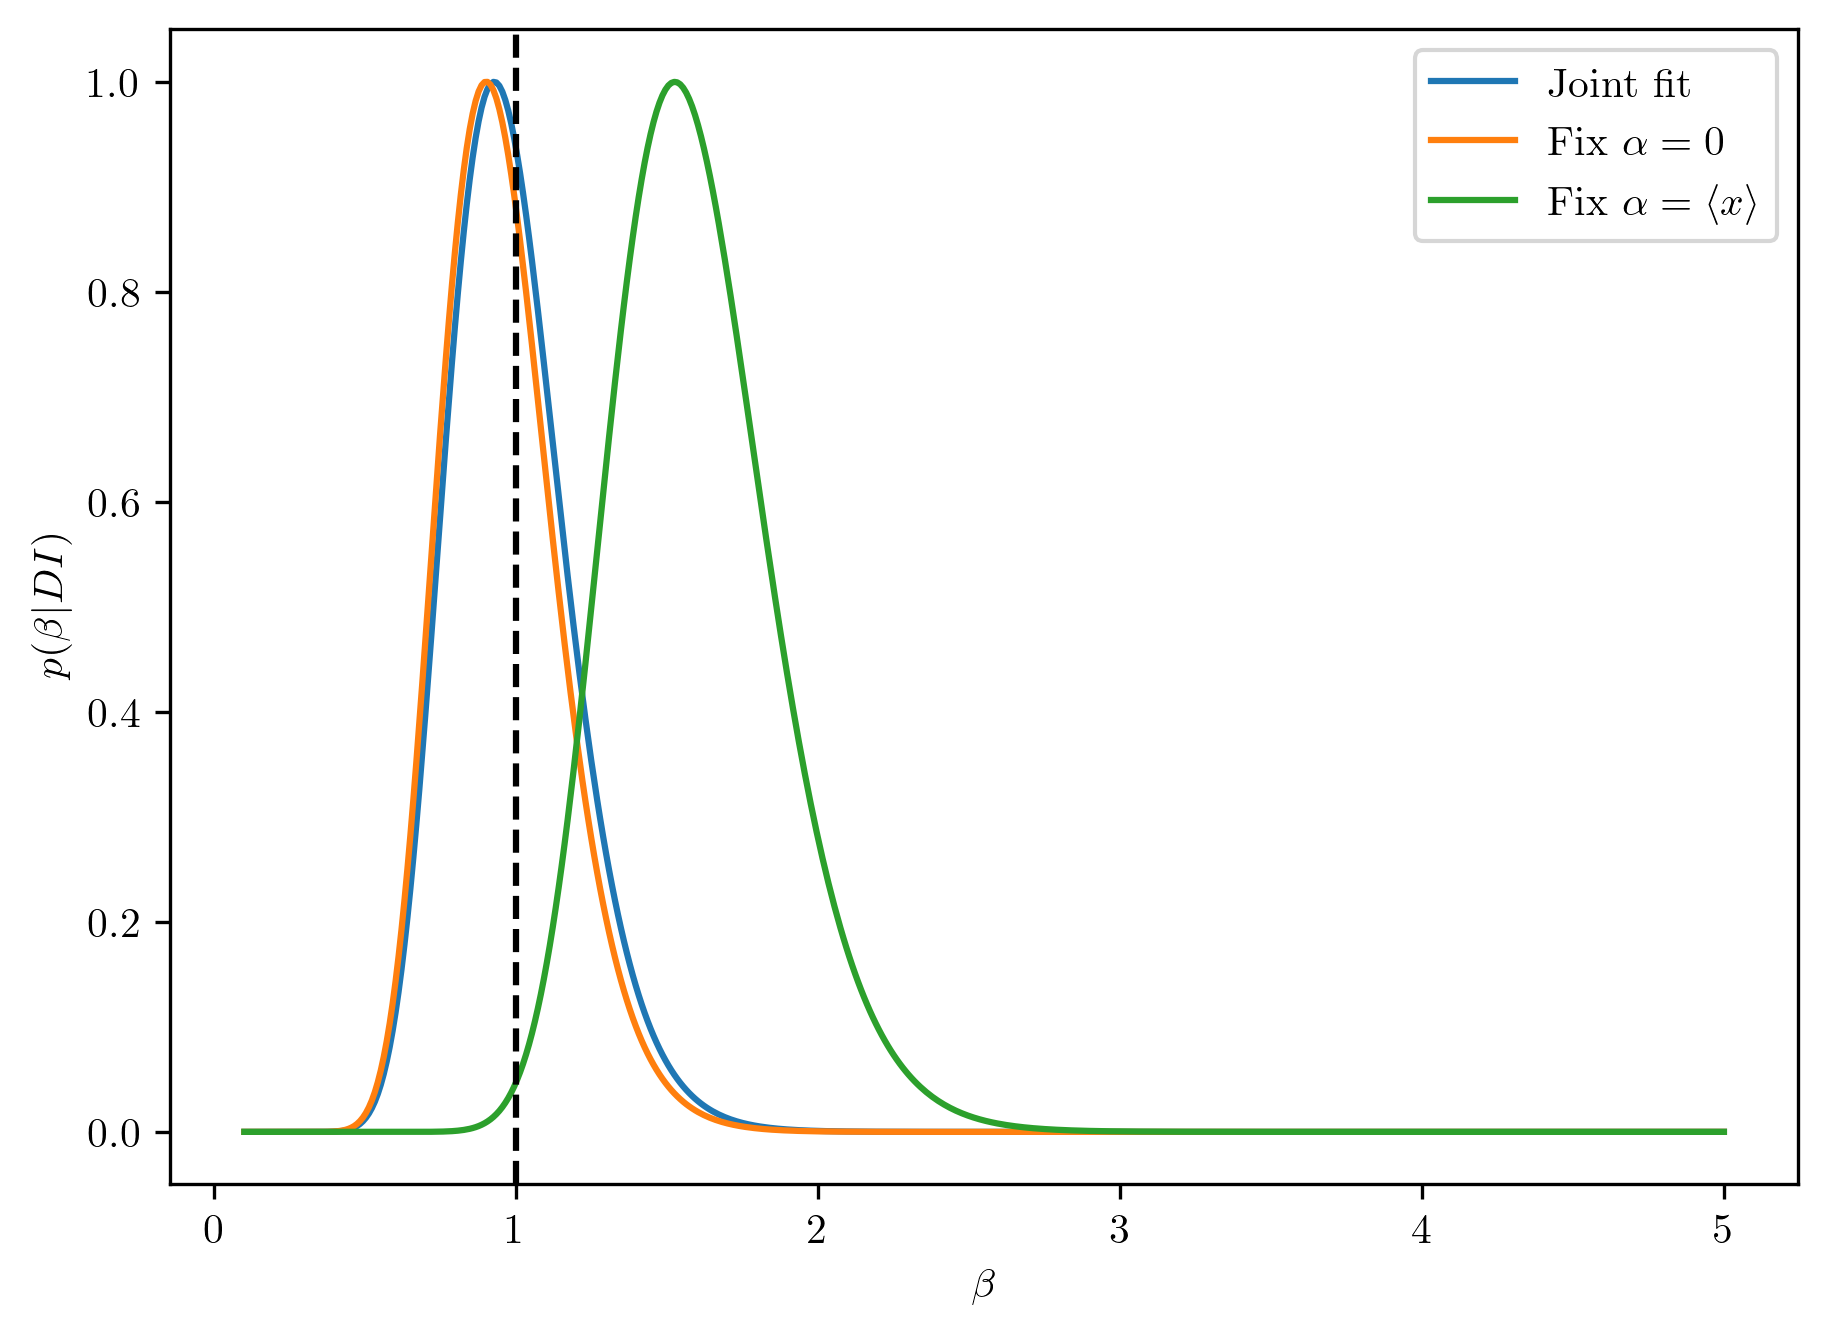

In [101]:
plt.figure(figsize=(7,5))

# Mariginal posterior from joint fit
plt.plot(b_vals, post_marg_b / post_marg_b.max(), color='tab:blue', label='Joint fit')
# Posterior with fixed alpha=0
plt.plot(b_vals_alpha_0, posterior_b_alpha_0 / posterior_b_alpha_0.max(), color='tab:orange', label=r'Fix $\alpha=0$')
# Posterior with fixed alpha=mean(data)
plt.plot(b_vals_alpha_mean, posterior_b_alpha_mean / posterior_b_alpha_mean.max(), color='tab:green', label=r'Fix $\alpha=\langle x \rangle$')

plt.axvline(b_true, color='k', linestyle='--')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$p(\beta | DI)$')
plt.legend()
plt.show()

In [102]:
# NOTE: EDIT below to compare the summary statistics
# Compute and print summary statistics for beta posteriors (Question 2.2)
mean_b_joint, std_b_joint, pct_b_joint = summarize_marginal(b_vals, post_marg_b, percentiles=[16,50,84])
mean_b_fix0, std_b_fix0, pct_b_fix0 = summarize_marginal(b_vals_alpha_0, posterior_b_alpha_0, percentiles=[16,50,84])
mean_b_fixmean, std_b_fixmean, pct_b_fixmean = summarize_marginal(b_vals_alpha_mean, posterior_b_alpha_mean, percentiles=[16,50,84])

print("比较 beta 的后验统计量：")
print("1) 边际化 alpha (joint fit):")
print(f"   mean = {mean_b_joint:.6f}, std = {std_b_joint:.6f}, 16-50-84 = {pct_b_joint}")
print()
print("2) 固定 alpha = 0:")
print(f"   mean = {mean_b_fix0:.6f}, std = {std_b_fix0:.6f}, 16-50-84 = {pct_b_fix0}")
print()
print("3) 固定 alpha = sample mean:")
print(f"   mean = {mean_b_fixmean:.6f}, std = {std_b_fixmean:.6f}, 16-50-84 = {pct_b_fixmean}")
print()

def rel_diff(a,b):
    return 100.0*(a-b)/b if b!=0 else np.nan

print("相对标准差差异 (相对于边际化结果，%)：")
print(f" 固定 alpha=0  相对 std  = {rel_diff(std_b_fix0, std_b_joint):+.2f}%")
print(f" 固定 alpha=mean 相对 std  = {rel_diff(std_b_fixmean, std_b_joint):+.2f}%")

比较 beta 的后验统计量：
1) 边际化 alpha (joint fit):
   mean = 0.987411, std = 0.206081, 16-50-84 = [0.78684475 0.9670721  1.18727136]

2) 固定 alpha = 0:
   mean = 0.958733, std = 0.198456, 16-50-84 = [0.76566423 0.93905711 1.15104847]

3) 固定 alpha = sample mean:
   mean = 1.592835, std = 0.273630, 16-50-84 = [1.32553793 1.56990384 1.85916739]

相对标准差差异 (相对于边际化结果，%)：
 固定 alpha=0  相对 std  = -3.70%
 固定 alpha=mean 相对 std  = +32.78%


#### Question 2.3: truncated data

Assume that due to observational limitations, only the flash positions within the range $x \in [x_{\rm min}, x_{\rm max}]$ can be detected. The flashes outside this range are not observed.

In this case, the angle of the lighthouse emission is still uniformly distributed, but within a limited range $[\theta_{\rm min}, \theta_{\rm max}]$, where

$\begin{aligned}
\theta_{\rm min} &= \arctan \left( \dfrac{x_{\rm min} - \alpha}{\beta} \right) \\
\theta_{\rm max} &= \arctan \left( \dfrac{x_{\rm max} - \alpha}{\beta} \right) \\
\end{aligned}$

The likelihood of observing a flash at position $x_k$ given the lighthouse position $(\alpha, \beta)$ now becomes:

$p(x_k | \alpha, \beta, \theta_{\rm min}, \theta_{\rm max}, I) = \dfrac{\beta}{\left[ \beta^2 + (x_k - \alpha)^2 \right] (\theta_{\rm max} - \theta_{\rm min})}$

**Tasks:**
1. Simulate $N=50$ flash positions $x_k$ from the lighthouse, with the true position $(\alpha, \beta) = (0, 1.0)$, but only keep those within the range $x \in [-3, 3]$.
2. Infer the position $(\alpha, \beta)$ from the truncated flash positions using uniform priors $p(\alpha, \beta | I) = \text{const}$ with the ranges $\alpha \in [-5, 5]$ and $\beta \in [0.1, 5]$, in the following two cases:
    - Ignoring the truncation and using the standard likelihood function;
    - Taking the truncation into account in the likelihood function.
3. Plot the joint posterior distributions of $(\alpha, \beta)$ as well as the marginalized posterior distributions of each parameter for the two cases.
4. Report the mean, standard deviation, and 16-50-84 percentiles of the marginalized posterior distributions, as well as the covariance matrix of the joint posterior distribution.
5. Discuss all your results in the whole exercise.

In [103]:
def posterior_lighthouse_truncated(data, a_range=[-5,5], b_range=[0.1,5], n_a=500, n_b=500, xmin=-3, xmax=3):
    """Compute the posterior distribution of lighthouse position (a,b) given observed flash positions within [xmin, xmax].
    Args:
        data: array-like, observed x positions of the flashes
        a_range: list, prior range of a values (default: [-5, 5])
        b_range: list, prior range of b values (default: [0.1, 5])
        n_a: int, number of a samples (default: 500)
        n_b: int, number of b samples (default: 500)
        xmin: float, minimum x value for truncation (default: -3)
        xmax: float, maximum x value for truncation (default: 3)
    Returns:
        a_grid: numpy array, grid of a values
        b_grid: numpy array, grid of b values
        posterior: numpy array, joint posterior distribution of a and b
    """
    # NOTE: EDIT below to complete this function
    a_vals = np.linspace(a_range[0], a_range[1], n_a)
    b_vals = np.linspace(b_range[0], b_range[1], n_b)
    dadb = (a_range[1] - a_range[0]) / n_a * (b_range[1] - b_range[0]) / n_b
    a_grid, b_grid = np.meshgrid(a_vals, b_vals)

    eps = 1e-12
    data = np.asarray(data)

    # compute theta range for truncation: theta_max - theta_min
    theta_max = np.arctan((xmax - a_grid) / (b_grid + eps))
    theta_min = np.arctan((xmin - a_grid) / (b_grid + eps))
    theta_range = np.maximum(theta_max - theta_min, eps)

    # compute denominator for each data point on the (b,a) grid using broadcasting
    denom = b_grid[None, :, :]**2 + (data[:, None, None] - a_grid[None, :, :])**2

    # log-likelihood using truncated likelihood:
    # log p(x_k|a,b) = log(beta) - log(beta^2 + (x_k-a)^2) - log(theta_range)
    log_like = np.sum(np.log(b_grid[None, :, :] + eps) - np.log(denom + eps) - np.log(theta_range[None, :, :] + eps), axis=0)

    # uniform prior over (a,b) -> constant, so log_prior = 0
    log_post = log_like

    posterior = np.exp(log_post - np.max(log_post))
    posterior /= np.sum(posterior) * dadb
    return a_grid, b_grid, posterior

In [104]:
# Generate truncated flash data
sel = (flash_data >= -3) & (flash_data <= 3)
flash_data_trunc = flash_data[sel]

# Compute the posteriors with truncated data using the correct likelihood
a_grid_trunc, b_grid_trunc, posterior_lighthouse_trunc = posterior_lighthouse_truncated(flash_data_trunc, a_range=[-5,5], b_range=[0.1,5], n_a=500, n_b=500, xmin=-3, xmax=3)
a_vals_trunc, post_marg_a_trunc, b_vals_trunc, post_marg_b_trunc = marginalize_posterior(a_grid_trunc, b_grid_trunc, posterior_lighthouse_trunc)

# Compute the posterior with truncated data using the likelihood ignoring truncation
a_grid_naive, b_grid_naive, posterior_lighthouse_naive = lighthouse_posterior(flash_data_trunc, a_range=[-5,5], b_range=[0.1,5], n_a=500, n_b=500)
a_vals_naive, post_marg_a_naive, b_vals_naive, post_marg_b_naive = marginalize_posterior(a_grid_naive, b_grid_naive, posterior_lighthouse_naive)

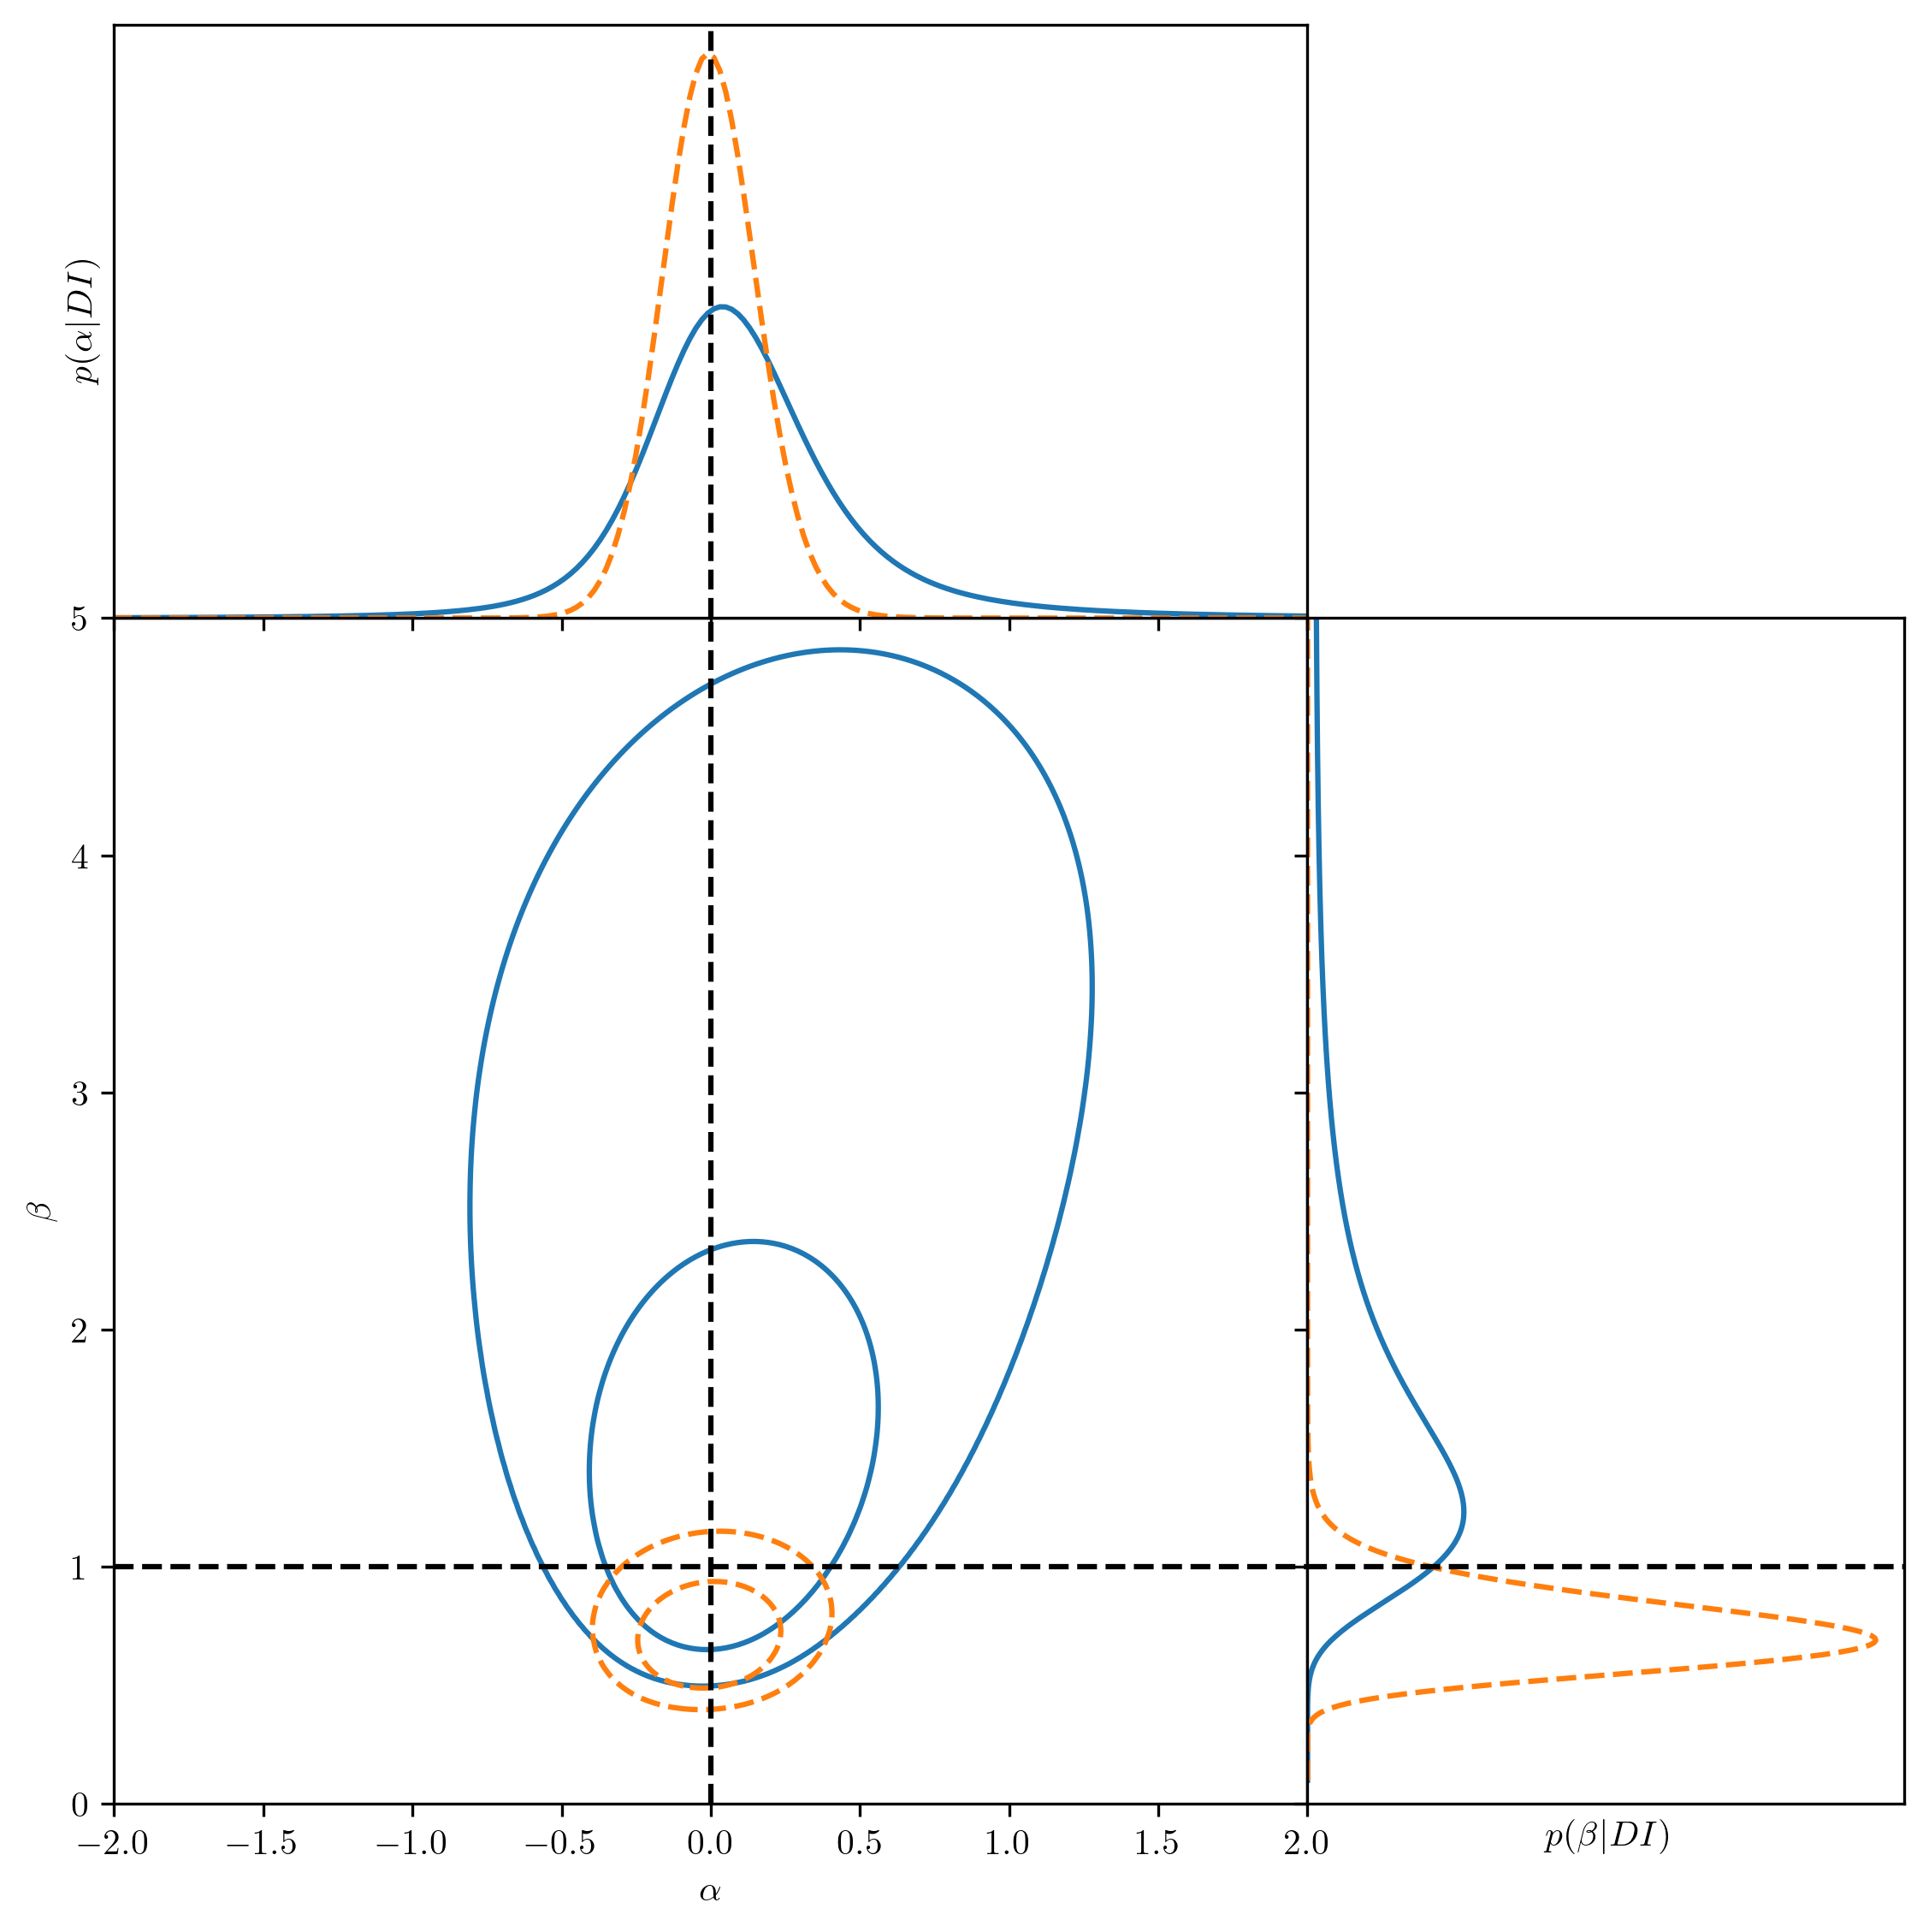

In [105]:
# Plot the posteriors for truncated data using both methods
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0, wspace=0)
ax0 = plt.subplot2grid((3,3), (1,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax0)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax0)

# Posterior using correct truncated likelihood
plot_credible_levels(ax0, a_grid_trunc, b_grid_trunc, posterior_lighthouse_trunc, colors='tab:blue')
ax1.plot(a_vals_trunc, post_marg_a_trunc, color='tab:blue')
ax2.plot(post_marg_b_trunc, b_vals_trunc, color='tab:blue')

# Posterior using naive likelihood ignoring truncation
plot_credible_levels(ax0, a_grid_naive, b_grid_naive, posterior_lighthouse_naive, colors='tab:orange', linestyles='--')
ax1.plot(a_vals_naive, post_marg_a_naive, color='tab:orange', linestyle='--')
ax2.plot(post_marg_b_naive, b_vals_naive, color='tab:orange', linestyle='--')

ax0.axvline(a_true, color='k', linestyle='--')
ax0.axhline(b_true, color='k', linestyle='--')
ax1.axvline(a_true, color='k', linestyle='--')
ax2.axhline(b_true, color='k', linestyle='--')

ax1.set_yticks([])
ax2.set_xticks([])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

# NOTE: Adjust the axis limits as needed
ax0.set_xlim([a_true - 2, a_true + 2])
ax0.set_ylim([b_true - 1, b_true + 4])
ax1.set_ylim(0, None)
ax2.set_xlim(0, None)

ax0.set_xlabel(r'$\alpha$')
ax0.set_ylabel(r'$\beta$')
ax1.set_ylabel(r'$p(\alpha | DI)$')
ax2.set_xlabel(r'$p(\beta | DI)$')
plt.show()

In [106]:
# NOTE: EDIT below to report and compare the summary statistics
# Compare summary statistics for truncated (correct likelihood) vs naive (ignore truncation)

# Marginal summaries
mean_a_trunc, std_a_trunc, pct_a_trunc = summarize_marginal(a_vals_trunc, post_marg_a_trunc, percentiles=[16,50,84])
mean_b_trunc, std_b_trunc, pct_b_trunc = summarize_marginal(b_vals_trunc, post_marg_b_trunc, percentiles=[16,50,84])

mean_a_naive, std_a_naive, pct_a_naive = summarize_marginal(a_vals_naive, post_marg_a_naive, percentiles=[16,50,84])
mean_b_naive, std_b_naive, pct_b_naive = summarize_marginal(b_vals_naive, post_marg_b_naive, percentiles=[16,50,84])

# Joint means and covariances
mean_a_trunc_joint, mean_b_trunc_joint, cov_trunc = covariance_from_2d(a_grid_trunc, b_grid_trunc, posterior_lighthouse_trunc)
mean_a_naive_joint, mean_b_naive_joint, cov_naive = covariance_from_2d(a_grid_naive, b_grid_naive, posterior_lighthouse_naive)

# Print concise comparison
print("Truncated-data (correct likelihood) - Marginalized results:")
print(f" alpha: mean={mean_a_trunc:.6f}, std={std_a_trunc:.6f}, 16-50-84={pct_a_trunc}")
print(f" beta : mean={mean_b_trunc:.6f}, std={std_b_trunc:.6f}, 16-50-84={pct_b_trunc}")
print(" Joint means (from 2D):", f"mean alpha={mean_a_trunc_joint:.6f}, mean beta={mean_b_trunc_joint:.6f}")
print(" Covariance (alpha, beta):")
print(cov_trunc)
print()

print("Naive (ignore truncation) - Marginalized results:")
print(f" alpha: mean={mean_a_naive:.6f}, std={std_a_naive:.6f}, 16-50-84={pct_a_naive}")
print(f" beta : mean={mean_b_naive:.6f}, std={std_b_naive:.6f}, 16-50-84={pct_b_naive}")
print(" Joint means (from 2D):", f"mean alpha={mean_a_naive_joint:.6f}, mean beta={mean_b_naive_joint:.6f}")
print(" Covariance (alpha, beta):")
print(cov_naive)
print()

# Relative differences in uncertainties (naive vs truncated)
def rel(a,b): return 100.0*(a-b)/b if b!=0 else np.nan

print("Relative differences in std (naive vs truncated) [%]:")
print(f" std(alpha): {rel(std_a_naive, std_a_trunc):+.2f}%")
print(f" std(beta) : {rel(std_b_naive, std_b_trunc):+.2f}%")

# Print true values for reference
print()
print("True values: alpha =", a_true, ", beta =", b_true)

Truncated-data (correct likelihood) - Marginalized results:
 alpha: mean=0.118507, std=0.459595, 16-50-84=[-0.20938383  0.07440176  0.41939215]
 beta : mean=1.839468, std=0.918042, 16-50-84=[1.06929984 1.56284717 2.66095767]
 Joint means (from 2D): mean alpha=0.118398, mean beta=1.839453
 Covariance (alpha, beta):
[[0.21078056 0.11104495]
 [0.11104495 0.84276468]]

Naive (ignore truncation) - Marginalized results:
 alpha: mean=-0.002017, std=0.161738, 16-50-84=[-0.16092241 -0.00438245  0.15653334]
 beta : mean=0.738827, std=0.158164, 16-50-84=[0.58519814 0.72262297 0.8918482 ]
 Joint means (from 2D): mean alpha=-0.002017, mean beta=0.738827
 Covariance (alpha, beta):
[[0.02615906 0.00224972]
 [0.00224972 0.02501576]]

Relative differences in std (naive vs truncated) [%]:
 std(alpha): -64.81%
 std(beta) : -82.77%

True values: alpha = 0 , beta = 1


##### Discussions

在 $(\alpha,\beta)$ 位置的估计上，如果直接取边缘化，得到的结果还算是比较准确；但是如果固定 $\alpha=\langle x\rangle$ 就会出现比较大的偏差；同时不同的边缘化方案也会造成结果的较大差异.

### Note: steps for submitting the exercise

1. In the menu bar, select `File > Download` to download your notebook as a `.ipynb` file.
2. Select `File > Save and Export Notebook As > PDF` to export your notebook as a PDF file.
3. Combine the `.ipynb` and `.pdf` files into a single `.zip` or `.tar.gz` archive.
4. Upload your archive to the web learning platform (网络学堂).